In [2]:
import define_transformations_afolu as dta
import define_transformations_circular_economy as dtc
import define_transformations_energy as dte
import define_transformations_ippu as dti
import define_transformations_integrated as dtr

import os, os.path
import numpy as np
import pandas as pd
#from model_attributes import *
import model_attributes as ma
import model_afolu as mafl
import model_ippu as mi
import model_circular_economy as mc
import model_electricity as ml
import model_energy as me
import model_socioeconomic as se
import setup_analysis as sa
import sisepuede_data_api as api
import sisepuede_models as sm
import support_classes as sc
import support_functions as sf
import importlib
import time
import warnings
import matplotlib.pyplot as plt
from typing import Union
import inspect
import ingestion as ing
import logging
from sisepuede_file_structure import *
import transformations_base_afolu as tba
import transformations_base_circular_economy as tbc
import transformations_base_energy as tbe
import transformations_base_general as tbg
import transformations_base_ippu as tbi


importlib.reload(ma)
importlib.reload(sa)
importlib.reload(sf)
importlib.reload(mafl)
importlib.reload(mc)
importlib.reload(mi)
importlib.reload(me)
importlib.reload(se)
importlib.reload(tbc)
importlib.reload(tbe)


import sisepuede as ssp


def _setup_logger(namespace: str, fn_out: Union[str, None] = None) -> None:
    global logger
    
    format_str = "%(asctime)s - %(levelname)s - %(message)s"
    # configure
    if fn_out is not None:
        logging.basicConfig(
            filename = fn_out,
            filemode = "w",
            format = format_str,
            level = logging.DEBUG
        )
    else:
        logging.basicConfig(
            format = format_str,
            level = logging.DEBUG
        )
        
    logger = logging.getLogger(namespace)
    # create console handler and set level to debug
    ch = logging.StreamHandler()
    ch.setLevel(logging.DEBUG)
    # create formatter
    formatter = logging.Formatter(format_str)
    # add formatter to ch
    ch.setFormatter(formatter)
    # add ch to logger
    logger.addHandler(ch)

    return logger

_setup_logger(__name__, os.path.join(os.getcwd(), "log_build_sisepuede_transformations.log"))


/Users/jsyme/Documents/Projects/git_jbus/sisepuede/python/model_attributes.py:2586: UserWarning: Invalid subsector attribute 'key_varreqs_partial'. Valid return type values are:'pycategory_primary', 'abv_subsector', 'sector', 'abv_sector', 'key_varreqs_all'
  warnings.warn(f"Invalid subsector attribute '{return_type}'. Valid return type values are:{valid_rts}")
/Users/jsyme/Documents/Projects/git_jbus/sisepuede/python/model_attributes.py:2343: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for desig, df in df_by_designation:


<Logger __main__ (DEBUG)>

# Use the TransformationsIntegrated class to build input templates

- allows to specify any strategies/regions for which to build templates

- writes in-line to Excel templates

- for all strategies, about 5-min per (can and will improve this runtime)

- use `transformations_integrated.build_strategies_to_templates()` to build (docstring included with `?`)


**NOTE**: The `TransformationsIntegrated` class will instantiate a new SISEPUEDE AnalysisID, but the id does not correspond with a directory or any model runs. Ignore it

In [8]:
vr = np.array([float(sf.vec_bounds((x - 9)/25, (0, 1))) for x in range(37)])
w = np.where(vr > 0)[0][0]
np.array([float(sf.vec_bounds((x - (w - 1))/5, (0, 1))) for x in range(37)])

array([0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.2, 0.4, 0.6,
       0.8, 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ])

# NOTE TO JAMES:
- FIX ERROR WHERE transformations_integrated CANNOT INSTANTIATE A TEMPLATE IF IT DOESN'T EXIST
- Should be able to initialize a template with base_input_database_demo or input_template

In [9]:
importlib.reload(sf)
importlib.reload(tba)
importlib.reload(dta)
importlib.reload(dtr)

regions_lac = [
    "argentina",
    "bahamas",
    "barbados",
    "belize",
    "bolivia",
    "brazil",
    "chile",
    "colombia",
    "costa_rica",
    "dominican_republic",
    "ecuador",
    "el_salvador",
    "guatemala",
    "guyana",
    "haiti",
    "honduras",
    "jamaica",
    "mexico",
    "nicaragua",
    "panama",
    "paraguay",
    "peru",
    "suriname",
    "trinidad_and_tobago",
    "uruguay",
    "venezuela"
]



year_0_ramp = 2025
dir_calibs = "/Users/jsyme/Documents/Projects/FY21/SWCHE131_1000/Data/calibrated_input_files_from_edmundo"
fp_inputs = os.path.join(dir_calibs, "input_all_sectors.csv")
df_input = pd.read_csv(fp_inputs)
field_region = "nation"

regions_run = [
    x for x in sorted(regions_lac) if x in list(df_input[field_region].unique())
]

# reduce inputs
df_input = df_input[
    df_input[field_region].isin(regions_run)
].reset_index(drop = True)

warnings.filterwarnings("ignore")

if True:
    # set some parameters (WILL SET TO READ FROM A CONFIG OR STRATEGY DEFINITION FILE)
    dict_config_te = {
        "categories_entc_max_investment_ramp": [
            "pp_hydropower",
            "pp_nuclear"
        ],
        "categories_entc_renewable": [
            "pp_geothermal",
            "pp_hydropower",
            "pp_ocean",
            "pp_solar",
            "pp_wind"
        ],
        "categories_inen_high_heat": [
            "cement", 
            "chemicals", 
            "glass", 
            "lime_and_carbonite", 
            "metals"
        ],
        "dict_entc_renewable_target_msp": {
            "pp_solar": 0.15,
            "pp_geothermal": 0.1,
            "pp_wind": 0.15
        },
        "frac_inen_high_temp_elec_hydg": 0.5*0.45,
        "frac_inen_low_temp_elec": 0.95*0.45,
        "n_tp_ramp": None,
        "vir_renewable_cap_delta_frac": 0.01,
        "vir_renewable_cap_max_frac": 0.05,
        "year_0_ramp": year_0_ramp
    }



    transformations_integrated = dtr.TransformationsIntegrated(
        dict_config_te,
        df_input = df_input,
        field_region = field_region,
        logger = logger,
        regions = regions_run,
    )



2023-07-11 02:00:42,309 - INFO - Successfully initialized Analysis ID 'sisepuede_run_2023-07-11T02:00:42.309268'
2023-07-11 02:00:42,310 - INFO - Verification of SISEPUEDE directory structure completed successfully with 0 errors.
2023-07-11 02:00:43,858 - INFO - NemoMod reference file checks completed successfully.
2023-07-11 02:00:43,860 - INFO - Successfully initialized SISEPUEDEFileStructure.
2023-07-11 02:00:43,863 - INFO - Initializing BaseInputDatabase


In [146]:
df_regions_run = pd.DataFrame({regions.key: regions_run})
df_regions_run.to_csv(
    os.path.join(sa.dir_tmp, "regions_run.csv"),
    index = None,
    encoding = "UTF-8"
)

In [10]:
def get_strategies_from_codes(
    strategy_codes: Union[List[str], str],
) -> Union[List[int], None]:
    """
    Map codes to id as input
    """
    attr_strat = sa.model_attributes.dict_attributes.get("dim_strategy_id")
    dict_map = attr_strat.field_maps.get(f"strategy_code_to_{attr_strat.key}")
    
    # check specification of codes
    strategy_codes = (
        [strategy_codes] 
        if isinstance(strategy_codes, str)
        else (
            strategy_codes
            if sf.islistlike(strategy_codes)
            else None
        )
    )
    if strategy_codes is None:
        return None
    
    # get ids to build
    strategies_build = [dict_map.get(x) for x in strategy_codes]
    strategies_build = [x for x in strategies_build if x is not None]
    out = (
        None
        if len(strategies_build) == 0
        else strategies_build
    )
    
    return out
    
strategy_codes_keep = [
    "BASE",
    "LNDU:PLUR",
    "PFLO:BETTER_BASE",
    "PFLO:CHANGE_CONSUMPTION",
    "PFLO:SUPPLY_SIDE_TECH",
    "PFLO:ALL_PLUR"
]
strategies_keep = get_strategies_from_codes(strategy_codes_keep)

if True:
    transformations_integrated.build_strategies_to_templates(
        strategies = strategies_keep
    )


2023-07-11 02:01:10,924 - INFO - Starting build of 5 strategies in 18 regions...
2023-07-11 02:01:10,930 - INFO - Starting build for region argentina
2023-07-11 02:01:10,941 - INFO - 	Successfully built transformation strategy_id = 1014 ('LNDU: Partial land use reallocation') in 0.01 seconds.
2023-07-11 02:01:13,954 - INFO - 	Successfully built transformation strategy_id = 5001 ('PFLO: Better baseline') in 0.19 seconds.
2023-07-11 02:01:17,144 - INFO - 	Successfully built transformation strategy_id = 5004 ('PFLO: Change consumer behavior') in 0.14 seconds.
2023-07-11 02:01:21,097 - INFO - 	Successfully built transformation strategy_id = 5006 ('PFLO: Supply side technologies and transformations') in 0.73 seconds.
2023-07-11 02:01:25,270 - INFO - 	Successfully built transformation strategy_id = 5008 ('PFLO: All transformations with partial land use reallocation') in 1.15 seconds.
2023-07-11 02:01:28,405 - INFO - Exporting 'af' template in region argentina to /Users/jsyme/Documents/Projec

In [42]:


df_input[field_iso].unique()

array(['ARG', 'BOL', 'BRA', 'CHL', 'COL', 'CRI', 'DOM', 'ECU', 'GTM',
       'HND', 'JAM', 'MEX', 'NIC', 'PAN', 'PER', 'PRY', 'SLV', 'URY'],
      dtype=object)

# Option to run SISEPUEDE

In [11]:

import sisepuede as ssp
"""
fn_log = os.path.join(os.getcwd(), "log_sisepuede.log")
os.remove(fn_log) if os.path.exists(fn_log) else None

def _setup_logger(namespace: str, fn_out: Union[str, None] = None) -> None:
    global logger
    
    format_str = "%(asctime)s - %(levelname)s - %(message)s"
    # configure
    if fn_out is not None:
        logging.basicConfig(
            filename = fn_out,
            filemode = "w",
            format = format_str,
            level = logging.DEBUG
        )
    else:
        logging.basicConfig(
            format = format_str,
            level = logging.DEBUG
        )
        
    logger = logging.getLogger(namespace)
    # create console handler and set level to debug
    ch = logging.StreamHandler()
    ch.setLevel(logging.DEBUG)
    # create formatter
    formatter = logging.Formatter(format_str)
    # add formatter to ch
    ch.setFormatter(formatter)
    # add ch to logger
    logger.addHandler(ch)

    return logger

_setup_logger(__name__, fn_log)
""";

sisepuede = ssp.SISEPUEDE(
    "calibrated", 
    logger = logger,
    #n_trials = 1000,
    #id_str = "sisepuede_run_2024-06-13T00:55:37.051768",#id_str = "sisepuede_run_2023-06-13T00:55:37.051768",
    regions = regions_run#["brazil", "dominican_republic", "chile", "ecuador", "mexico"]
)






# STRATS TO RUN

attr_strat = sisepuede.model_attributes.dict_attributes.get("dim_strategy_id")
dict_code_to_id = attr_strat.field_maps.get(f"strategy_code_to_{attr_strat.key}")
strat_codes_ignore = [
    # AFOLU
    "LNDU:INC_LAND_REHABILITIATION",
    "LSMM:INC_MANAGEMENT_CATTLE_PIGS",
    "LSMM:INC_MANAGEMENT_OTHER",
    "LSMM:INC_MANAGEMENT_POULTRY",
    "LSMM:INC_CAPTURE_BIOGAS",
    "TRWW:INC_COMPLIANCE_SEPTIC",
    "IPPU:DEC_OTHER_FCS",
    "IPPU:DEC_HFCS",
    "IPPU:DEC_PFCS",
    
    # ENERGY
    "TRNS:BUNDLE_DEMAND_MANAGEMENT",
    "TRNS:BUNDLE_DEMAND_MANAGEMENT_REP",
    "TRNS:BUNDLE_EFFICIENCY",
    "TRNS:BUNDLE_EFFICIENCY_REP",
    "TRNS:BUNDLE_FUEL_SWITCH",
    "TRNS:BUNDLE_FUEL_SWITCH_REP",
    "TRNS:BUNDLE_MODE_SHIFT",
    "TRNS:BUNDLE_MODE_SHIFT_REP"
]
strat_ids_drop = [
    dict_code_to_id.get(x) for x in strat_codes_ignore
]
strats_run = [x for x in attr_strat.key_values if x not in strat_ids_drop]




2023-07-11 02:06:46,290 - INFO - Successfully initialized SISEPUEDEFileStructure.
2023-07-11 02:06:46,292 - WARNING - Missing key dict_dimensional_keys: key time_series not found. Tables that rely on the time_series will not have index checking.
2023-07-11 02:06:46,293 - INFO - 	Setting export engine to 'sqlite'.
2023-07-11 02:06:46,320 - WARNING - No index fields defined. Index field values will not be checked when writing to tables.
2023-07-11 02:06:46,321 - INFO - Successfully instantiated table ANALYSIS_METADATA
2023-07-11 02:06:46,323 - WARNING - No index fields found in ATTRIBUTE_DESIGN. Initializing index fields.
2023-07-11 02:06:46,324 - INFO - Successfully instantiated table ATTRIBUTE_DESIGN
2023-07-11 02:06:46,325 - WARNING - No index fields found in ATTRIBUTE_LHC_SAMPLES_EXOGENOUS_UNCERTAINTIES. Initializing index fields.
2023-07-11 02:06:46,326 - INFO - Successfully instantiated table ATTRIBUTE_LHC_SAMPLES_EXOGENOUS_UNCERTAINTIES
2023-07-11 02:06:46,328 - WARNING - No index

In [29]:
"""
##  SOME IterativeDatabaseTable THINGS

query = f"select * from {tab_output.table_name} limit 0;"
with tab_output.engine.connect() as con:
    df_columns = pd.read_sql_query(query, con)
    
    
for k in tab_output.columns:
    w = np.where(np.array(tab_output.columns) == k)[0]
    if len(w) > 1:
        print(k)

tab_output = sisepuede.database.db.dict_iterative_database_tables.get("MODEL_OUTPUT")
tab_output._initialize_table() # sispuede randomly started failing at some points
""";

In [12]:

dict_filt = {
    "future_id": [0, 40],
    "design_id": [0], 
    "strategy_id": strategies_keep
}


dict_primary_keys_out = sisepuede(
    dict_filt,
    chunk_size = 2,
    reinitialize_output_table_on_verification_failure = True,
    #regions = ["brazil", "mexico"],
)


2023-07-11 02:23:00,142 - INFO - 
***	STARTING REGION argentina	***

2023-07-11 02:23:02,230 - INFO - Trying run primary_id = 0 in region argentina
2023-07-11 02:23:02,232 - INFO - Running AFOLU model
2023-07-11 02:23:02,636 - INFO - AFOLU model run successfully completed
2023-07-11 02:23:02,637 - INFO - Running CircularEconomy model
2023-07-11 02:23:02,748 - INFO - CircularEconomy model run successfully completed
2023-07-11 02:23:02,749 - INFO - Running IPPU model
2023-07-11 02:23:02,913 - INFO - IPPU model run successfully completed
2023-07-11 02:23:02,914 - INFO - Running Energy model (NonElectricEnergy without Fugitive Emissions)
2023-07-11 02:23:02,955 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2023-07-11 02:23:03,152 - INFO - NonElectricEnergy without Fugitive Emissions model run successfully completed
2023-07-11 02:23:03,153 - INFO - Running Energy model (Electricity and Fuel Production: tr

2023-11-Jul 02:23:04.002 Opened SQLite database at /Users/jsyme/Documents/Projects/git_jbus/sisepuede/tmp/nemomod_intermediate_database.sqlite.
2023-11-Jul 02:23:04.326 Added NEMO structure to SQLite database at /Users/jsyme/Documents/Projects/git_jbus/sisepuede/tmp/nemomod_intermediate_database.sqlite.
Set parameter TimeLimit to value 900
2023-11-Jul 02:23:33.717 Started modeling scenario.
2023-11-Jul 02:24:57.456 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 02:24:57,919 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 02:24:57,951 - INFO - ElectricEnergy model run successfully completed
2023-07-11 02:24:57,953 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 02:24:58,051 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 02:24:58,052 - INFO - Appending Socioeconomic outputs
2023-07-11 02:24:58,067 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 02:24:58,086 - INFO - Model run for primary_id = 0 successfully completed in 115.86 seconds (n_tries = 1).
2023-07-11 02:24:58,128 - INFO - Trying run primary_id = 14014 in region argentina
2023-07-11 02:24:58,129 - INFO - Running AFOLU model
2023-07-11 02:24:58,488 - INFO - AFOLU model r

Set parameter TimeLimit to value 900
2023-11-Jul 02:25:01.033 Started modeling scenario.

┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181



2023-11-Jul 02:26:02.718 Finished modeling scenario.


2023-07-11 02:26:03,083 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 02:26:03,102 - INFO - ElectricEnergy model run successfully completed
2023-07-11 02:26:03,103 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 02:26:03,190 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 02:26:03,191 - INFO - Appending Socioeconomic outputs
2023-07-11 02:26:03,204 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 02:26:03,210 - INFO - Model run for primary_id = 14014 successfully completed in 65.08 seconds (n_tries = 1).
2023-07-11 02:26:04,041 - INFO - Table MODEL_OUTPUT successfully written to database.
2023-07-11 02:26:04,131 - INFO - Trying run primary_id = 118118 in region argentina
2023-07-11 02:26:04,132 - INFO - Running AFOLU model
2023-07-11 02:26:04,546 - INFO - AFOLU model run successfully completed
2023-07-11 02:26:04,547 - INFO - Running CircularEconomy model
2023-07-11 02:26:04,66

Set parameter TimeLimit to value 900


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181


2023-11-Jul 02:26:07.244 Started modeling scenario.
2023-11-Jul 02:27:06.596 Finished modeling scenario.


2023-07-11 02:27:06,983 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 02:27:07,008 - INFO - ElectricEnergy model run successfully completed
2023-07-11 02:27:07,009 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 02:27:07,106 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 02:27:07,107 - INFO - Appending Socioeconomic outputs
2023-07-11 02:27:07,122 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 02:27:07,128 - INFO - Model run for primary_id = 118118 successfully completed in 63.0 seconds (n_tries = 1).
2023-07-11 02:27:07,134 - INFO - Trying run primary_id = 121121 in region argentina
2023-07-11 02:27:07,135 - INFO - Running AFOLU model
2023-07-11 02:27:07,489 - INFO - AFOLU model run successfully completed
2023-07-11 02:27:07,490 - INFO - Running CircularEconomy model
2023-07-11 02:27:07,587 - INFO - CircularEconomy model run successfully completed
2023-07-11 02:27:07,588 - 

Set parameter TimeLimit to value 900
2023-11-Jul 02:27:09.945 Started modeling scenario.
2023-11-Jul 02:28:10.412 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 02:28:10,793 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 02:28:10,815 - INFO - ElectricEnergy model run successfully completed
2023-07-11 02:28:10,816 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 02:28:10,912 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 02:28:10,913 - INFO - Appending Socioeconomic outputs
2023-07-11 02:28:10,931 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 02:28:10,938 - INFO - Model run for primary_id = 121121 successfully completed in 63.8 seconds (n_tries = 1).
2023-07-11 02:28:11,631 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-07-11 02:28:11,636 - INFO - Trying run primary_id = 123123 in region argentina
2023-07-

Set parameter TimeLimit to value 900
2023-11-Jul 02:28:14.582 Started modeling scenario.
2023-11-Jul 02:29:20.552 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 02:29:20,915 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 02:29:20,936 - INFO - ElectricEnergy model run successfully completed
2023-07-11 02:29:20,936 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 02:29:21,023 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 02:29:21,024 - INFO - Appending Socioeconomic outputs
2023-07-11 02:29:21,041 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 02:29:21,047 - INFO - Model run for primary_id = 123123 successfully completed in 69.41 seconds (n_tries = 1).
2023-07-11 02:29:21,051 - INFO - Trying run primary_id = 125125 in region argentina
2023-07-11 02:29:21,052 - INFO - Running AFOLU model
2023-07-11 02:29:21,390 - INFO - AFOLU mo

Set parameter TimeLimit to value 900


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181


2023-11-Jul 02:29:23.859 Started modeling scenario.
2023-11-Jul 02:30:34.111 Finished modeling scenario.


2023-07-11 02:30:34,500 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 02:30:34,527 - INFO - ElectricEnergy model run successfully completed
2023-07-11 02:30:34,528 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 02:30:34,624 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 02:30:34,625 - INFO - Appending Socioeconomic outputs
2023-07-11 02:30:34,640 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 02:30:34,646 - INFO - Model run for primary_id = 125125 successfully completed in 73.59 seconds (n_tries = 1).
2023-07-11 02:30:35,297 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-07-11 02:30:36,176 - INFO - Trying run primary_id = 40 in region argentina
2023-07-11 02:30:36,176 - INFO - Running AFOLU model
2023-07-11 02:30:36,610 - INFO - AFOLU model run successfully completed
2023-07-11 02:30:36,611 - INFO - Running CircularEconomy model
2023-07-11 02:30:36,751 

Set parameter TimeLimit to value 900
2023-11-Jul 02:30:39.363 Started modeling scenario.
2023-11-Jul 02:31:42.303 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 02:31:42,667 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 02:31:42,688 - INFO - ElectricEnergy model run successfully completed
2023-07-11 02:31:42,689 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 02:31:42,823 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 02:31:42,824 - INFO - Appending Socioeconomic outputs
2023-07-11 02:31:42,862 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 02:31:42,868 - INFO - Model run for primary_id = 40 successfully completed in 66.69 seconds (n_tries = 1).
2023-07-11 02:31:42,907 - INFO - Trying run primary_id = 14054 in region argentina
2023-07-11 02:31:42,908 - INFO - Running AFOLU model
2023-07-11 02:31:43,334 - INFO - AFOLU model r

Set parameter TimeLimit to value 900
2023-11-Jul 02:31:46.160 Started modeling scenario.
2023-11-Jul 02:32:49.876 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 02:32:50,257 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 02:32:50,285 - INFO - ElectricEnergy model run successfully completed
2023-07-11 02:32:50,286 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 02:32:50,430 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 02:32:50,430 - INFO - Appending Socioeconomic outputs
2023-07-11 02:32:50,470 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 02:32:50,477 - INFO - Model run for primary_id = 14054 successfully completed in 67.57 seconds (n_tries = 1).
2023-07-11 02:32:51,106 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-07-11 02:32:51,196 - INFO - Trying run primary_id = 118158 in region argentina
2023-07-

Set parameter TimeLimit to value 900
2023-11-Jul 02:32:54.551 Started modeling scenario.

┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181



2023-11-Jul 02:33:58.629 Finished modeling scenario.


2023-07-11 02:33:59,000 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 02:33:59,025 - INFO - ElectricEnergy model run successfully completed
2023-07-11 02:33:59,026 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 02:33:59,162 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 02:33:59,163 - INFO - Appending Socioeconomic outputs
2023-07-11 02:33:59,200 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 02:33:59,206 - INFO - Model run for primary_id = 118158 successfully completed in 68.01 seconds (n_tries = 1).
2023-07-11 02:33:59,223 - INFO - Trying run primary_id = 121161 in region argentina
2023-07-11 02:33:59,223 - INFO - Running AFOLU model
2023-07-11 02:33:59,642 - INFO - AFOLU model run successfully completed
2023-07-11 02:33:59,643 - INFO - Running CircularEconomy model
2023-07-11 02:33:59,794 - INFO - CircularEconomy model run successfully completed
2023-07-11 02:33:59,794 -

Set parameter TimeLimit to value 900


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181


2023-11-Jul 02:34:02.339 Started modeling scenario.
2023-11-Jul 02:35:05.439 Finished modeling scenario.


2023-07-11 02:35:05,834 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 02:35:05,854 - INFO - ElectricEnergy model run successfully completed
2023-07-11 02:35:05,855 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 02:35:05,997 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 02:35:05,998 - INFO - Appending Socioeconomic outputs
2023-07-11 02:35:06,039 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 02:35:06,045 - INFO - Model run for primary_id = 121161 successfully completed in 66.82 seconds (n_tries = 1).
2023-07-11 02:35:06,669 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-07-11 02:35:06,687 - INFO - Trying run primary_id = 123163 in region argentina
2023-07-11 02:35:06,688 - INFO - Running AFOLU model
2023-07-11 02:35:07,096 - INFO - AFOLU model run successfully completed
2023-07-11 02:35:07,096 - INFO - Running CircularEconomy model
2023-07-11 02:35:07,

Set parameter TimeLimit to value 900
2023-11-Jul 02:35:09.887 Started modeling scenario.
2023-11-Jul 02:36:17.660 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 02:36:18,031 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 02:36:18,054 - INFO - ElectricEnergy model run successfully completed
2023-07-11 02:36:18,054 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 02:36:18,190 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 02:36:18,191 - INFO - Appending Socioeconomic outputs
2023-07-11 02:36:18,230 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 02:36:18,235 - INFO - Model run for primary_id = 123163 successfully completed in 71.55 seconds (n_tries = 1).
2023-07-11 02:36:18,253 - INFO - Trying run primary_id = 125165 in region argentina
2023-07-11 02:36:18,254 - INFO - Running AFOLU model
2023-07-11 02:36:18,663 - INFO - AFOLU mo

Set parameter TimeLimit to value 900
2023-11-Jul 02:36:21.590 Started modeling scenario.
2023-11-Jul 02:37:29.613 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 02:37:30,013 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 02:37:30,035 - INFO - ElectricEnergy model run successfully completed
2023-07-11 02:37:30,036 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 02:37:30,170 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 02:37:30,174 - INFO - Appending Socioeconomic outputs
2023-07-11 02:37:30,218 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 02:37:30,225 - INFO - Model run for primary_id = 125165 successfully completed in 71.97 seconds (n_tries = 1).
2023-07-11 02:37:30,839 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-07-11 02:37:30,840 - INFO - 
***	 REGION argentina COMPLETE	***

2023-07-11 02:37:30,8

Set parameter TimeLimit to value 900
2023-11-Jul 02:37:36.560 Started modeling scenario.
2023-11-Jul 02:38:37.212 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 02:38:37,568 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 02:38:37,593 - INFO - ElectricEnergy model run successfully completed
2023-07-11 02:38:37,593 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 02:38:37,689 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 02:38:37,690 - INFO - Appending Socioeconomic outputs
2023-07-11 02:38:37,704 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 02:38:37,711 - INFO - Model run for primary_id = 0 successfully completed in 64.02 seconds (n_tries = 1).
2023-07-11 02:38:37,724 - INFO - Trying run primary_id = 14014 in region bolivia
2023-07-11 02:38:37,725 - INFO - Running AFOLU model
2023-07-11 02:38:38,070 - INFO - AFOLU model run 

Set parameter TimeLimit to value 900
2023-11-Jul 02:38:40.558 Started modeling scenario.
2023-11-Jul 02:39:42.547 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 02:39:42,905 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 02:39:42,937 - INFO - ElectricEnergy model run successfully completed
2023-07-11 02:39:42,938 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 02:39:43,032 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 02:39:43,032 - INFO - Appending Socioeconomic outputs
2023-07-11 02:39:43,047 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 02:39:43,053 - INFO - Model run for primary_id = 14014 successfully completed in 65.33 seconds (n_tries = 1).
2023-07-11 02:39:43,646 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-07-11 02:39:43,703 - INFO - Trying run primary_id = 118118 in region bolivia
2023-07-11

Set parameter TimeLimit to value 900
2023-11-Jul 02:39:46.476 Started modeling scenario.
2023-11-Jul 02:40:48.930 Finished modeling scenario.


2023-07-11 02:40:49,238 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 02:40:49,257 - INFO - ElectricEnergy model run successfully completed
2023-07-11 02:40:49,258 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 02:40:49,336 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 02:40:49,336 - INFO - Appending Socioeconomic outputs
2023-07-11 02:40:49,349 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 02:40:49,355 - INFO - Model run for primary_id = 118118 successfully completed in 65.65 seconds (n_tries = 1).
2023-07-11 02:40:49,360 - INFO - Trying run primary_id = 121121 in region bolivia
2023-07-11 02:40:49,361 - INFO - Running AFOLU model
2023-07-11 02:40:49,675 - INFO - AFOLU model run successfully completed
2023-07-11 02:40:49,676 - INFO - Running CircularEconomy model
2023-07-11 02:40:49,775 - INFO - CircularEconomy model run successfully completed
2023-07-11 02:40:49,775 - I

Set parameter TimeLimit to value 900
2023-11-Jul 02:41:09.521 Started modeling scenario.
2023-11-Jul 02:42:12.503 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 02:42:12,871 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 02:42:12,908 - INFO - ElectricEnergy model run successfully completed
2023-07-11 02:42:12,909 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 02:42:12,987 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 02:42:12,988 - INFO - Appending Socioeconomic outputs
2023-07-11 02:42:13,001 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 02:42:13,006 - INFO - Model run for primary_id = 121121 successfully completed in 83.65 seconds (n_tries = 1).
2023-07-11 02:42:13,624 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-07-11 02:42:13,686 - INFO - Trying run primary_id = 123123 in region bolivia
2023-07-1

Set parameter TimeLimit to value 900
2023-11-Jul 02:42:16.593 Started modeling scenario.
2023-11-Jul 02:42:35.787 Solver did not find an optimal solution for model. No results will be saved to database.
2023-11-Jul 02:42:35.789 Finished modeling scenario.


2023-07-11 02:42:36,286 - INFO - AFOLU model run successfully completed
2023-07-11 02:42:36,287 - INFO - Running CircularEconomy model
2023-07-11 02:42:36,377 - INFO - CircularEconomy model run successfully completed
2023-07-11 02:42:36,378 - INFO - Running IPPU model
2023-07-11 02:42:36,529 - INFO - IPPU model run successfully completed
2023-07-11 02:42:36,529 - INFO - Running Energy model (NonElectricEnergy without Fugitive Emissions)
2023-07-11 02:42:36,563 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2023-07-11 02:42:36,750 - INFO - NonElectricEnergy without Fugitive Emissions model run successfully completed
2023-07-11 02:42:36,751 - INFO - Running Energy model (Electricity and Fuel Production: trying to call Julia)
┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_

Set parameter TimeLimit to value 900
2023-11-Jul 02:42:38.648 Started modeling scenario.
2023-11-Jul 02:42:57.290 Solver did not find an optimal solution for model. No results will be saved to database.
2023-11-Jul 02:42:57.294 Finished modeling scenario.


2023-07-11 02:42:57,512 - ERROR - Error in check_table_indices: columns 'emission_co2e_ch4_entc_fuel_mining_and_extraction_me_coal', 'emission_co2e_ch4_entc_fuel_mining_and_extraction_me_crude', 'emission_co2e_ch4_entc_fuel_mining_and_extraction_me_natural_gas', 'emission_co2e_ch4_entc_generation_for_ccsq', 'emission_co2e_ch4_entc_generation_for_entc', 'emission_co2e_ch4_entc_generation_for_export', 'emission_co2e_ch4_entc_generation_for_inen', 'emission_co2e_ch4_entc_generation_for_scoe', 'emission_co2e_ch4_entc_generation_for_trns', 'emission_co2e_ch4_entc_generation_pp_biogas', 'emission_co2e_ch4_entc_generation_pp_biomass', 'emission_co2e_ch4_entc_generation_pp_coal', 'emission_co2e_ch4_entc_generation_pp_coal_ccs', 'emission_co2e_ch4_entc_generation_pp_gas', 'emission_co2e_ch4_entc_generation_pp_gas_ccs', 'emission_co2e_ch4_entc_generation_pp_geothermal', 'emission_co2e_ch4_entc_generation_pp_hydropower', 'emission_co2e_ch4_entc_generation_pp_nuclear', 'emission_co2e_ch4_entc_gene

Set parameter TimeLimit to value 900
2023-11-Jul 02:43:01.717 Started modeling scenario.
2023-11-Jul 02:44:01.779 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 02:44:02,108 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 02:44:02,130 - INFO - ElectricEnergy model run successfully completed
2023-07-11 02:44:02,132 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 02:44:02,250 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 02:44:02,250 - INFO - Appending Socioeconomic outputs
2023-07-11 02:44:02,283 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 02:44:02,289 - INFO - Model run for primary_id = 40 successfully completed in 63.57 seconds (n_tries = 1).
2023-07-11 02:44:02,299 - INFO - Trying run primary_id = 14054 in region bolivia
2023-07-11 02:44:02,299 - INFO - Running AFOLU model
2023-07-11 02:44:02,664 - INFO - AFOLU model run

Set parameter TimeLimit to value 900
2023-11-Jul 02:44:05.203 Started modeling scenario.

┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181



2023-11-Jul 02:45:05.037 Finished modeling scenario.


2023-07-11 02:45:05,387 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 02:45:05,405 - INFO - ElectricEnergy model run successfully completed
2023-07-11 02:45:05,406 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 02:45:05,525 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 02:45:05,526 - INFO - Appending Socioeconomic outputs
2023-07-11 02:45:05,564 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 02:45:05,569 - INFO - Model run for primary_id = 14054 successfully completed in 63.27 seconds (n_tries = 1).
2023-07-11 02:45:06,141 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-07-11 02:45:06,206 - INFO - Trying run primary_id = 118158 in region bolivia
2023-07-11 02:45:06,206 - INFO - Running AFOLU model
2023-07-11 02:45:06,598 - INFO - AFOLU model run successfully completed
2023-07-11 02:45:06,599 - INFO - Running CircularEconomy model
2023-07-11 02:45:06,726

Set parameter TimeLimit to value 900
2023-11-Jul 02:45:09.286 Started modeling scenario.
2023-11-Jul 02:46:10.187 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 02:46:10,508 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 02:46:10,530 - INFO - ElectricEnergy model run successfully completed
2023-07-11 02:46:10,531 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 02:46:10,651 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 02:46:10,652 - INFO - Appending Socioeconomic outputs
2023-07-11 02:46:10,686 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 02:46:10,692 - INFO - Model run for primary_id = 118158 successfully completed in 64.49 seconds (n_tries = 1).
2023-07-11 02:46:10,696 - INFO - Trying run primary_id = 121161 in region bolivia
2023-07-11 02:46:10,697 - INFO - Running AFOLU model
2023-07-11 02:46:11,069 - INFO - AFOLU mode

Set parameter TimeLimit to value 900
2023-11-Jul 02:46:13.626 Started modeling scenario.
2023-11-Jul 02:47:13.293 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 02:47:13,626 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 02:47:13,650 - INFO - ElectricEnergy model run successfully completed
2023-07-11 02:47:13,650 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 02:47:13,777 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 02:47:13,777 - INFO - Appending Socioeconomic outputs
2023-07-11 02:47:13,815 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 02:47:13,820 - INFO - Model run for primary_id = 121161 successfully completed in 63.12 seconds (n_tries = 1).
2023-07-11 02:47:14,436 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-07-11 02:47:14,440 - INFO - Trying run primary_id = 123163 in region bolivia
2023-07-1

Set parameter TimeLimit to value 900
2023-11-Jul 02:47:17.481 Started modeling scenario.
2023-11-Jul 02:47:35.732 Solver did not find an optimal solution for model. No results will be saved to database.
2023-11-Jul 02:47:35.735 Finished modeling scenario.


2023-07-11 02:47:35,938 - INFO - Trying run primary_id = 125165 in region bolivia
2023-07-11 02:47:35,938 - INFO - Running AFOLU model
2023-07-11 02:47:36,313 - INFO - AFOLU model run successfully completed
2023-07-11 02:47:36,313 - INFO - Running CircularEconomy model
2023-07-11 02:47:36,439 - INFO - CircularEconomy model run successfully completed
2023-07-11 02:47:36,440 - INFO - Running IPPU model
2023-07-11 02:47:36,637 - INFO - IPPU model run successfully completed
2023-07-11 02:47:36,638 - INFO - Running Energy model (NonElectricEnergy without Fugitive Emissions)
2023-07-11 02:47:36,712 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2023-07-11 02:47:36,903 - INFO - NonElectricEnergy without Fugitive Emissions model run successfully completed
2023-07-11 02:47:36,904 - INFO - Running Energy model (Electricity and Fuel Production: trying to call Julia)
┌ Warning: Model period emission limits (Model

Set parameter TimeLimit to value 900
2023-11-Jul 02:47:38.961 Started modeling scenario.
2023-11-Jul 02:47:57.155 Solver did not find an optimal solution for model. No results will be saved to database.
2023-11-Jul 02:47:57.157 Finished modeling scenario.


2023-07-11 02:47:57,371 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 02:47:57,377 - INFO - Model run for primary_id = 125165 successfully completed in 21.44 seconds (n_tries = 1).
2023-07-11 02:47:57,435 - ERROR - Error in check_table_indices: columns 'emission_co2e_ch4_entc_fuel_mining_and_extraction_me_coal', 'emission_co2e_ch4_entc_fuel_mining_and_extraction_me_crude', 'emission_co2e_ch4_entc_fuel_mining_and_extraction_me_natural_gas', 'emission_co2e_ch4_entc_generation_for_ccsq', 'emission_co2e_ch4_entc_generation_for_entc', 'emission_co2e_ch4_entc_generation_for_export', 'emission_co2e_ch4_entc_generation_for_inen', 'emission_co2e_ch4_entc_generation_for_scoe', 'emission_co2e_ch4_entc_generation_for_trns', 'emission_co2e_ch4_entc_generation_pp_biogas', 'emission_co2e_ch4_entc_generation_pp_biomass', 'emission_co2e_ch4_entc_generation_pp_coal', 'emission_co2e_ch4_entc_generation_pp_coal_ccs', 'emission_co2e_ch4_entc_generation_pp_gas', 'emission_co2e_ch4_entc_ge

Set parameter TimeLimit to value 900


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181


2023-11-Jul 02:48:02.544 Started modeling scenario.
2023-11-Jul 02:49:07.269 Finished modeling scenario.


2023-07-11 02:49:07,607 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 02:49:07,626 - INFO - ElectricEnergy model run successfully completed
2023-07-11 02:49:07,627 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 02:49:07,701 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 02:49:07,702 - INFO - Appending Socioeconomic outputs
2023-07-11 02:49:07,715 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 02:49:07,721 - INFO - Model run for primary_id = 0 successfully completed in 67.89 seconds (n_tries = 1).
2023-07-11 02:49:07,731 - INFO - Trying run primary_id = 14014 in region brazil
2023-07-11 02:49:07,732 - INFO - Running AFOLU model
2023-07-11 02:49:08,053 - INFO - AFOLU model run successfully completed
2023-07-11 02:49:08,054 - INFO - Running CircularEconomy model
2023-07-11 02:49:08,142 - INFO - CircularEconomy model run successfully completed
2023-07-11 02:49:08,142 - INFO - R

Set parameter TimeLimit to value 900
2023-11-Jul 02:49:10.430 Started modeling scenario.
2023-11-Jul 02:50:17.143 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 02:50:17,493 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 02:50:17,514 - INFO - ElectricEnergy model run successfully completed
2023-07-11 02:50:17,515 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 02:50:17,596 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 02:50:17,597 - INFO - Appending Socioeconomic outputs
2023-07-11 02:50:17,611 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 02:50:17,616 - INFO - Model run for primary_id = 14014 successfully completed in 69.88 seconds (n_tries = 1).
2023-07-11 02:50:18,229 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-07-11 02:50:18,288 - INFO - Trying run primary_id = 118118 in region brazil
2023-07-11 

Set parameter TimeLimit to value 900
2023-11-Jul 02:50:21.256 Started modeling scenario.
2023-11-Jul 02:51:25.945 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 02:51:26,279 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 02:51:26,297 - INFO - ElectricEnergy model run successfully completed
2023-07-11 02:51:26,298 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 02:51:26,371 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 02:51:26,372 - INFO - Appending Socioeconomic outputs
2023-07-11 02:51:26,386 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 02:51:26,392 - INFO - Model run for primary_id = 118118 successfully completed in 68.1 seconds (n_tries = 1).
2023-07-11 02:51:26,398 - INFO - Trying run primary_id = 121121 in region brazil
2023-07-11 02:51:26,398 - INFO - Running AFOLU model
2023-07-11 02:51:26,718 - INFO - AFOLU model 

Set parameter TimeLimit to value 900
2023-11-Jul 02:51:29.090 Started modeling scenario.
2023-11-Jul 02:52:38.156 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 02:52:38,546 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 02:52:38,569 - INFO - ElectricEnergy model run successfully completed
2023-07-11 02:52:38,569 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 02:52:38,655 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 02:52:38,656 - INFO - Appending Socioeconomic outputs
2023-07-11 02:52:38,670 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 02:52:38,676 - INFO - Model run for primary_id = 121121 successfully completed in 72.28 seconds (n_tries = 1).
2023-07-11 02:52:39,307 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-07-11 02:52:39,313 - INFO - Trying run primary_id = 123123 in region brazil
2023-07-11

Set parameter TimeLimit to value 900
2023-11-Jul 02:52:42.143 Started modeling scenario.
2023-11-Jul 02:53:51.580 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 02:53:51,909 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 02:53:51,929 - INFO - ElectricEnergy model run successfully completed
2023-07-11 02:53:51,930 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 02:53:52,004 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 02:53:52,005 - INFO - Appending Socioeconomic outputs
2023-07-11 02:53:52,017 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 02:53:52,022 - INFO - Model run for primary_id = 123123 successfully completed in 72.71 seconds (n_tries = 1).
2023-07-11 02:53:52,027 - INFO - Trying run primary_id = 125125 in region brazil
2023-07-11 02:53:52,028 - INFO - Running AFOLU model
2023-07-11 02:53:52,342 - INFO - AFOLU model

Set parameter TimeLimit to value 900
2023-11-Jul 02:53:54.701 Started modeling scenario.
2023-11-Jul 02:55:00.875 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 02:55:01,200 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 02:55:01,218 - INFO - ElectricEnergy model run successfully completed
2023-07-11 02:55:01,219 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 02:55:01,298 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 02:55:01,299 - INFO - Appending Socioeconomic outputs
2023-07-11 02:55:01,311 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 02:55:01,316 - INFO - Model run for primary_id = 125125 successfully completed in 69.29 seconds (n_tries = 1).
2023-07-11 02:55:01,875 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-07-11 02:55:02,639 - INFO - Trying run primary_id = 40 in region brazil
2023-07-11 02:

Set parameter TimeLimit to value 900
2023-11-Jul 02:55:05.538 Started modeling scenario.
2023-11-Jul 02:56:14.705 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 02:56:15,037 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 02:56:15,056 - INFO - ElectricEnergy model run successfully completed
2023-07-11 02:56:15,056 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 02:56:15,180 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 02:56:15,181 - INFO - Appending Socioeconomic outputs
2023-07-11 02:56:15,217 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 02:56:15,222 - INFO - Model run for primary_id = 40 successfully completed in 72.58 seconds (n_tries = 1).
2023-07-11 02:56:15,232 - INFO - Trying run primary_id = 14054 in region brazil
2023-07-11 02:56:15,233 - INFO - Running AFOLU model
2023-07-11 02:56:15,608 - INFO - AFOLU model run 

Set parameter TimeLimit to value 900
2023-11-Jul 02:56:18.210 Started modeling scenario.
2023-11-Jul 02:57:29.257 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 02:57:29,624 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 02:57:29,644 - INFO - ElectricEnergy model run successfully completed
2023-07-11 02:57:29,645 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 02:57:29,760 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 02:57:29,761 - INFO - Appending Socioeconomic outputs
2023-07-11 02:57:29,794 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 02:57:29,799 - INFO - Model run for primary_id = 14054 successfully completed in 74.57 seconds (n_tries = 1).
2023-07-11 02:57:30,379 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-07-11 02:57:30,453 - INFO - Trying run primary_id = 118158 in region brazil
2023-07-11 

Set parameter TimeLimit to value 900
2023-11-Jul 02:57:33.384 Started modeling scenario.
2023-11-Jul 02:58:38.271 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 02:58:38,600 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 02:58:38,619 - INFO - ElectricEnergy model run successfully completed
2023-07-11 02:58:38,620 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 02:58:38,736 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 02:58:38,737 - INFO - Appending Socioeconomic outputs
2023-07-11 02:58:38,781 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 02:58:38,788 - INFO - Model run for primary_id = 118158 successfully completed in 68.33 seconds (n_tries = 1).
2023-07-11 02:58:38,813 - INFO - Trying run primary_id = 121161 in region brazil
2023-07-11 02:58:38,813 - INFO - Running AFOLU model
2023-07-11 02:58:39,189 - INFO - AFOLU model

Set parameter TimeLimit to value 900
2023-11-Jul 02:58:41.676 Started modeling scenario.
2023-11-Jul 02:59:48.552 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 02:59:48,903 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 02:59:48,924 - INFO - ElectricEnergy model run successfully completed
2023-07-11 02:59:48,925 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 02:59:49,048 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 02:59:49,050 - INFO - Appending Socioeconomic outputs
2023-07-11 02:59:49,084 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 02:59:49,088 - INFO - Model run for primary_id = 121161 successfully completed in 70.27 seconds (n_tries = 1).
2023-07-11 02:59:49,651 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-07-11 02:59:49,673 - INFO - Trying run primary_id = 123163 in region brazil
2023-07-11

Set parameter TimeLimit to value 900
2023-11-Jul 02:59:52.639 Started modeling scenario.
2023-11-Jul 03:00:58.606 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 03:00:58,940 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 03:00:58,959 - INFO - ElectricEnergy model run successfully completed
2023-07-11 03:00:58,960 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 03:00:59,083 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 03:00:59,083 - INFO - Appending Socioeconomic outputs
2023-07-11 03:00:59,123 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 03:00:59,131 - INFO - Model run for primary_id = 123163 successfully completed in 69.46 seconds (n_tries = 1).
2023-07-11 03:00:59,152 - INFO - Trying run primary_id = 125165 in region brazil
2023-07-11 03:00:59,153 - INFO - Running AFOLU model
2023-07-11 03:00:59,545 - INFO - AFOLU model

Set parameter TimeLimit to value 900


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181


2023-11-Jul 03:01:14.216 Started modeling scenario.
2023-11-Jul 03:02:25.929 Finished modeling scenario.


2023-07-11 03:02:26,280 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 03:02:26,313 - INFO - ElectricEnergy model run successfully completed
2023-07-11 03:02:26,313 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 03:02:26,442 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 03:02:26,443 - INFO - Appending Socioeconomic outputs
2023-07-11 03:02:26,480 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 03:02:26,485 - INFO - Model run for primary_id = 125165 successfully completed in 87.33 seconds (n_tries = 1).
2023-07-11 03:02:27,066 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-07-11 03:02:27,067 - INFO - 
***	 REGION brazil COMPLETE	***

2023-07-11 03:02:27,068 - INFO - 
***	STARTING REGION chile	***

2023-07-11 03:02:29,124 - INFO - Trying run primary_id = 0 in region chile
2023-07-11 03:02:29,125 - INFO - Running AFOLU model
2023-07-11 03:02:29,488 - INFO -

Set parameter TimeLimit to value 900
2023-11-Jul 03:02:32.064 Started modeling scenario.
2023-11-Jul 03:03:38.624 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 03:03:39,043 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 03:03:39,073 - INFO - ElectricEnergy model run successfully completed
2023-07-11 03:03:39,074 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 03:03:39,160 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 03:03:39,160 - INFO - Appending Socioeconomic outputs
2023-07-11 03:03:39,175 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 03:03:39,180 - INFO - Model run for primary_id = 0 successfully completed in 70.05 seconds (n_tries = 1).
2023-07-11 03:03:39,190 - INFO - Trying run primary_id = 14014 in region chile
2023-07-11 03:03:39,191 - INFO - Running AFOLU model
2023-07-11 03:03:39,524 - INFO - AFOLU model run su

Set parameter TimeLimit to value 900
2023-11-Jul 03:03:42.017 Started modeling scenario.
2023-11-Jul 03:04:45.874 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 03:04:46,210 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 03:04:46,229 - INFO - ElectricEnergy model run successfully completed
2023-07-11 03:04:46,230 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 03:04:46,302 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 03:04:46,303 - INFO - Appending Socioeconomic outputs
2023-07-11 03:04:46,316 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 03:04:46,321 - INFO - Model run for primary_id = 14014 successfully completed in 67.13 seconds (n_tries = 1).
2023-07-11 03:04:46,943 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-07-11 03:04:46,995 - INFO - Trying run primary_id = 118118 in region chile
2023-07-11 0

Set parameter TimeLimit to value 900
2023-11-Jul 03:04:49.687 Started modeling scenario.
2023-11-Jul 03:05:56.543 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 03:05:56,886 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 03:05:56,905 - INFO - ElectricEnergy model run successfully completed
2023-07-11 03:05:56,906 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 03:05:56,981 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 03:05:56,983 - INFO - Appending Socioeconomic outputs
2023-07-11 03:05:56,997 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 03:05:57,003 - INFO - Model run for primary_id = 118118 successfully completed in 70.01 seconds (n_tries = 1).
2023-07-11 03:05:57,007 - INFO - Trying run primary_id = 121121 in region chile
2023-07-11 03:05:57,008 - INFO - Running AFOLU model
2023-07-11 03:05:57,349 - INFO - AFOLU model 

Set parameter TimeLimit to value 900
2023-11-Jul 03:05:59.762 Started modeling scenario.
2023-11-Jul 03:07:02.928 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 03:07:03,257 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 03:07:03,275 - INFO - ElectricEnergy model run successfully completed
2023-07-11 03:07:03,276 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 03:07:03,351 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 03:07:03,352 - INFO - Appending Socioeconomic outputs
2023-07-11 03:07:03,365 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 03:07:03,370 - INFO - Model run for primary_id = 121121 successfully completed in 66.36 seconds (n_tries = 1).
2023-07-11 03:07:03,968 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-07-11 03:07:03,972 - INFO - Trying run primary_id = 123123 in region chile
2023-07-11 

Set parameter TimeLimit to value 900
2023-11-Jul 03:07:06.683 Started modeling scenario.
2023-11-Jul 03:07:24.919 Solver did not find an optimal solution for model. No results will be saved to database.
2023-11-Jul 03:07:24.922 Finished modeling scenario.


2023-07-11 03:07:25,410 - INFO - AFOLU model run successfully completed
2023-07-11 03:07:25,410 - INFO - Running CircularEconomy model
2023-07-11 03:07:25,493 - INFO - CircularEconomy model run successfully completed
2023-07-11 03:07:25,494 - INFO - Running IPPU model
2023-07-11 03:07:25,636 - INFO - IPPU model run successfully completed
2023-07-11 03:07:25,637 - INFO - Running Energy model (NonElectricEnergy without Fugitive Emissions)
2023-07-11 03:07:25,668 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2023-07-11 03:07:25,857 - INFO - NonElectricEnergy without Fugitive Emissions model run successfully completed
2023-07-11 03:07:25,858 - INFO - Running Energy model (Electricity and Fuel Production: trying to call Julia)
┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_

Set parameter TimeLimit to value 900
2023-11-Jul 03:07:27.720 Started modeling scenario.
2023-11-Jul 03:07:45.491 Solver did not find an optimal solution for model. No results will be saved to database.
2023-11-Jul 03:07:45.493 Finished modeling scenario.


2023-07-11 03:07:45,708 - ERROR - Error in check_table_indices: columns 'emission_co2e_ch4_entc_fuel_mining_and_extraction_me_coal', 'emission_co2e_ch4_entc_fuel_mining_and_extraction_me_crude', 'emission_co2e_ch4_entc_fuel_mining_and_extraction_me_natural_gas', 'emission_co2e_ch4_entc_generation_for_ccsq', 'emission_co2e_ch4_entc_generation_for_entc', 'emission_co2e_ch4_entc_generation_for_export', 'emission_co2e_ch4_entc_generation_for_inen', 'emission_co2e_ch4_entc_generation_for_scoe', 'emission_co2e_ch4_entc_generation_for_trns', 'emission_co2e_ch4_entc_generation_pp_biogas', 'emission_co2e_ch4_entc_generation_pp_biomass', 'emission_co2e_ch4_entc_generation_pp_coal', 'emission_co2e_ch4_entc_generation_pp_coal_ccs', 'emission_co2e_ch4_entc_generation_pp_gas', 'emission_co2e_ch4_entc_generation_pp_gas_ccs', 'emission_co2e_ch4_entc_generation_pp_geothermal', 'emission_co2e_ch4_entc_generation_pp_hydropower', 'emission_co2e_ch4_entc_generation_pp_nuclear', 'emission_co2e_ch4_entc_gene

Set parameter TimeLimit to value 900
2023-11-Jul 03:07:49.666 Started modeling scenario.
2023-11-Jul 03:08:52.482 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 03:08:52,866 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 03:08:52,889 - INFO - ElectricEnergy model run successfully completed
2023-07-11 03:08:52,889 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 03:08:53,015 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 03:08:53,016 - INFO - Appending Socioeconomic outputs
2023-07-11 03:08:53,052 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 03:08:53,059 - INFO - Model run for primary_id = 40 successfully completed in 66.32 seconds (n_tries = 1).
2023-07-11 03:08:53,069 - INFO - Trying run primary_id = 14054 in region chile
2023-07-11 03:08:53,070 - INFO - Running AFOLU model
2023-07-11 03:08:53,455 - INFO - AFOLU model run s

Set parameter TimeLimit to value 900
2023-11-Jul 03:08:56.147 Started modeling scenario.
2023-11-Jul 03:10:00.580 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 03:10:00,914 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 03:10:00,934 - INFO - ElectricEnergy model run successfully completed
2023-07-11 03:10:00,934 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 03:10:01,054 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 03:10:01,055 - INFO - Appending Socioeconomic outputs
2023-07-11 03:10:01,089 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 03:10:01,096 - INFO - Model run for primary_id = 14054 successfully completed in 68.03 seconds (n_tries = 1).
2023-07-11 03:10:01,643 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-07-11 03:10:01,702 - INFO - Trying run primary_id = 118158 in region chile
2023-07-11 0

Set parameter TimeLimit to value 900
2023-11-Jul 03:10:04.609 Started modeling scenario.
2023-11-Jul 03:11:10.905 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 03:11:11,251 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 03:11:11,271 - INFO - ElectricEnergy model run successfully completed
2023-07-11 03:11:11,272 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 03:11:11,396 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 03:11:11,397 - INFO - Appending Socioeconomic outputs
2023-07-11 03:11:11,432 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 03:11:11,437 - INFO - Model run for primary_id = 118158 successfully completed in 69.73 seconds (n_tries = 1).
2023-07-11 03:11:11,441 - INFO - Trying run primary_id = 121161 in region chile
2023-07-11 03:11:11,442 - INFO - Running AFOLU model
2023-07-11 03:11:11,810 - INFO - AFOLU model 

Set parameter TimeLimit to value 900
2023-11-Jul 03:11:14.387 Started modeling scenario.
2023-11-Jul 03:12:17.391 Finished modeling scenario.


2023-07-11 03:12:17,730 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 03:12:17,749 - INFO - ElectricEnergy model run successfully completed
2023-07-11 03:12:17,750 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 03:12:17,871 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 03:12:17,872 - INFO - Appending Socioeconomic outputs
2023-07-11 03:12:17,908 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 03:12:17,913 - INFO - Model run for primary_id = 121161 successfully completed in 66.47 seconds (n_tries = 1).
2023-07-11 03:12:18,485 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-07-11 03:12:18,497 - INFO - Trying run primary_id = 123163 in region chile
2023-07-11 03:12:18,498 - INFO - Running AFOLU model
2023-07-11 03:12:18,864 - INFO - AFOLU model run successfully completed
2023-07-11 03:12:18,866 - INFO - Running CircularEconomy model
2023-07-11 03:12:18,995 

Set parameter TimeLimit to value 900
2023-11-Jul 03:12:21.478 Started modeling scenario.
2023-11-Jul 03:12:39.621 Solver did not find an optimal solution for model. No results will be saved to database.
2023-11-Jul 03:12:39.624 Finished modeling scenario.


2023-07-11 03:12:40,193 - INFO - AFOLU model run successfully completed
2023-07-11 03:12:40,194 - INFO - Running CircularEconomy model
2023-07-11 03:12:40,333 - INFO - CircularEconomy model run successfully completed
2023-07-11 03:12:40,334 - INFO - Running IPPU model
2023-07-11 03:12:40,548 - INFO - IPPU model run successfully completed
2023-07-11 03:12:40,549 - INFO - Running Energy model (NonElectricEnergy without Fugitive Emissions)
2023-07-11 03:12:40,628 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2023-07-11 03:12:40,819 - INFO - NonElectricEnergy without Fugitive Emissions model run successfully completed
2023-07-11 03:12:40,820 - INFO - Running Energy model (Electricity and Fuel Production: trying to call Julia)
┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_

Set parameter TimeLimit to value 900
2023-11-Jul 03:12:42.715 Started modeling scenario.
2023-11-Jul 03:13:00.506 Solver did not find an optimal solution for model. No results will be saved to database.
2023-11-Jul 03:13:00.509 Finished modeling scenario.


2023-07-11 03:13:00,716 - INFO - Model run for primary_id = 125165 successfully completed in 20.9 seconds (n_tries = 1).
2023-07-11 03:13:00,769 - ERROR - Error in check_table_indices: columns 'emission_co2e_ch4_entc_fuel_mining_and_extraction_me_coal', 'emission_co2e_ch4_entc_fuel_mining_and_extraction_me_crude', 'emission_co2e_ch4_entc_fuel_mining_and_extraction_me_natural_gas', 'emission_co2e_ch4_entc_generation_for_ccsq', 'emission_co2e_ch4_entc_generation_for_entc', 'emission_co2e_ch4_entc_generation_for_export', 'emission_co2e_ch4_entc_generation_for_inen', 'emission_co2e_ch4_entc_generation_for_scoe', 'emission_co2e_ch4_entc_generation_for_trns', 'emission_co2e_ch4_entc_generation_pp_biogas', 'emission_co2e_ch4_entc_generation_pp_biomass', 'emission_co2e_ch4_entc_generation_pp_coal', 'emission_co2e_ch4_entc_generation_pp_coal_ccs', 'emission_co2e_ch4_entc_generation_pp_gas', 'emission_co2e_ch4_entc_generation_pp_gas_ccs', 'emission_co2e_ch4_entc_generation_pp_geothermal', 'emiss

Set parameter TimeLimit to value 900


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181


2023-11-Jul 03:13:05.644 Started modeling scenario.
2023-11-Jul 03:14:10.735 Finished modeling scenario.


2023-07-11 03:14:11,071 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 03:14:11,096 - INFO - ElectricEnergy model run successfully completed
2023-07-11 03:14:11,097 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 03:14:11,174 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 03:14:11,175 - INFO - Appending Socioeconomic outputs
2023-07-11 03:14:11,188 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 03:14:11,192 - INFO - Model run for primary_id = 0 successfully completed in 68.21 seconds (n_tries = 1).
2023-07-11 03:14:11,231 - INFO - Trying run primary_id = 14014 in region colombia
2023-07-11 03:14:11,231 - INFO - Running AFOLU model
2023-07-11 03:14:11,543 - INFO - AFOLU model run successfully completed
2023-07-11 03:14:11,544 - INFO - Running CircularEconomy model
2023-07-11 03:14:11,635 - INFO - CircularEconomy model run successfully completed
2023-07-11 03:14:11,636 - INFO -

Set parameter TimeLimit to value 900
2023-11-Jul 03:14:14.007 Started modeling scenario.
2023-11-Jul 03:15:18.216 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 03:15:18,573 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 03:15:18,593 - INFO - ElectricEnergy model run successfully completed
2023-07-11 03:15:18,594 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 03:15:18,675 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 03:15:18,675 - INFO - Appending Socioeconomic outputs
2023-07-11 03:15:18,688 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 03:15:18,692 - INFO - Model run for primary_id = 14014 successfully completed in 67.46 seconds (n_tries = 1).
2023-07-11 03:15:19,288 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-07-11 03:15:19,369 - INFO - Trying run primary_id = 118118 in region colombia
2023-07-1

Set parameter TimeLimit to value 900
2023-11-Jul 03:15:22.078 Started modeling scenario.
2023-11-Jul 03:16:28.719 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 03:16:29,050 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 03:16:29,072 - INFO - ElectricEnergy model run successfully completed
2023-07-11 03:16:29,073 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 03:16:29,154 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 03:16:29,154 - INFO - Appending Socioeconomic outputs
2023-07-11 03:16:29,167 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 03:16:29,172 - INFO - Model run for primary_id = 118118 successfully completed in 69.8 seconds (n_tries = 1).
2023-07-11 03:16:29,176 - INFO - Trying run primary_id = 121121 in region colombia
2023-07-11 03:16:29,177 - INFO - Running AFOLU model
2023-07-11 03:16:29,503 - INFO - AFOLU mode

Set parameter TimeLimit to value 900
2023-11-Jul 03:16:31.859 Started modeling scenario.
2023-11-Jul 03:17:42.154 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 03:17:42,497 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 03:17:42,517 - INFO - ElectricEnergy model run successfully completed
2023-07-11 03:17:42,517 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 03:17:42,588 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 03:17:42,589 - INFO - Appending Socioeconomic outputs
2023-07-11 03:17:42,602 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 03:17:42,608 - INFO - Model run for primary_id = 121121 successfully completed in 73.43 seconds (n_tries = 1).
2023-07-11 03:17:43,174 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-07-11 03:17:43,179 - INFO - Trying run primary_id = 123123 in region colombia
2023-07-

Set parameter TimeLimit to value 900
2023-11-Jul 03:17:46.056 Started modeling scenario.
2023-11-Jul 03:18:55.361 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 03:18:55,706 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 03:18:55,725 - INFO - ElectricEnergy model run successfully completed
2023-07-11 03:18:55,725 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 03:18:55,798 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 03:18:55,800 - INFO - Appending Socioeconomic outputs
2023-07-11 03:18:55,813 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 03:18:55,818 - INFO - Model run for primary_id = 123123 successfully completed in 72.64 seconds (n_tries = 1).
2023-07-11 03:18:55,822 - INFO - Trying run primary_id = 125125 in region colombia
2023-07-11 03:18:55,822 - INFO - Running AFOLU model
2023-07-11 03:18:56,142 - INFO - AFOLU mod

Set parameter TimeLimit to value 900
2023-11-Jul 03:18:58.610 Started modeling scenario.
2023-11-Jul 03:28:47.836 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 03:28:48,170 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 03:28:48,193 - INFO - ElectricEnergy model run successfully completed
2023-07-11 03:28:48,194 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 03:28:48,270 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 03:28:48,270 - INFO - Appending Socioeconomic outputs
2023-07-11 03:28:48,283 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 03:28:48,289 - INFO - Model run for primary_id = 125125 successfully completed in 592.47 seconds (n_tries = 1).
2023-07-11 03:28:48,860 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-07-11 03:28:49,648 - INFO - Trying run primary_id = 40 in region colombia
2023-07-11 

Set parameter TimeLimit to value 900
2023-11-Jul 03:28:52.621 Started modeling scenario.
2023-11-Jul 03:29:56.678 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 03:29:57,011 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 03:29:57,031 - INFO - ElectricEnergy model run successfully completed
2023-07-11 03:29:57,032 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 03:29:57,152 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 03:29:57,153 - INFO - Appending Socioeconomic outputs
2023-07-11 03:29:57,186 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 03:29:57,191 - INFO - Model run for primary_id = 40 successfully completed in 67.54 seconds (n_tries = 1).
2023-07-11 03:29:57,201 - INFO - Trying run primary_id = 14054 in region colombia
2023-07-11 03:29:57,203 - INFO - Running AFOLU model
2023-07-11 03:29:57,583 - INFO - AFOLU model ru

Set parameter TimeLimit to value 900
2023-11-Jul 03:30:00.261 Started modeling scenario.
2023-11-Jul 03:31:01.188 Finished modeling scenario.


2023-07-11 03:31:01,525 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 03:31:01,545 - INFO - ElectricEnergy model run successfully completed
2023-07-11 03:31:01,546 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 03:31:01,661 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 03:31:01,662 - INFO - Appending Socioeconomic outputs
2023-07-11 03:31:01,695 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 03:31:01,700 - INFO - Model run for primary_id = 14054 successfully completed in 64.5 seconds (n_tries = 1).
2023-07-11 03:31:15,501 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-07-11 03:31:15,601 - INFO - Trying run primary_id = 118158 in region colombia
2023-07-11 03:31:15,602 - INFO - Running AFOLU model
2023-07-11 03:31:15,965 - INFO - AFOLU model run successfully completed
2023-07-11 03:31:15,966 - INFO - Running CircularEconomy model
2023-07-11 03:31:16,098

Set parameter TimeLimit to value 900


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181


2023-11-Jul 03:31:18.636 Started modeling scenario.
2023-11-Jul 03:32:30.303 Finished modeling scenario.


2023-07-11 03:32:30,741 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 03:32:30,780 - INFO - ElectricEnergy model run successfully completed
2023-07-11 03:32:30,781 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 03:32:30,928 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 03:32:30,929 - INFO - Appending Socioeconomic outputs
2023-07-11 03:32:30,970 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 03:32:30,977 - INFO - Model run for primary_id = 118158 successfully completed in 75.38 seconds (n_tries = 1).
2023-07-11 03:32:30,998 - INFO - Trying run primary_id = 121161 in region colombia
2023-07-11 03:32:30,999 - INFO - Running AFOLU model
2023-07-11 03:32:31,407 - INFO - AFOLU model run successfully completed
2023-07-11 03:32:31,408 - INFO - Running CircularEconomy model
2023-07-11 03:32:31,557 - INFO - CircularEconomy model run successfully completed
2023-07-11 03:32:31,558 - 

Set parameter TimeLimit to value 900
2023-11-Jul 03:32:34.107 Started modeling scenario.
2023-11-Jul 03:33:39.562 Finished modeling scenario.


2023-07-11 03:33:39,900 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 03:33:39,922 - INFO - ElectricEnergy model run successfully completed
2023-07-11 03:33:39,923 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 03:33:40,045 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 03:33:40,046 - INFO - Appending Socioeconomic outputs
2023-07-11 03:33:40,083 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 03:33:40,088 - INFO - Model run for primary_id = 121161 successfully completed in 69.09 seconds (n_tries = 1).
2023-07-11 03:33:40,715 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-07-11 03:33:40,754 - INFO - Trying run primary_id = 123163 in region colombia
2023-07-11 03:33:40,755 - INFO - Running AFOLU model
2023-07-11 03:33:41,123 - INFO - AFOLU model run successfully completed
2023-07-11 03:33:41,123 - INFO - Running CircularEconomy model
2023-07-11 03:33:41,2

Set parameter TimeLimit to value 900
2023-11-Jul 03:33:43.746 Started modeling scenario.
2023-11-Jul 03:34:50.635 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 03:34:50,964 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 03:34:50,988 - INFO - ElectricEnergy model run successfully completed
2023-07-11 03:34:50,989 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 03:34:51,105 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 03:34:51,106 - INFO - Appending Socioeconomic outputs
2023-07-11 03:34:51,141 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 03:34:51,145 - INFO - Model run for primary_id = 123163 successfully completed in 70.39 seconds (n_tries = 1).
2023-07-11 03:34:51,181 - INFO - Trying run primary_id = 125165 in region colombia
2023-07-11 03:34:51,182 - INFO - Running AFOLU model
2023-07-11 03:34:51,559 - INFO - AFOLU mod

Set parameter TimeLimit to value 900


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181


2023-11-Jul 03:34:54.075 Started modeling scenario.
2023-11-Jul 03:36:03.490 Finished modeling scenario.


2023-07-11 03:36:03,836 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 03:36:03,854 - INFO - ElectricEnergy model run successfully completed
2023-07-11 03:36:03,855 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 03:36:03,976 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 03:36:03,977 - INFO - Appending Socioeconomic outputs
2023-07-11 03:36:04,012 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 03:36:04,019 - INFO - Model run for primary_id = 125165 successfully completed in 72.84 seconds (n_tries = 1).
2023-07-11 03:36:04,618 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-07-11 03:36:04,621 - INFO - 
***	 REGION colombia COMPLETE	***

2023-07-11 03:36:04,623 - INFO - 
***	STARTING REGION costa_rica	***

2023-07-11 03:36:07,034 - INFO - Trying run primary_id = 0 in region costa_rica
2023-07-11 03:36:07,035 - INFO - Running AFOLU model
2023-07-11 03:36:07,

Set parameter TimeLimit to value 900


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181


2023-11-Jul 03:36:09.924 Started modeling scenario.
2023-11-Jul 03:37:06.275 Finished modeling scenario.


2023-07-11 03:37:06,633 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 03:37:06,657 - INFO - ElectricEnergy model run successfully completed
2023-07-11 03:37:06,657 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 03:37:06,742 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 03:37:06,744 - INFO - Appending Socioeconomic outputs
2023-07-11 03:37:06,758 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 03:37:06,764 - INFO - Model run for primary_id = 0 successfully completed in 59.73 seconds (n_tries = 1).
2023-07-11 03:37:06,773 - INFO - Trying run primary_id = 14014 in region costa_rica
2023-07-11 03:37:06,774 - INFO - Running AFOLU model
2023-07-11 03:37:07,088 - INFO - AFOLU model run successfully completed
2023-07-11 03:37:07,089 - INFO - Running CircularEconomy model
2023-07-11 03:37:07,179 - INFO - CircularEconomy model run successfully completed
2023-07-11 03:37:07,180 - INFO

Set parameter TimeLimit to value 900
2023-11-Jul 03:37:09.571 Started modeling scenario.

┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181



2023-11-Jul 03:38:00.327 Finished modeling scenario.


2023-07-11 03:38:00,639 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 03:38:00,658 - INFO - ElectricEnergy model run successfully completed
2023-07-11 03:38:00,658 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 03:38:00,731 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 03:38:00,732 - INFO - Appending Socioeconomic outputs
2023-07-11 03:38:00,744 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 03:38:00,749 - INFO - Model run for primary_id = 14014 successfully completed in 53.97 seconds (n_tries = 1).
2023-07-11 03:38:01,329 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-07-11 03:38:01,383 - INFO - Trying run primary_id = 118118 in region costa_rica
2023-07-11 03:38:01,384 - INFO - Running AFOLU model
2023-07-11 03:38:01,696 - INFO - AFOLU model run successfully completed
2023-07-11 03:38:01,697 - INFO - Running CircularEconomy model
2023-07-11 03:38:01,

Set parameter TimeLimit to value 900
2023-11-Jul 03:38:04.251 Started modeling scenario.
2023-11-Jul 03:38:53.502 Finished modeling scenario.


2023-07-11 03:38:53,829 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 03:38:53,851 - INFO - ElectricEnergy model run successfully completed
2023-07-11 03:38:53,851 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 03:38:53,928 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 03:38:53,929 - INFO - Appending Socioeconomic outputs
2023-07-11 03:38:53,942 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 03:38:53,946 - INFO - Model run for primary_id = 118118 successfully completed in 52.56 seconds (n_tries = 1).
2023-07-11 03:38:53,951 - INFO - Trying run primary_id = 121121 in region costa_rica
2023-07-11 03:38:53,952 - INFO - Running AFOLU model
2023-07-11 03:38:54,268 - INFO - AFOLU model run successfully completed
2023-07-11 03:38:54,269 - INFO - Running CircularEconomy model
2023-07-11 03:38:54,354 - INFO - CircularEconomy model run successfully completed
2023-07-11 03:38:54,355 

Set parameter TimeLimit to value 900


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181


2023-11-Jul 03:38:56.824 Started modeling scenario.
2023-11-Jul 03:39:48.400 Finished modeling scenario.


2023-07-11 03:39:48,723 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 03:39:48,745 - INFO - ElectricEnergy model run successfully completed
2023-07-11 03:39:48,746 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 03:39:48,825 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 03:39:48,825 - INFO - Appending Socioeconomic outputs
2023-07-11 03:39:48,838 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 03:39:48,843 - INFO - Model run for primary_id = 121121 successfully completed in 54.89 seconds (n_tries = 1).
2023-07-11 03:39:49,410 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-07-11 03:39:49,414 - INFO - Trying run primary_id = 123123 in region costa_rica
2023-07-11 03:39:49,415 - INFO - Running AFOLU model
2023-07-11 03:39:49,737 - INFO - AFOLU model run successfully completed
2023-07-11 03:39:49,739 - INFO - Running CircularEconomy model
2023-07-11 03:39:49

Set parameter TimeLimit to value 900
2023-11-Jul 03:39:52.124 Started modeling scenario.
2023-11-Jul 03:40:10.724 Solver did not find an optimal solution for model. No results will be saved to database.
2023-11-Jul 03:40:10.726 Finished modeling scenario.


2023-07-11 03:40:11,211 - INFO - AFOLU model run successfully completed
2023-07-11 03:40:11,211 - INFO - Running CircularEconomy model
2023-07-11 03:40:11,300 - INFO - CircularEconomy model run successfully completed
2023-07-11 03:40:11,301 - INFO - Running IPPU model
2023-07-11 03:40:11,442 - INFO - IPPU model run successfully completed
2023-07-11 03:40:11,442 - INFO - Running Energy model (NonElectricEnergy without Fugitive Emissions)
2023-07-11 03:40:11,474 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2023-07-11 03:40:11,664 - INFO - NonElectricEnergy without Fugitive Emissions model run successfully completed
2023-07-11 03:40:11,665 - INFO - Running Energy model (Electricity and Fuel Production: trying to call Julia)
┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_

Set parameter TimeLimit to value 900
2023-11-Jul 03:40:13.673 Started modeling scenario.
2023-11-Jul 03:40:31.527 Solver did not find an optimal solution for model. No results will be saved to database.
2023-11-Jul 03:40:31.530 Finished modeling scenario.


2023-07-11 03:40:32,468 - INFO - Trying run primary_id = 40 in region costa_rica
2023-07-11 03:40:32,469 - INFO - Running AFOLU model
2023-07-11 03:40:32,835 - INFO - AFOLU model run successfully completed
2023-07-11 03:40:32,838 - INFO - Running CircularEconomy model
2023-07-11 03:40:32,969 - INFO - CircularEconomy model run successfully completed
2023-07-11 03:40:32,969 - INFO - Running IPPU model
2023-07-11 03:40:33,180 - INFO - IPPU model run successfully completed
2023-07-11 03:40:33,180 - INFO - Running Energy model (NonElectricEnergy without Fugitive Emissions)
2023-07-11 03:40:33,249 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2023-07-11 03:40:33,432 - INFO - NonElectricEnergy without Fugitive Emissions model run successfully completed
2023-07-11 03:40:33,433 - INFO - Running Energy model (Electricity and Fuel Production: trying to call Julia)


Set parameter TimeLimit to value 900
2023-11-Jul 03:40:35.408 Started modeling scenario.
2023-11-Jul 03:41:27.585 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 03:41:27,906 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 03:41:27,924 - INFO - ElectricEnergy model run successfully completed
2023-07-11 03:41:27,925 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 03:41:28,039 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 03:41:28,040 - INFO - Appending Socioeconomic outputs
2023-07-11 03:41:28,074 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 03:41:28,079 - INFO - Model run for primary_id = 40 successfully completed in 55.61 seconds (n_tries = 1).
2023-07-11 03:41:28,089 - INFO - Trying run primary_id = 14054 in region costa_rica
2023-07-11 03:41:28,090 - INFO - Running AFOLU model
2023-07-11 03:41:28,460 - INFO - AFOLU model 

Set parameter TimeLimit to value 900
2023-11-Jul 03:41:30.983 Started modeling scenario.
2023-11-Jul 03:42:27.010 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 03:42:27,371 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 03:42:27,392 - INFO - ElectricEnergy model run successfully completed
2023-07-11 03:42:27,393 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 03:42:27,514 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 03:42:27,515 - INFO - Appending Socioeconomic outputs
2023-07-11 03:42:27,550 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 03:42:27,556 - INFO - Model run for primary_id = 14054 successfully completed in 59.47 seconds (n_tries = 1).
2023-07-11 03:42:28,178 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-07-11 03:42:28,229 - INFO - Trying run primary_id = 118158 in region costa_rica
2023-07

Set parameter TimeLimit to value 900
2023-11-Jul 03:42:31.604 Started modeling scenario.
2023-11-Jul 03:43:23.057 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 03:43:23,478 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 03:43:23,500 - INFO - ElectricEnergy model run successfully completed
2023-07-11 03:43:23,501 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 03:43:23,625 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 03:43:23,626 - INFO - Appending Socioeconomic outputs
2023-07-11 03:43:23,663 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 03:43:23,669 - INFO - Model run for primary_id = 118158 successfully completed in 55.44 seconds (n_tries = 1).
2023-07-11 03:43:23,690 - INFO - Trying run primary_id = 121161 in region costa_rica
2023-07-11 03:43:23,691 - INFO - Running AFOLU model
2023-07-11 03:43:24,092 - INFO - AFOLU m

Set parameter TimeLimit to value 900
2023-11-Jul 03:43:26.926 Started modeling scenario.
2023-11-Jul 03:44:21.283 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 03:44:21,601 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 03:44:21,622 - INFO - ElectricEnergy model run successfully completed
2023-07-11 03:44:21,623 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 03:44:21,744 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 03:44:21,747 - INFO - Appending Socioeconomic outputs
2023-07-11 03:44:21,786 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 03:44:21,792 - INFO - Model run for primary_id = 121161 successfully completed in 58.1 seconds (n_tries = 1).
2023-07-11 03:44:22,380 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-07-11 03:44:22,401 - INFO - Trying run primary_id = 123163 in region costa_rica
2023-07

Set parameter TimeLimit to value 900


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 03:44:44,148 - INFO - NemoMod run failed with result <PyCall.jlwrap INFEASIBLE_OR_UNBOUNDED>. Populating missing data with value 0.0.
2023-07-11 03:44:44,149 - INFO - Unable to retrieve energy demand by fuel in ENTC. Skipping adding unused fuel...
2023-07-11 03:44:44,183 - INFO - ElectricEnergy model run successfully completed
2023-07-11 03:44:44,184 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 03:44:44,276 - WARNING - Warning in project_enfu_production_and_demands: Variable 'Energy Demand by Fuel in Energy Technology' not found in the data frame. Its fuel demands will not be included.
2023-07-11 03:44:44,319 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 03:44:44,320 - INFO - Appending Socioeconomic outputs


2023-11-Jul 03:44:25.633 Started modeling scenario.
2023-11-Jul 03:44:44.145 Solver did not find an optimal solution for model. No results will be saved to database.
2023-11-Jul 03:44:44.147 Finished modeling scenario.


2023-07-11 03:44:44,358 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 03:44:44,365 - INFO - Model run for primary_id = 123163 successfully completed in 21.96 seconds (n_tries = 1).
2023-07-11 03:44:44,392 - INFO - Trying run primary_id = 125165 in region costa_rica
2023-07-11 03:44:44,393 - INFO - Running AFOLU model
2023-07-11 03:44:44,775 - INFO - AFOLU model run successfully completed
2023-07-11 03:44:44,776 - INFO - Running CircularEconomy model
2023-07-11 03:44:44,902 - INFO - CircularEconomy model run successfully completed
2023-07-11 03:44:44,904 - INFO - Running IPPU model
2023-07-11 03:44:45,127 - INFO - IPPU model run successfully completed
2023-07-11 03:44:45,128 - INFO - Running Energy model (NonElectricEnergy without Fugitive Emissions)
2023-07-11 03:44:45,199 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2023-07-11 03:44:45,395 - INFO - NonElectricEnergy without Fugit

Set parameter TimeLimit to value 900
2023-11-Jul 03:44:47.479 Started modeling scenario.
2023-11-Jul 03:45:05.364 Solver did not find an optimal solution for model. No results will be saved to database.
2023-11-Jul 03:45:05.367 Finished modeling scenario.


2023-07-11 03:45:05,601 - ERROR - Error in check_table_indices: columns 'emission_co2e_ch4_entc_fuel_mining_and_extraction_me_coal', 'emission_co2e_ch4_entc_fuel_mining_and_extraction_me_crude', 'emission_co2e_ch4_entc_fuel_mining_and_extraction_me_natural_gas', 'emission_co2e_ch4_entc_generation_for_ccsq', 'emission_co2e_ch4_entc_generation_for_entc', 'emission_co2e_ch4_entc_generation_for_export', 'emission_co2e_ch4_entc_generation_for_inen', 'emission_co2e_ch4_entc_generation_for_scoe', 'emission_co2e_ch4_entc_generation_for_trns', 'emission_co2e_ch4_entc_generation_pp_biogas', 'emission_co2e_ch4_entc_generation_pp_biomass', 'emission_co2e_ch4_entc_generation_pp_coal', 'emission_co2e_ch4_entc_generation_pp_coal_ccs', 'emission_co2e_ch4_entc_generation_pp_gas', 'emission_co2e_ch4_entc_generation_pp_gas_ccs', 'emission_co2e_ch4_entc_generation_pp_geothermal', 'emission_co2e_ch4_entc_generation_pp_hydropower', 'emission_co2e_ch4_entc_generation_pp_nuclear', 'emission_co2e_ch4_entc_gene

Set parameter TimeLimit to value 900


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181


2023-11-Jul 03:45:10.602 Started modeling scenario.
2023-11-Jul 03:46:05.015 Finished modeling scenario.


2023-07-11 03:46:05,347 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 03:46:05,365 - INFO - ElectricEnergy model run successfully completed
2023-07-11 03:46:05,366 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 03:46:05,447 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 03:46:05,448 - INFO - Appending Socioeconomic outputs
2023-07-11 03:46:05,462 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 03:46:05,467 - INFO - Model run for primary_id = 0 successfully completed in 57.52 seconds (n_tries = 1).
2023-07-11 03:46:05,478 - INFO - Trying run primary_id = 14014 in region dominican_republic
2023-07-11 03:46:05,478 - INFO - Running AFOLU model
2023-07-11 03:46:05,808 - INFO - AFOLU model run successfully completed
2023-07-11 03:46:05,809 - INFO - Running CircularEconomy model
2023-07-11 03:46:05,901 - INFO - CircularEconomy model run successfully completed
2023-07-11 03:46:05,90

Set parameter TimeLimit to value 900
2023-11-Jul 03:46:08.347 Started modeling scenario.
2023-11-Jul 03:47:04.581 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 03:47:04,907 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 03:47:04,929 - INFO - ElectricEnergy model run successfully completed
2023-07-11 03:47:04,930 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 03:47:05,021 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 03:47:05,021 - INFO - Appending Socioeconomic outputs
2023-07-11 03:47:05,035 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 03:47:05,040 - INFO - Model run for primary_id = 14014 successfully completed in 59.56 seconds (n_tries = 1).
2023-07-11 03:47:05,609 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-07-11 03:47:05,680 - INFO - Trying run primary_id = 118118 in region dominican_republic

Set parameter TimeLimit to value 900
2023-11-Jul 03:47:08.500 Started modeling scenario.
2023-11-Jul 03:48:28.656 Finished modeling scenario.


2023-07-11 03:48:29,012 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 03:48:29,033 - INFO - ElectricEnergy model run successfully completed
2023-07-11 03:48:29,034 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 03:48:29,110 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 03:48:29,111 - INFO - Appending Socioeconomic outputs
2023-07-11 03:48:29,124 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 03:48:29,129 - INFO - Model run for primary_id = 118118 successfully completed in 83.45 seconds (n_tries = 1).
2023-07-11 03:48:29,135 - INFO - Trying run primary_id = 121121 in region dominican_republic
2023-07-11 03:48:29,136 - INFO - Running AFOLU model
2023-07-11 03:48:29,455 - INFO - AFOLU model run successfully completed
2023-07-11 03:48:29,456 - INFO - Running CircularEconomy model
2023-07-11 03:48:29,539 - INFO - CircularEconomy model run successfully completed
2023-07-11 03:48

Set parameter TimeLimit to value 900
2023-11-Jul 03:48:31.855 Started modeling scenario.
2023-11-Jul 03:49:28.995 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 03:49:29,343 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 03:49:29,362 - INFO - ElectricEnergy model run successfully completed
2023-07-11 03:49:29,363 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 03:49:29,436 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 03:49:29,436 - INFO - Appending Socioeconomic outputs
2023-07-11 03:49:29,449 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 03:49:29,454 - INFO - Model run for primary_id = 121121 successfully completed in 60.32 seconds (n_tries = 1).
2023-07-11 03:49:42,817 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-07-11 03:49:42,823 - INFO - Trying run primary_id = 123123 in region dominican_republi

Set parameter TimeLimit to value 900
2023-11-Jul 03:49:46.115 Started modeling scenario.
2023-11-Jul 04:05:07.612 Finished modeling scenario.


2023-07-11 04:05:08,089 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 04:05:08,164 - INFO - ElectricEnergy model run successfully completed
2023-07-11 04:05:08,165 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 04:05:08,273 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 04:05:08,273 - INFO - Appending Socioeconomic outputs
2023-07-11 04:05:08,288 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 04:05:08,295 - INFO - Model run for primary_id = 123123 successfully completed in 925.47 seconds (n_tries = 1).
2023-07-11 04:05:08,353 - INFO - Trying run primary_id = 125125 in region dominican_republic
2023-07-11 04:05:08,354 - INFO - Running AFOLU model
2023-07-11 04:05:08,687 - INFO - AFOLU model run successfully completed
2023-07-11 04:05:08,688 - INFO - Running CircularEconomy model
2023-07-11 04:05:08,781 - INFO - CircularEconomy model run successfully completed
2023-07-11 04:0

Set parameter TimeLimit to value 900
2023-11-Jul 04:05:11.547 Started modeling scenario.
2023-11-Jul 04:07:10.684 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 04:07:11,044 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 04:07:11,069 - INFO - ElectricEnergy model run successfully completed
2023-07-11 04:07:11,070 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 04:07:11,151 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 04:07:11,152 - INFO - Appending Socioeconomic outputs
2023-07-11 04:07:11,165 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 04:07:11,171 - INFO - Model run for primary_id = 125125 successfully completed in 122.82 seconds (n_tries = 1).
2023-07-11 04:07:11,866 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-07-11 04:07:13,323 - INFO - Trying run primary_id = 40 in region dominican_republic
2

Set parameter TimeLimit to value 900


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181


2023-11-Jul 04:07:16.495 Started modeling scenario.
2023-11-Jul 04:08:16.276 Finished modeling scenario.


2023-07-11 04:08:16,667 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 04:08:16,687 - INFO - ElectricEnergy model run successfully completed
2023-07-11 04:08:16,688 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 04:08:16,808 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 04:08:16,808 - INFO - Appending Socioeconomic outputs
2023-07-11 04:08:16,842 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 04:08:16,847 - INFO - Model run for primary_id = 40 successfully completed in 63.52 seconds (n_tries = 1).
2023-07-11 04:08:16,856 - INFO - Trying run primary_id = 14054 in region dominican_republic
2023-07-11 04:08:16,857 - INFO - Running AFOLU model
2023-07-11 04:08:17,263 - INFO - AFOLU model run successfully completed
2023-07-11 04:08:17,264 - INFO - Running CircularEconomy model
2023-07-11 04:08:17,401 - INFO - CircularEconomy model run successfully completed
2023-07-11 04:08:17,4

Set parameter TimeLimit to value 900
2023-11-Jul 04:08:20.176 Started modeling scenario.
2023-11-Jul 04:09:17.813 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 04:09:18,159 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 04:09:18,179 - INFO - ElectricEnergy model run successfully completed
2023-07-11 04:09:18,180 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 04:09:18,302 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 04:09:18,303 - INFO - Appending Socioeconomic outputs
2023-07-11 04:09:18,337 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 04:09:18,342 - INFO - Model run for primary_id = 14054 successfully completed in 61.49 seconds (n_tries = 1).
2023-07-11 04:09:18,989 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-07-11 04:09:19,041 - INFO - Trying run primary_id = 118158 in region dominican_republic

Set parameter TimeLimit to value 900
2023-11-Jul 04:09:22.070 Started modeling scenario.
2023-11-Jul 04:10:28.676 Finished modeling scenario.


2023-07-11 04:10:29,012 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 04:10:29,052 - INFO - ElectricEnergy model run successfully completed
2023-07-11 04:10:29,072 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 04:10:29,196 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 04:10:29,197 - INFO - Appending Socioeconomic outputs
2023-07-11 04:10:29,231 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 04:10:29,237 - INFO - Model run for primary_id = 118158 successfully completed in 70.19 seconds (n_tries = 1).
2023-07-11 04:10:29,241 - INFO - Trying run primary_id = 121161 in region dominican_republic
2023-07-11 04:10:29,241 - INFO - Running AFOLU model
2023-07-11 04:10:29,621 - INFO - AFOLU model run successfully completed
2023-07-11 04:10:29,621 - INFO - Running CircularEconomy model
2023-07-11 04:10:29,750 - INFO - CircularEconomy model run successfully completed
2023-07-11 04:10

Set parameter TimeLimit to value 900


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181


2023-11-Jul 04:10:32.281 Started modeling scenario.
2023-11-Jul 04:11:29.000 Finished modeling scenario.


2023-07-11 04:11:29,356 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 04:11:29,379 - INFO - ElectricEnergy model run successfully completed
2023-07-11 04:11:29,379 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 04:11:29,497 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 04:11:29,497 - INFO - Appending Socioeconomic outputs
2023-07-11 04:11:29,530 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 04:11:29,535 - INFO - Model run for primary_id = 121161 successfully completed in 60.29 seconds (n_tries = 1).
2023-07-11 04:11:30,125 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-07-11 04:11:30,130 - INFO - Trying run primary_id = 123163 in region dominican_republic
2023-07-11 04:11:30,131 - INFO - Running AFOLU model
2023-07-11 04:11:30,610 - INFO - AFOLU model run successfully completed
2023-07-11 04:11:30,611 - INFO - Running CircularEconomy model
2023-07-11 

Set parameter TimeLimit to value 900
2023-11-Jul 04:11:33.345 Started modeling scenario.
2023-11-Jul 04:26:52.042 Solver did not find an optimal solution for model. No results will be saved to database.
2023-11-Jul 04:26:52.047 Finished modeling scenario.


2023-07-11 04:26:52,261 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 04:26:52,262 - INFO - Appending Socioeconomic outputs
2023-07-11 04:26:52,297 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 04:26:52,302 - INFO - Model run for primary_id = 123163 successfully completed in 922.17 seconds (n_tries = 1).
2023-07-11 04:26:52,309 - INFO - Trying run primary_id = 125165 in region dominican_republic
2023-07-11 04:26:52,310 - INFO - Running AFOLU model
2023-07-11 04:26:52,806 - INFO - AFOLU model run successfully completed
2023-07-11 04:26:52,807 - INFO - Running CircularEconomy model
2023-07-11 04:26:52,939 - INFO - CircularEconomy model run successfully completed
2023-07-11 04:26:52,940 - INFO - Running IPPU model
2023-07-11 04:26:53,136 - INFO - IPPU model run successfully completed
2023-07-11 04:26:53,137 - INFO - Running Energy model (NonElectricEnergy without Fugitive Emissions)
2023-07-11 04:26:53,206 - DEBUG - Missing elastici

Set parameter TimeLimit to value 900


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181


2023-11-Jul 04:26:55.476 Started modeling scenario.
2023-11-Jul 04:28:10.485 Finished modeling scenario.


2023-07-11 04:28:10,853 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 04:28:10,875 - INFO - ElectricEnergy model run successfully completed
2023-07-11 04:28:10,876 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 04:28:11,001 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 04:28:11,002 - INFO - Appending Socioeconomic outputs
2023-07-11 04:28:11,039 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 04:28:11,043 - INFO - Model run for primary_id = 125165 successfully completed in 78.73 seconds (n_tries = 1).
2023-07-11 04:28:11,709 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-07-11 04:28:11,712 - INFO - 
***	 REGION dominican_republic COMPLETE	***

2023-07-11 04:28:11,715 - INFO - 
***	STARTING REGION ecuador	***

2023-07-11 04:28:14,842 - INFO - Trying run primary_id = 0 in region ecuador
2023-07-11 04:28:14,844 - INFO - Running AFOLU model
2023-07-11 04:28

Set parameter TimeLimit to value 900
2023-11-Jul 04:28:17.695 Started modeling scenario.
2023-11-Jul 04:29:18.764 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 04:29:19,105 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 04:29:19,125 - INFO - ElectricEnergy model run successfully completed
2023-07-11 04:29:19,126 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 04:29:19,203 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 04:29:19,204 - INFO - Appending Socioeconomic outputs
2023-07-11 04:29:19,216 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 04:29:19,221 - INFO - Model run for primary_id = 0 successfully completed in 64.38 seconds (n_tries = 1).
2023-07-11 04:29:19,231 - INFO - Trying run primary_id = 14014 in region ecuador
2023-07-11 04:29:19,232 - INFO - Running AFOLU model
2023-07-11 04:29:19,558 - INFO - AFOLU model run 

Set parameter TimeLimit to value 900
2023-11-Jul 04:29:21.958 Started modeling scenario.
2023-11-Jul 04:30:22.620 Finished modeling scenario.


2023-07-11 04:30:22,956 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 04:30:22,975 - INFO - ElectricEnergy model run successfully completed
2023-07-11 04:30:22,977 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 04:30:23,056 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 04:30:23,057 - INFO - Appending Socioeconomic outputs
2023-07-11 04:30:23,070 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 04:30:23,075 - INFO - Model run for primary_id = 14014 successfully completed in 63.84 seconds (n_tries = 1).
2023-07-11 04:30:23,658 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-07-11 04:30:23,712 - INFO - Trying run primary_id = 118118 in region ecuador
2023-07-11 04:30:23,713 - INFO - Running AFOLU model
2023-07-11 04:30:24,029 - INFO - AFOLU model run successfully completed
2023-07-11 04:30:24,031 - INFO - Running CircularEconomy model
2023-07-11 04:30:24,123

Set parameter TimeLimit to value 900
2023-11-Jul 04:30:26.550 Started modeling scenario.
2023-11-Jul 04:31:28.287 Finished modeling scenario.


2023-07-11 04:31:28,663 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 04:31:28,684 - INFO - ElectricEnergy model run successfully completed
2023-07-11 04:31:28,685 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 04:31:28,761 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 04:31:28,762 - INFO - Appending Socioeconomic outputs
2023-07-11 04:31:28,776 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 04:31:28,781 - INFO - Model run for primary_id = 118118 successfully completed in 65.07 seconds (n_tries = 1).
2023-07-11 04:31:28,785 - INFO - Trying run primary_id = 121121 in region ecuador
2023-07-11 04:31:28,785 - INFO - Running AFOLU model
2023-07-11 04:31:29,123 - INFO - AFOLU model run successfully completed
2023-07-11 04:31:29,124 - INFO - Running CircularEconomy model
2023-07-11 04:31:29,216 - INFO - CircularEconomy model run successfully completed
2023-07-11 04:31:29,217 - I

Set parameter TimeLimit to value 900
2023-11-Jul 04:31:31.561 Started modeling scenario.
2023-11-Jul 04:32:32.690 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 04:32:33,020 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 04:32:33,042 - INFO - ElectricEnergy model run successfully completed
2023-07-11 04:32:33,043 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 04:32:33,126 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 04:32:33,126 - INFO - Appending Socioeconomic outputs
2023-07-11 04:32:33,139 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 04:32:33,145 - INFO - Model run for primary_id = 121121 successfully completed in 64.36 seconds (n_tries = 1).
2023-07-11 04:32:33,726 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-07-11 04:32:33,731 - INFO - Trying run primary_id = 123123 in region ecuador
2023-07-1

Set parameter TimeLimit to value 900
2023-11-Jul 04:32:36.587 Started modeling scenario.
2023-11-Jul 04:33:39.694 Finished modeling scenario.


2023-07-11 04:33:40,014 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 04:33:40,033 - INFO - ElectricEnergy model run successfully completed
2023-07-11 04:33:40,035 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 04:33:40,112 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 04:33:40,114 - INFO - Appending Socioeconomic outputs
2023-07-11 04:33:40,129 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 04:33:40,134 - INFO - Model run for primary_id = 123123 successfully completed in 66.4 seconds (n_tries = 1).
2023-07-11 04:33:40,139 - INFO - Trying run primary_id = 125125 in region ecuador
2023-07-11 04:33:40,139 - INFO - Running AFOLU model
2023-07-11 04:33:40,460 - INFO - AFOLU model run successfully completed
2023-07-11 04:33:40,461 - INFO - Running CircularEconomy model
2023-07-11 04:33:40,547 - INFO - CircularEconomy model run successfully completed
2023-07-11 04:33:40,549 - IN

Set parameter TimeLimit to value 900
2023-11-Jul 04:33:42.812 Started modeling scenario.
2023-11-Jul 04:34:41.997 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 04:34:42,326 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 04:34:42,345 - INFO - ElectricEnergy model run successfully completed
2023-07-11 04:34:42,345 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 04:34:42,422 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 04:34:42,423 - INFO - Appending Socioeconomic outputs
2023-07-11 04:34:42,436 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 04:34:42,441 - INFO - Model run for primary_id = 125125 successfully completed in 62.3 seconds (n_tries = 1).
2023-07-11 04:34:43,036 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-07-11 04:34:43,946 - INFO - Trying run primary_id = 40 in region ecuador
2023-07-11 04:

Set parameter TimeLimit to value 900
2023-11-Jul 04:34:47.034 Started modeling scenario.
2023-11-Jul 04:35:49.343 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 04:35:49,684 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 04:35:49,703 - INFO - ElectricEnergy model run successfully completed
2023-07-11 04:35:49,704 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 04:35:49,817 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 04:35:49,818 - INFO - Appending Socioeconomic outputs
2023-07-11 04:35:49,851 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 04:35:49,855 - INFO - Model run for primary_id = 40 successfully completed in 65.91 seconds (n_tries = 1).
2023-07-11 04:35:49,867 - INFO - Trying run primary_id = 14054 in region ecuador
2023-07-11 04:35:49,867 - INFO - Running AFOLU model
2023-07-11 04:35:50,236 - INFO - AFOLU model run

Set parameter TimeLimit to value 900
2023-11-Jul 04:35:52.765 Started modeling scenario.
2023-11-Jul 04:36:57.990 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 04:36:58,321 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 04:36:58,341 - INFO - ElectricEnergy model run successfully completed
2023-07-11 04:36:58,342 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 04:36:58,463 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 04:36:58,463 - INFO - Appending Socioeconomic outputs
2023-07-11 04:36:58,496 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 04:36:58,502 - INFO - Model run for primary_id = 14054 successfully completed in 68.63 seconds (n_tries = 1).
2023-07-11 04:36:59,076 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-07-11 04:36:59,169 - INFO - Trying run primary_id = 118158 in region ecuador
2023-07-11

Set parameter TimeLimit to value 900


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181


2023-11-Jul 04:37:03.998 Started modeling scenario.
2023-11-Jul 04:38:08.009 Finished modeling scenario.


2023-07-11 04:38:08,347 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 04:38:08,365 - INFO - ElectricEnergy model run successfully completed
2023-07-11 04:38:08,366 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 04:38:08,486 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 04:38:08,488 - INFO - Appending Socioeconomic outputs
2023-07-11 04:38:08,523 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 04:38:08,529 - INFO - Model run for primary_id = 118158 successfully completed in 69.36 seconds (n_tries = 1).
2023-07-11 04:38:08,545 - INFO - Trying run primary_id = 121161 in region ecuador
2023-07-11 04:38:08,546 - INFO - Running AFOLU model
2023-07-11 04:38:08,936 - INFO - AFOLU model run successfully completed
2023-07-11 04:38:08,937 - INFO - Running CircularEconomy model
2023-07-11 04:38:09,061 - INFO - CircularEconomy model run successfully completed
2023-07-11 04:38:09,062 - I

Set parameter TimeLimit to value 900
2023-11-Jul 04:38:11.556 Started modeling scenario.
2023-11-Jul 04:39:13.450 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 04:39:13,789 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 04:39:13,807 - INFO - ElectricEnergy model run successfully completed
2023-07-11 04:39:13,808 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 04:39:13,919 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 04:39:13,922 - INFO - Appending Socioeconomic outputs
2023-07-11 04:39:13,960 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 04:39:13,965 - INFO - Model run for primary_id = 121161 successfully completed in 65.42 seconds (n_tries = 1).
2023-07-11 04:39:14,541 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-07-11 04:39:14,557 - INFO - Trying run primary_id = 123163 in region ecuador
2023-07-1

Set parameter TimeLimit to value 900
2023-11-Jul 04:39:17.561 Started modeling scenario.
2023-11-Jul 04:40:19.805 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 04:40:20,153 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 04:40:20,175 - INFO - ElectricEnergy model run successfully completed
2023-07-11 04:40:20,176 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 04:40:20,296 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 04:40:20,298 - INFO - Appending Socioeconomic outputs
2023-07-11 04:40:20,335 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 04:40:20,340 - INFO - Model run for primary_id = 123163 successfully completed in 65.78 seconds (n_tries = 1).
2023-07-11 04:40:20,357 - INFO - Trying run primary_id = 125165 in region ecuador
2023-07-11 04:40:20,358 - INFO - Running AFOLU model
2023-07-11 04:40:20,755 - INFO - AFOLU mode

Set parameter TimeLimit to value 900
2023-11-Jul 04:40:23.369 Started modeling scenario.
2023-11-Jul 04:41:26.240 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 04:41:26,595 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 04:41:26,618 - INFO - ElectricEnergy model run successfully completed
2023-07-11 04:41:26,619 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 04:41:26,735 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 04:41:26,736 - INFO - Appending Socioeconomic outputs
2023-07-11 04:41:26,770 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 04:41:26,774 - INFO - Model run for primary_id = 125165 successfully completed in 66.42 seconds (n_tries = 1).
2023-07-11 04:41:40,808 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-07-11 04:41:40,809 - INFO - 
***	 REGION ecuador COMPLETE	***

2023-07-11 04:41:40,810

Set parameter TimeLimit to value 900
2023-11-Jul 04:41:46.864 Started modeling scenario.
2023-11-Jul 04:42:40.658 Finished modeling scenario.


2023-07-11 04:42:41,073 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 04:42:41,104 - INFO - ElectricEnergy model run successfully completed
2023-07-11 04:42:41,105 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 04:42:41,190 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 04:42:41,191 - INFO - Appending Socioeconomic outputs
2023-07-11 04:42:41,206 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 04:42:41,212 - INFO - Model run for primary_id = 0 successfully completed in 57.58 seconds (n_tries = 1).
2023-07-11 04:42:41,224 - INFO - Trying run primary_id = 14014 in region el_salvador
2023-07-11 04:42:41,224 - INFO - Running AFOLU model
2023-07-11 04:42:41,556 - INFO - AFOLU model run successfully completed
2023-07-11 04:42:41,556 - INFO - Running CircularEconomy model
2023-07-11 04:42:41,654 - INFO - CircularEconomy model run successfully completed
2023-07-11 04:42:41,655 - INF

Set parameter TimeLimit to value 900
2023-11-Jul 04:42:43.994 Started modeling scenario.
2023-11-Jul 04:43:30.789 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 04:43:31,118 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 04:43:31,138 - INFO - ElectricEnergy model run successfully completed
2023-07-11 04:43:31,139 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 04:43:31,212 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 04:43:31,213 - INFO - Appending Socioeconomic outputs
2023-07-11 04:43:31,226 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 04:43:31,230 - INFO - Model run for primary_id = 14014 successfully completed in 50.01 seconds (n_tries = 1).
2023-07-11 04:43:31,893 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-07-11 04:43:31,948 - INFO - Trying run primary_id = 118118 in region el_salvador
2023-0

Set parameter TimeLimit to value 900
2023-11-Jul 04:43:34.754 Started modeling scenario.

┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181



2023-11-Jul 04:44:33.448 Finished modeling scenario.


2023-07-11 04:44:33,791 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 04:44:33,816 - INFO - ElectricEnergy model run successfully completed
2023-07-11 04:44:33,816 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 04:44:33,901 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 04:44:33,903 - INFO - Appending Socioeconomic outputs
2023-07-11 04:44:33,917 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 04:44:33,923 - INFO - Model run for primary_id = 118118 successfully completed in 61.97 seconds (n_tries = 1).
2023-07-11 04:44:33,928 - INFO - Trying run primary_id = 121121 in region el_salvador
2023-07-11 04:44:33,929 - INFO - Running AFOLU model
2023-07-11 04:44:34,248 - INFO - AFOLU model run successfully completed
2023-07-11 04:44:34,249 - INFO - Running CircularEconomy model
2023-07-11 04:44:34,334 - INFO - CircularEconomy model run successfully completed
2023-07-11 04:44:34,335

Set parameter TimeLimit to value 900
2023-11-Jul 04:44:36.672 Started modeling scenario.
2023-11-Jul 04:45:24.080 Finished modeling scenario.


2023-07-11 04:45:24,406 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 04:45:24,425 - INFO - ElectricEnergy model run successfully completed
2023-07-11 04:45:24,426 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 04:45:24,502 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 04:45:24,502 - INFO - Appending Socioeconomic outputs
2023-07-11 04:45:24,515 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 04:45:24,520 - INFO - Model run for primary_id = 121121 successfully completed in 50.59 seconds (n_tries = 1).
2023-07-11 04:45:25,123 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-07-11 04:45:25,129 - INFO - Trying run primary_id = 123123 in region el_salvador
2023-07-11 04:45:25,130 - INFO - Running AFOLU model
2023-07-11 04:45:25,443 - INFO - AFOLU model run successfully completed
2023-07-11 04:45:25,443 - INFO - Running CircularEconomy model
2023-07-11 04:45:2

Set parameter TimeLimit to value 900
2023-11-Jul 04:45:27.858 Started modeling scenario.
2023-11-Jul 04:45:46.046 Solver did not find an optimal solution for model. No results will be saved to database.
2023-11-Jul 04:45:46.049 Finished modeling scenario.


2023-07-11 04:45:46,551 - INFO - AFOLU model run successfully completed
2023-07-11 04:45:46,552 - INFO - Running CircularEconomy model
2023-07-11 04:45:46,640 - INFO - CircularEconomy model run successfully completed
2023-07-11 04:45:46,641 - INFO - Running IPPU model
2023-07-11 04:45:46,793 - INFO - IPPU model run successfully completed
2023-07-11 04:45:46,793 - INFO - Running Energy model (NonElectricEnergy without Fugitive Emissions)
2023-07-11 04:45:46,829 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2023-07-11 04:45:47,025 - INFO - NonElectricEnergy without Fugitive Emissions model run successfully completed
2023-07-11 04:45:47,025 - INFO - Running Energy model (Electricity and Fuel Production: trying to call Julia)
2023-07-11 04:46:06,813 - INFO - NemoMod run failed with result <PyCall.jlwrap INFEASIBLE_OR_UNBOUNDED>. Populating missing data with value 0.0.
┌ Warning: Model period emission lim

Set parameter TimeLimit to value 900
2023-11-Jul 04:45:48.948 Started modeling scenario.
2023-11-Jul 04:46:06.809 Solver did not find an optimal solution for model. No results will be saved to database.
2023-11-Jul 04:46:06.812 Finished modeling scenario.


2023-07-11 04:46:08,310 - INFO - Trying run primary_id = 40 in region el_salvador
2023-07-11 04:46:08,310 - INFO - Running AFOLU model
2023-07-11 04:46:08,677 - INFO - AFOLU model run successfully completed
2023-07-11 04:46:08,678 - INFO - Running CircularEconomy model
2023-07-11 04:46:08,809 - INFO - CircularEconomy model run successfully completed
2023-07-11 04:46:08,810 - INFO - Running IPPU model
2023-07-11 04:46:09,033 - INFO - IPPU model run successfully completed
2023-07-11 04:46:09,034 - INFO - Running Energy model (NonElectricEnergy without Fugitive Emissions)
2023-07-11 04:46:09,111 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2023-07-11 04:46:09,301 - INFO - NonElectricEnergy without Fugitive Emissions model run successfully completed
2023-07-11 04:46:09,302 - INFO - Running Energy model (Electricity and Fuel Production: trying to call Julia)


Set parameter TimeLimit to value 900
2023-11-Jul 04:46:11.271 Started modeling scenario.
2023-11-Jul 04:46:56.953 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 04:46:57,306 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 04:46:57,326 - INFO - ElectricEnergy model run successfully completed
2023-07-11 04:46:57,334 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 04:46:57,460 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 04:46:57,461 - INFO - Appending Socioeconomic outputs
2023-07-11 04:46:57,501 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 04:46:57,506 - INFO - Model run for primary_id = 40 successfully completed in 49.2 seconds (n_tries = 1).
2023-07-11 04:46:57,517 - INFO - Trying run primary_id = 14054 in region el_salvador
2023-07-11 04:46:57,518 - INFO - Running AFOLU model
2023-07-11 04:46:57,902 - INFO - AFOLU model 

Set parameter TimeLimit to value 900
2023-11-Jul 04:47:00.557 Started modeling scenario.
2023-11-Jul 04:47:46.737 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 04:47:47,057 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 04:47:47,076 - INFO - ElectricEnergy model run successfully completed
2023-07-11 04:47:47,077 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 04:47:47,193 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 04:47:47,194 - INFO - Appending Socioeconomic outputs
2023-07-11 04:47:47,225 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 04:47:47,232 - INFO - Model run for primary_id = 14054 successfully completed in 49.71 seconds (n_tries = 1).
2023-07-11 04:47:47,802 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-07-11 04:47:47,856 - INFO - Trying run primary_id = 118158 in region el_salvador
2023-0

Set parameter TimeLimit to value 900
2023-11-Jul 04:47:50.852 Started modeling scenario.

┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181



2023-11-Jul 04:48:40.819 Finished modeling scenario.


2023-07-11 04:48:41,131 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 04:48:41,149 - INFO - ElectricEnergy model run successfully completed
2023-07-11 04:48:41,150 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 04:48:41,270 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 04:48:41,270 - INFO - Appending Socioeconomic outputs
2023-07-11 04:48:41,309 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 04:48:41,316 - INFO - Model run for primary_id = 118158 successfully completed in 53.46 seconds (n_tries = 1).
2023-07-11 04:48:41,321 - INFO - Trying run primary_id = 121161 in region el_salvador
2023-07-11 04:48:41,321 - INFO - Running AFOLU model
2023-07-11 04:48:41,688 - INFO - AFOLU model run successfully completed
2023-07-11 04:48:41,688 - INFO - Running CircularEconomy model
2023-07-11 04:48:41,809 - INFO - CircularEconomy model run successfully completed
2023-07-11 04:48:41,810

Set parameter TimeLimit to value 900
2023-11-Jul 04:48:44.275 Started modeling scenario.
2023-11-Jul 04:49:32.462 Finished modeling scenario.


2023-07-11 04:49:32,800 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 04:49:32,822 - INFO - ElectricEnergy model run successfully completed
2023-07-11 04:49:32,823 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 04:49:32,945 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 04:49:32,946 - INFO - Appending Socioeconomic outputs
2023-07-11 04:49:32,978 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 04:49:32,983 - INFO - Model run for primary_id = 121161 successfully completed in 51.66 seconds (n_tries = 1).
2023-07-11 04:49:33,563 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-07-11 04:49:33,567 - INFO - Trying run primary_id = 123163 in region el_salvador
2023-07-11 04:49:33,568 - INFO - Running AFOLU model
2023-07-11 04:49:33,971 - INFO - AFOLU model run successfully completed
2023-07-11 04:49:33,971 - INFO - Running CircularEconomy model
2023-07-11 04:49:3

Set parameter TimeLimit to value 900


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 04:49:55,220 - INFO - NemoMod run failed with result <PyCall.jlwrap INFEASIBLE_OR_UNBOUNDED>. Populating missing data with value 0.0.
2023-07-11 04:49:55,221 - INFO - Unable to retrieve energy demand by fuel in ENTC. Skipping adding unused fuel...
2023-07-11 04:49:55,252 - INFO - ElectricEnergy model run successfully completed
2023-07-11 04:49:55,253 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 04:49:55,357 - WARNING - Warning in project_enfu_production_and_demands: Variable 'Energy Demand by Fuel in Energy Technology' not found in the data frame. Its fuel demands will not be included.
2023-07-11 04:49:55,406 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 04:49:55,407 - INFO - Appending Socioeconomic outputs


2023-11-Jul 04:49:36.728 Started modeling scenario.
2023-11-Jul 04:49:55.217 Solver did not find an optimal solution for model. No results will be saved to database.
2023-11-Jul 04:49:55.220 Finished modeling scenario.


2023-07-11 04:49:55,448 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 04:49:55,455 - INFO - Model run for primary_id = 123163 successfully completed in 21.89 seconds (n_tries = 1).
2023-07-11 04:49:55,460 - INFO - Trying run primary_id = 125165 in region el_salvador
2023-07-11 04:49:55,461 - INFO - Running AFOLU model
2023-07-11 04:49:55,859 - INFO - AFOLU model run successfully completed
2023-07-11 04:49:55,859 - INFO - Running CircularEconomy model
2023-07-11 04:49:55,996 - INFO - CircularEconomy model run successfully completed
2023-07-11 04:49:55,996 - INFO - Running IPPU model
2023-07-11 04:49:56,219 - INFO - IPPU model run successfully completed
2023-07-11 04:49:56,220 - INFO - Running Energy model (NonElectricEnergy without Fugitive Emissions)
2023-07-11 04:49:56,294 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2023-07-11 04:49:56,501 - INFO - NonElectricEnergy without Fugi

Set parameter TimeLimit to value 900
2023-11-Jul 04:49:58.516 Started modeling scenario.

┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 04:50:16,774 - INFO - NemoMod run failed with result <PyCall.jlwrap INFEASIBLE_OR_UNBOUNDED>. Populating missing data with value 0.0.
2023-07-11 04:50:16,775 - INFO - Unable to retrieve energy demand by fuel in ENTC. Skipping adding unused fuel...
2023-07-11 04:50:16,806 - INFO - ElectricEnergy model run successfully completed
2023-07-11 04:50:16,807 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 04:50:16,910 - WARNING - Warning in project_enfu_production_and_demands: Variable 'Energy Demand by Fuel in Energy Technology' not found in the data frame. Its fuel demands will not be included.
2023-07-11 04:50:16,949 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 04:50:16,950 - INFO - Appending Socioeconomic outputs



2023-11-Jul 04:50:16.771 Solver did not find an optimal solution for model. No results will be saved to database.
2023-11-Jul 04:50:16.774 Finished modeling scenario.


2023-07-11 04:50:16,984 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 04:50:16,990 - INFO - Model run for primary_id = 125165 successfully completed in 21.53 seconds (n_tries = 1).
2023-07-11 04:50:17,036 - ERROR - Error in check_table_indices: columns 'emission_co2e_ch4_entc_fuel_mining_and_extraction_me_coal', 'emission_co2e_ch4_entc_fuel_mining_and_extraction_me_crude', 'emission_co2e_ch4_entc_fuel_mining_and_extraction_me_natural_gas', 'emission_co2e_ch4_entc_generation_for_ccsq', 'emission_co2e_ch4_entc_generation_for_entc', 'emission_co2e_ch4_entc_generation_for_export', 'emission_co2e_ch4_entc_generation_for_inen', 'emission_co2e_ch4_entc_generation_for_scoe', 'emission_co2e_ch4_entc_generation_for_trns', 'emission_co2e_ch4_entc_generation_pp_biogas', 'emission_co2e_ch4_entc_generation_pp_biomass', 'emission_co2e_ch4_entc_generation_pp_coal', 'emission_co2e_ch4_entc_generation_pp_coal_ccs', 'emission_co2e_ch4_entc_generation_pp_gas', 'emission_co2e_ch4_entc_ge

Set parameter TimeLimit to value 900
2023-11-Jul 04:50:22.891 Started modeling scenario.
2023-11-Jul 04:51:21.254 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 04:51:21,626 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 04:51:21,645 - INFO - ElectricEnergy model run successfully completed
2023-07-11 04:51:21,645 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 04:51:21,723 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 04:51:21,723 - INFO - Appending Socioeconomic outputs
2023-07-11 04:51:21,737 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 04:51:21,742 - INFO - Model run for primary_id = 0 successfully completed in 61.53 seconds (n_tries = 1).
2023-07-11 04:51:21,751 - INFO - Trying run primary_id = 14014 in region guatemala
2023-07-11 04:51:21,753 - INFO - Running AFOLU model
2023-07-11 04:51:22,087 - INFO - AFOLU model ru

Set parameter TimeLimit to value 900
2023-11-Jul 04:51:24.498 Started modeling scenario.
2023-11-Jul 04:52:24.905 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 04:52:25,235 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 04:52:25,256 - INFO - ElectricEnergy model run successfully completed
2023-07-11 04:52:25,257 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 04:52:25,335 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 04:52:25,336 - INFO - Appending Socioeconomic outputs
2023-07-11 04:52:25,348 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 04:52:25,353 - INFO - Model run for primary_id = 14014 successfully completed in 63.6 seconds (n_tries = 1).
2023-07-11 04:52:25,943 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-07-11 04:52:25,998 - INFO - Trying run primary_id = 118118 in region guatemala
2023-07-1

Set parameter TimeLimit to value 900


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181


2023-11-Jul 04:52:28.750 Started modeling scenario.
2023-11-Jul 04:53:27.880 Finished modeling scenario.


2023-07-11 04:53:28,243 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 04:53:28,265 - INFO - ElectricEnergy model run successfully completed
2023-07-11 04:53:28,266 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 04:53:28,340 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 04:53:28,341 - INFO - Appending Socioeconomic outputs
2023-07-11 04:53:28,356 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 04:53:28,362 - INFO - Model run for primary_id = 118118 successfully completed in 62.36 seconds (n_tries = 1).
2023-07-11 04:53:28,366 - INFO - Trying run primary_id = 121121 in region guatemala
2023-07-11 04:53:28,367 - INFO - Running AFOLU model
2023-07-11 04:53:28,708 - INFO - AFOLU model run successfully completed
2023-07-11 04:53:28,709 - INFO - Running CircularEconomy model
2023-07-11 04:53:28,795 - INFO - CircularEconomy model run successfully completed
2023-07-11 04:53:28,796 -

Set parameter TimeLimit to value 900
2023-11-Jul 04:53:31.233 Started modeling scenario.
2023-11-Jul 04:54:34.295 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 04:54:34,608 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 04:54:34,627 - INFO - ElectricEnergy model run successfully completed
2023-07-11 04:54:34,627 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 04:54:34,700 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 04:54:34,701 - INFO - Appending Socioeconomic outputs
2023-07-11 04:54:34,713 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 04:54:34,718 - INFO - Model run for primary_id = 121121 successfully completed in 66.35 seconds (n_tries = 1).
2023-07-11 04:54:35,271 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-07-11 04:54:35,276 - INFO - Trying run primary_id = 123123 in region guatemala
2023-07

Set parameter TimeLimit to value 900
2023-11-Jul 04:54:37.947 Started modeling scenario.
2023-11-Jul 04:55:33.603 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 04:55:33,927 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 04:55:33,945 - INFO - ElectricEnergy model run successfully completed
2023-07-11 04:55:33,946 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 04:55:34,018 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 04:55:34,019 - INFO - Appending Socioeconomic outputs
2023-07-11 04:55:34,034 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 04:55:34,040 - INFO - Model run for primary_id = 123123 successfully completed in 58.76 seconds (n_tries = 1).
2023-07-11 04:55:34,045 - INFO - Trying run primary_id = 125125 in region guatemala
2023-07-11 04:55:34,046 - INFO - Running AFOLU model
2023-07-11 04:55:34,400 - INFO - AFOLU mo

Set parameter TimeLimit to value 900
2023-11-Jul 04:55:36.768 Started modeling scenario.
2023-11-Jul 04:56:34.696 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 04:56:35,013 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 04:56:35,036 - INFO - ElectricEnergy model run successfully completed
2023-07-11 04:56:35,037 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 04:56:35,119 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 04:56:35,119 - INFO - Appending Socioeconomic outputs
2023-07-11 04:56:35,131 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 04:56:35,137 - INFO - Model run for primary_id = 125125 successfully completed in 61.09 seconds (n_tries = 1).
2023-07-11 04:56:35,707 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-07-11 04:56:36,523 - INFO - Trying run primary_id = 40 in region guatemala
2023-07-11 

Set parameter TimeLimit to value 900
2023-11-Jul 04:56:39.679 Started modeling scenario.
2023-11-Jul 04:57:42.704 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 04:57:43,021 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 04:57:43,040 - INFO - ElectricEnergy model run successfully completed
2023-07-11 04:57:43,040 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 04:57:43,156 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 04:57:43,157 - INFO - Appending Socioeconomic outputs
2023-07-11 04:57:43,190 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 04:57:43,198 - INFO - Model run for primary_id = 40 successfully completed in 66.67 seconds (n_tries = 1).
2023-07-11 04:57:43,252 - INFO - Trying run primary_id = 14054 in region guatemala
2023-07-11 04:57:43,252 - INFO - Running AFOLU model
2023-07-11 04:57:43,634 - INFO - AFOLU model r

Set parameter TimeLimit to value 900
2023-11-Jul 04:57:46.216 Started modeling scenario.
2023-11-Jul 04:58:49.041 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 04:58:49,352 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 04:58:49,372 - INFO - ElectricEnergy model run successfully completed
2023-07-11 04:58:49,373 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 04:58:49,486 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 04:58:49,487 - INFO - Appending Socioeconomic outputs
2023-07-11 04:58:49,520 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 04:58:49,525 - INFO - Model run for primary_id = 14054 successfully completed in 66.27 seconds (n_tries = 1).
2023-07-11 04:58:50,089 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-07-11 04:58:50,180 - INFO - Trying run primary_id = 118158 in region guatemala
2023-07-

Set parameter TimeLimit to value 900
2023-11-Jul 04:58:53.198 Started modeling scenario.
2023-11-Jul 04:59:56.423 Finished modeling scenario.


2023-07-11 04:59:56,763 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 04:59:56,782 - INFO - ElectricEnergy model run successfully completed
2023-07-11 04:59:56,783 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 04:59:56,896 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 04:59:56,898 - INFO - Appending Socioeconomic outputs
2023-07-11 04:59:56,932 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 04:59:56,937 - INFO - Model run for primary_id = 118158 successfully completed in 66.76 seconds (n_tries = 1).
2023-07-11 04:59:56,957 - INFO - Trying run primary_id = 121161 in region guatemala
2023-07-11 04:59:56,958 - INFO - Running AFOLU model
2023-07-11 04:59:57,338 - INFO - AFOLU model run successfully completed
2023-07-11 04:59:57,339 - INFO - Running CircularEconomy model
2023-07-11 04:59:57,461 - INFO - CircularEconomy model run successfully completed
2023-07-11 04:59:57,461 -

Set parameter TimeLimit to value 900
2023-11-Jul 04:59:59.992 Started modeling scenario.

┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181



2023-11-Jul 05:01:01.852 Finished modeling scenario.


2023-07-11 05:01:02,180 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 05:01:02,200 - INFO - ElectricEnergy model run successfully completed
2023-07-11 05:01:02,200 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 05:01:02,317 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 05:01:02,317 - INFO - Appending Socioeconomic outputs
2023-07-11 05:01:02,350 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 05:01:02,354 - INFO - Model run for primary_id = 121161 successfully completed in 65.4 seconds (n_tries = 1).
2023-07-11 05:01:15,989 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-07-11 05:01:16,010 - INFO - Trying run primary_id = 123163 in region guatemala
2023-07-11 05:01:16,011 - INFO - Running AFOLU model
2023-07-11 05:01:16,408 - INFO - AFOLU model run successfully completed
2023-07-11 05:01:16,409 - INFO - Running CircularEconomy model
2023-07-11 05:01:16,5

Set parameter TimeLimit to value 900
2023-11-Jul 05:01:19.178 Started modeling scenario.
2023-11-Jul 05:02:17.811 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 05:02:18,189 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 05:02:18,222 - INFO - ElectricEnergy model run successfully completed
2023-07-11 05:02:18,222 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 05:02:18,358 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 05:02:18,359 - INFO - Appending Socioeconomic outputs
2023-07-11 05:02:18,391 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 05:02:18,397 - INFO - Model run for primary_id = 123163 successfully completed in 62.39 seconds (n_tries = 1).
2023-07-11 05:02:18,431 - INFO - Trying run primary_id = 125165 in region guatemala
2023-07-11 05:02:18,431 - INFO - Running AFOLU model
2023-07-11 05:02:18,812 - INFO - AFOLU mo

Set parameter TimeLimit to value 900
2023-11-Jul 05:02:21.541 Started modeling scenario.
2023-11-Jul 05:03:21.507 Finished modeling scenario.


2023-07-11 05:03:21,873 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 05:03:21,895 - INFO - ElectricEnergy model run successfully completed
2023-07-11 05:03:21,896 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 05:03:22,017 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 05:03:22,018 - INFO - Appending Socioeconomic outputs
2023-07-11 05:03:22,053 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 05:03:22,058 - INFO - Model run for primary_id = 125165 successfully completed in 63.63 seconds (n_tries = 1).
2023-07-11 05:03:22,668 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-07-11 05:03:22,670 - INFO - 
***	 REGION guatemala COMPLETE	***

2023-07-11 05:03:22,673 - INFO - 
***	STARTING REGION honduras	***

2023-07-11 05:03:25,733 - INFO - Trying run primary_id = 0 in region honduras
2023-07-11 05:03:25,734 - INFO - Running AFOLU model
2023-07-11 05:03:26,054

Set parameter TimeLimit to value 900
2023-11-Jul 05:03:28.553 Started modeling scenario.
2023-11-Jul 05:04:18.562 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 05:04:18,967 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 05:04:18,993 - INFO - ElectricEnergy model run successfully completed
2023-07-11 05:04:18,994 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 05:04:19,083 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 05:04:19,083 - INFO - Appending Socioeconomic outputs
2023-07-11 05:04:19,097 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 05:04:19,103 - INFO - Model run for primary_id = 0 successfully completed in 53.37 seconds (n_tries = 1).
2023-07-11 05:04:19,113 - INFO - Trying run primary_id = 14014 in region honduras
2023-07-11 05:04:19,114 - INFO - Running AFOLU model
2023-07-11 05:04:19,450 - INFO - AFOLU model run

Set parameter TimeLimit to value 900
2023-11-Jul 05:04:21.910 Started modeling scenario.
2023-11-Jul 05:05:10.171 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 05:05:10,532 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 05:05:10,554 - INFO - ElectricEnergy model run successfully completed
2023-07-11 05:05:10,555 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 05:05:10,633 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 05:05:10,635 - INFO - Appending Socioeconomic outputs
2023-07-11 05:05:10,649 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 05:05:10,655 - INFO - Model run for primary_id = 14014 successfully completed in 51.54 seconds (n_tries = 1).
2023-07-11 05:05:11,251 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-07-11 05:05:11,308 - INFO - Trying run primary_id = 118118 in region honduras
2023-07-1

Set parameter TimeLimit to value 900
2023-11-Jul 05:05:14.271 Started modeling scenario.
2023-11-Jul 05:05:57.703 Finished modeling scenario.


2023-07-11 05:05:58,025 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 05:05:58,043 - INFO - ElectricEnergy model run successfully completed
2023-07-11 05:05:58,044 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 05:05:58,121 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 05:05:58,121 - INFO - Appending Socioeconomic outputs
2023-07-11 05:05:58,134 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 05:05:58,139 - INFO - Model run for primary_id = 118118 successfully completed in 46.83 seconds (n_tries = 1).
2023-07-11 05:05:58,143 - INFO - Trying run primary_id = 121121 in region honduras
2023-07-11 05:05:58,144 - INFO - Running AFOLU model
2023-07-11 05:05:58,467 - INFO - AFOLU model run successfully completed
2023-07-11 05:05:58,468 - INFO - Running CircularEconomy model
2023-07-11 05:05:58,558 - INFO - CircularEconomy model run successfully completed
2023-07-11 05:05:58,560 - 

Set parameter TimeLimit to value 900
2023-11-Jul 05:06:00.866 Started modeling scenario.
2023-11-Jul 05:06:49.880 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 05:06:50,231 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 05:06:50,253 - INFO - ElectricEnergy model run successfully completed
2023-07-11 05:06:50,253 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 05:06:50,341 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 05:06:50,341 - INFO - Appending Socioeconomic outputs
2023-07-11 05:06:50,356 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 05:06:50,362 - INFO - Model run for primary_id = 121121 successfully completed in 52.22 seconds (n_tries = 1).
2023-07-11 05:06:50,946 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-07-11 05:06:50,951 - INFO - Trying run primary_id = 123123 in region honduras
2023-07-

Set parameter TimeLimit to value 900
2023-11-Jul 05:06:53.803 Started modeling scenario.

┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181



2023-11-Jul 05:07:50.959 Finished modeling scenario.


2023-07-11 05:07:51,299 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 05:07:51,322 - INFO - ElectricEnergy model run successfully completed
2023-07-11 05:07:51,322 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 05:07:51,416 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 05:07:51,417 - INFO - Appending Socioeconomic outputs
2023-07-11 05:07:51,452 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 05:07:51,457 - INFO - Model run for primary_id = 123123 successfully completed in 60.51 seconds (n_tries = 1).
2023-07-11 05:07:51,461 - INFO - Trying run primary_id = 125125 in region honduras
2023-07-11 05:07:51,462 - INFO - Running AFOLU model
2023-07-11 05:07:51,776 - INFO - AFOLU model run successfully completed
2023-07-11 05:07:51,776 - INFO - Running CircularEconomy model
2023-07-11 05:07:51,869 - INFO - CircularEconomy model run successfully completed
2023-07-11 05:07:51,870 - 

Set parameter TimeLimit to value 900
2023-11-Jul 05:07:54.243 Started modeling scenario.
2023-11-Jul 05:08:44.251 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 05:08:44,591 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 05:08:44,610 - INFO - ElectricEnergy model run successfully completed
2023-07-11 05:08:44,611 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 05:08:44,710 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 05:08:44,712 - INFO - Appending Socioeconomic outputs
2023-07-11 05:08:44,745 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 05:08:44,750 - INFO - Model run for primary_id = 125125 successfully completed in 53.29 seconds (n_tries = 1).
2023-07-11 05:08:45,332 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-07-11 05:08:46,192 - INFO - Trying run primary_id = 40 in region honduras
2023-07-11 0

Set parameter TimeLimit to value 900
2023-11-Jul 05:08:49.289 Started modeling scenario.
2023-11-Jul 05:09:39.409 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 05:09:39,873 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 05:09:39,919 - INFO - ElectricEnergy model run successfully completed
2023-07-11 05:09:39,920 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 05:09:40,067 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 05:09:40,068 - INFO - Appending Socioeconomic outputs
2023-07-11 05:09:40,109 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 05:09:40,116 - INFO - Model run for primary_id = 40 successfully completed in 53.92 seconds (n_tries = 1).
2023-07-11 05:09:40,153 - INFO - Trying run primary_id = 14054 in region honduras
2023-07-11 05:09:40,154 - INFO - Running AFOLU model
2023-07-11 05:09:40,624 - INFO - AFOLU model ru

Set parameter TimeLimit to value 900
2023-11-Jul 05:09:43.692 Started modeling scenario.
2023-11-Jul 05:10:33.475 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 05:10:33,791 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 05:10:33,811 - INFO - ElectricEnergy model run successfully completed
2023-07-11 05:10:33,811 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 05:10:33,929 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 05:10:33,930 - INFO - Appending Socioeconomic outputs
2023-07-11 05:10:33,967 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 05:10:33,972 - INFO - Model run for primary_id = 14054 successfully completed in 53.82 seconds (n_tries = 1).
2023-07-11 05:10:34,575 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-07-11 05:10:34,648 - INFO - Trying run primary_id = 118158 in region honduras
2023-07-1

Set parameter TimeLimit to value 900
2023-11-Jul 05:10:37.619 Started modeling scenario.
2023-11-Jul 05:11:21.480 Finished modeling scenario.


2023-07-11 05:11:21,839 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 05:11:21,858 - INFO - ElectricEnergy model run successfully completed
2023-07-11 05:11:21,859 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 05:11:21,982 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 05:11:21,983 - INFO - Appending Socioeconomic outputs
2023-07-11 05:11:22,028 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 05:11:22,034 - INFO - Model run for primary_id = 118158 successfully completed in 47.39 seconds (n_tries = 1).
2023-07-11 05:11:22,059 - INFO - Trying run primary_id = 121161 in region honduras
2023-07-11 05:11:22,060 - INFO - Running AFOLU model
2023-07-11 05:11:22,451 - INFO - AFOLU model run successfully completed
2023-07-11 05:11:22,452 - INFO - Running CircularEconomy model
2023-07-11 05:11:22,582 - INFO - CircularEconomy model run successfully completed
2023-07-11 05:11:22,583 - 

Set parameter TimeLimit to value 900
2023-11-Jul 05:11:25.181 Started modeling scenario.
2023-11-Jul 05:12:13.971 Finished modeling scenario.


2023-07-11 05:12:14,284 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 05:12:14,305 - INFO - ElectricEnergy model run successfully completed
2023-07-11 05:12:14,306 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 05:12:14,423 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 05:12:14,425 - INFO - Appending Socioeconomic outputs
2023-07-11 05:12:14,459 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 05:12:14,464 - INFO - Model run for primary_id = 121161 successfully completed in 52.4 seconds (n_tries = 1).
2023-07-11 05:12:15,030 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-07-11 05:12:15,052 - INFO - Trying run primary_id = 123163 in region honduras
2023-07-11 05:12:15,053 - INFO - Running AFOLU model
2023-07-11 05:12:15,426 - INFO - AFOLU model run successfully completed
2023-07-11 05:12:15,426 - INFO - Running CircularEconomy model
2023-07-11 05:12:15,57

Set parameter TimeLimit to value 900
2023-11-Jul 05:12:18.107 Started modeling scenario.
2023-11-Jul 05:12:35.915 Solver did not find an optimal solution for model. No results will be saved to database.
2023-11-Jul 05:12:35.917 Finished modeling scenario.


2023-07-11 05:12:36,119 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 05:12:36,124 - INFO - Model run for primary_id = 123163 successfully completed in 21.07 seconds (n_tries = 1).
2023-07-11 05:12:36,130 - INFO - Trying run primary_id = 125165 in region honduras
2023-07-11 05:12:36,131 - INFO - Running AFOLU model
2023-07-11 05:12:36,491 - INFO - AFOLU model run successfully completed
2023-07-11 05:12:36,492 - INFO - Running CircularEconomy model
2023-07-11 05:12:36,620 - INFO - CircularEconomy model run successfully completed
2023-07-11 05:12:36,621 - INFO - Running IPPU model
2023-07-11 05:12:36,834 - INFO - IPPU model run successfully completed
2023-07-11 05:12:36,835 - INFO - Running Energy model (NonElectricEnergy without Fugitive Emissions)
2023-07-11 05:12:36,909 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2023-07-11 05:12:37,101 - INFO - NonElectricEnergy without Fugitiv

Set parameter TimeLimit to value 900
2023-11-Jul 05:12:39.043 Started modeling scenario.
2023-11-Jul 05:12:57.180 Solver did not find an optimal solution for model. No results will be saved to database.
2023-11-Jul 05:12:57.182 Finished modeling scenario.


2023-07-11 05:12:57,414 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 05:12:57,421 - INFO - Model run for primary_id = 125165 successfully completed in 21.29 seconds (n_tries = 1).
2023-07-11 05:12:57,489 - ERROR - Error in check_table_indices: columns 'emission_co2e_ch4_entc_fuel_mining_and_extraction_me_coal', 'emission_co2e_ch4_entc_fuel_mining_and_extraction_me_crude', 'emission_co2e_ch4_entc_fuel_mining_and_extraction_me_natural_gas', 'emission_co2e_ch4_entc_generation_for_ccsq', 'emission_co2e_ch4_entc_generation_for_entc', 'emission_co2e_ch4_entc_generation_for_export', 'emission_co2e_ch4_entc_generation_for_inen', 'emission_co2e_ch4_entc_generation_for_scoe', 'emission_co2e_ch4_entc_generation_for_trns', 'emission_co2e_ch4_entc_generation_pp_biogas', 'emission_co2e_ch4_entc_generation_pp_biomass', 'emission_co2e_ch4_entc_generation_pp_coal', 'emission_co2e_ch4_entc_generation_pp_coal_ccs', 'emission_co2e_ch4_entc_generation_pp_gas', 'emission_co2e_ch4_entc_ge

Set parameter TimeLimit to value 900
2023-11-Jul 05:13:02.797 Started modeling scenario.
2023-11-Jul 05:14:04.724 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 05:14:05,051 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 05:14:05,071 - INFO - ElectricEnergy model run successfully completed
2023-07-11 05:14:05,073 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 05:14:05,151 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 05:14:05,151 - INFO - Appending Socioeconomic outputs
2023-07-11 05:14:05,165 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 05:14:05,170 - INFO - Model run for primary_id = 0 successfully completed in 65.12 seconds (n_tries = 1).
2023-07-11 05:14:05,179 - INFO - Trying run primary_id = 14014 in region jamaica
2023-07-11 05:14:05,180 - INFO - Running AFOLU model
2023-07-11 05:14:05,508 - INFO - AFOLU model run 

Set parameter TimeLimit to value 900
2023-11-Jul 05:14:07.853 Started modeling scenario.
2023-11-Jul 05:14:59.004 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 05:14:59,315 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 05:14:59,343 - INFO - ElectricEnergy model run successfully completed
2023-07-11 05:14:59,344 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 05:14:59,422 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 05:14:59,422 - INFO - Appending Socioeconomic outputs
2023-07-11 05:14:59,437 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 05:14:59,443 - INFO - Model run for primary_id = 14014 successfully completed in 54.26 seconds (n_tries = 1).
2023-07-11 05:15:00,011 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-07-11 05:15:00,065 - INFO - Trying run primary_id = 118118 in region jamaica
2023-07-11

Set parameter TimeLimit to value 900
2023-11-Jul 05:15:02.752 Started modeling scenario.
2023-11-Jul 05:15:48.240 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 05:15:48,583 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 05:15:48,601 - INFO - ElectricEnergy model run successfully completed
2023-07-11 05:15:48,604 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 05:15:48,680 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 05:15:48,681 - INFO - Appending Socioeconomic outputs
2023-07-11 05:15:48,696 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 05:15:48,702 - INFO - Model run for primary_id = 118118 successfully completed in 48.64 seconds (n_tries = 1).
2023-07-11 05:15:48,707 - INFO - Trying run primary_id = 121121 in region jamaica
2023-07-11 05:15:48,708 - INFO - Running AFOLU model
2023-07-11 05:15:49,020 - INFO - AFOLU mode

Set parameter TimeLimit to value 900
2023-11-Jul 05:15:51.408 Started modeling scenario.
2023-11-Jul 05:16:40.728 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 05:16:41,042 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 05:16:41,064 - INFO - ElectricEnergy model run successfully completed
2023-07-11 05:16:41,065 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 05:16:41,149 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 05:16:41,149 - INFO - Appending Socioeconomic outputs
2023-07-11 05:16:41,163 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 05:16:41,168 - INFO - Model run for primary_id = 121121 successfully completed in 52.46 seconds (n_tries = 1).
2023-07-11 05:16:41,735 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-07-11 05:16:41,739 - INFO - Trying run primary_id = 123123 in region jamaica
2023-07-1

Set parameter TimeLimit to value 900
2023-11-Jul 05:16:44.533 Started modeling scenario.
2023-11-Jul 05:17:02.405 Solver did not find an optimal solution for model. No results will be saved to database.
2023-11-Jul 05:17:02.408 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 05:17:02,410 - INFO - NemoMod run failed with result <PyCall.jlwrap INFEASIBLE_OR_UNBOUNDED>. Populating missing data with value 0.0.
2023-07-11 05:17:02,412 - INFO - Unable to retrieve energy demand by fuel in ENTC. Skipping adding unused fuel...
2023-07-11 05:17:02,440 - INFO - ElectricEnergy model run successfully completed
2023-07-11 05:17:02,441 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 05:17:02,484 - WARNING - Warning in project_enfu_production_and_demands: Variable 'Energy Demand by Fuel in Energy Technology' not found in the data frame. Its fuel demands will not be included.
2023-07-11 05:17:02,530 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 05:17:02,531 - INFO - Appending Socioeconomic outputs
2023-07-11 05:17:02,54

Set parameter TimeLimit to value 900
2023-11-Jul 05:17:05.230 Started modeling scenario.
2023-11-Jul 05:17:23.022 Solver did not find an optimal solution for model. No results will be saved to database.
2023-11-Jul 05:17:23.025 Finished modeling scenario.


2023-07-11 05:17:23,996 - INFO - Trying run primary_id = 40 in region jamaica
2023-07-11 05:17:23,997 - INFO - Running AFOLU model
2023-07-11 05:17:24,357 - INFO - AFOLU model run successfully completed
2023-07-11 05:17:24,358 - INFO - Running CircularEconomy model
2023-07-11 05:17:24,491 - INFO - CircularEconomy model run successfully completed
2023-07-11 05:17:24,492 - INFO - Running IPPU model
2023-07-11 05:17:24,689 - INFO - IPPU model run successfully completed
2023-07-11 05:17:24,690 - INFO - Running Energy model (NonElectricEnergy without Fugitive Emissions)
2023-07-11 05:17:24,758 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2023-07-11 05:17:24,956 - INFO - NonElectricEnergy without Fugitive Emissions model run successfully completed
2023-07-11 05:17:24,957 - INFO - Running Energy model (Electricity and Fuel Production: trying to call Julia)


Set parameter TimeLimit to value 900
2023-11-Jul 05:17:26.805 Started modeling scenario.
2023-11-Jul 05:18:11.905 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 05:18:12,223 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 05:18:12,244 - INFO - ElectricEnergy model run successfully completed
2023-07-11 05:18:12,244 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 05:18:12,364 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 05:18:12,364 - INFO - Appending Socioeconomic outputs
2023-07-11 05:18:12,399 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 05:18:12,407 - INFO - Model run for primary_id = 40 successfully completed in 48.41 seconds (n_tries = 1).
2023-07-11 05:18:12,420 - INFO - Trying run primary_id = 14054 in region jamaica
2023-07-11 05:18:12,420 - INFO - Running AFOLU model
2023-07-11 05:18:12,831 - INFO - AFOLU model run

Set parameter TimeLimit to value 900
2023-11-Jul 05:18:15.416 Started modeling scenario.
2023-11-Jul 05:19:05.299 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 05:19:05,625 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 05:19:05,646 - INFO - ElectricEnergy model run successfully completed
2023-07-11 05:19:05,646 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 05:19:05,769 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 05:19:05,769 - INFO - Appending Socioeconomic outputs
2023-07-11 05:19:05,806 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 05:19:05,812 - INFO - Model run for primary_id = 14054 successfully completed in 53.39 seconds (n_tries = 1).
2023-07-11 05:19:20,520 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-07-11 05:19:20,608 - INFO - Trying run primary_id = 118158 in region jamaica
2023-07-11

Set parameter TimeLimit to value 900
2023-11-Jul 05:19:23.842 Started modeling scenario.
2023-11-Jul 05:20:10.923 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 05:20:11,332 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 05:20:11,368 - INFO - ElectricEnergy model run successfully completed
2023-07-11 05:20:11,369 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 05:20:11,489 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 05:20:11,490 - INFO - Appending Socioeconomic outputs
2023-07-11 05:20:11,525 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 05:20:11,530 - INFO - Model run for primary_id = 118158 successfully completed in 50.92 seconds (n_tries = 1).
2023-07-11 05:20:11,552 - INFO - Trying run primary_id = 121161 in region jamaica
2023-07-11 05:20:11,552 - INFO - Running AFOLU model
2023-07-11 05:20:11,934 - INFO - AFOLU mode

Set parameter TimeLimit to value 900


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181


2023-11-Jul 05:20:14.641 Started modeling scenario.
2023-11-Jul 05:21:04.551 Finished modeling scenario.


2023-07-11 05:21:04,906 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 05:21:04,929 - INFO - ElectricEnergy model run successfully completed
2023-07-11 05:21:04,930 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 05:21:05,050 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 05:21:05,050 - INFO - Appending Socioeconomic outputs
2023-07-11 05:21:05,089 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 05:21:05,095 - INFO - Model run for primary_id = 121161 successfully completed in 53.54 seconds (n_tries = 1).
2023-07-11 05:21:05,729 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-07-11 05:21:05,750 - INFO - Trying run primary_id = 123163 in region jamaica
2023-07-11 05:21:05,750 - INFO - Running AFOLU model
2023-07-11 05:21:06,121 - INFO - AFOLU model run successfully completed
2023-07-11 05:21:06,121 - INFO - Running CircularEconomy model
2023-07-11 05:21:06,24

Set parameter TimeLimit to value 900
2023-11-Jul 05:21:08.789 Started modeling scenario.

┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 05:21:27,229 - INFO - NemoMod run failed with result <PyCall.jlwrap INFEASIBLE_OR_UNBOUNDED>. Populating missing data with value 0.0.
2023-07-11 05:21:27,231 - INFO - Unable to retrieve energy demand by fuel in ENTC. Skipping adding unused fuel...
2023-07-11 05:21:27,265 - INFO - ElectricEnergy model run successfully completed
2023-07-11 05:21:27,266 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 05:21:27,375 - WARNING - Warning in project_enfu_production_and_demands: Variable 'Energy Demand by Fuel in Energy Technology' not found in the data frame. Its fuel demands will not be included.
2023-07-11 05:21:27,430 - INFO - Fugitive Emissions from Energy model run successfully completed



2023-11-Jul 05:21:27.225 Solver did not find an optimal solution for model. No results will be saved to database.
2023-11-Jul 05:21:27.228 Finished modeling scenario.


2023-07-11 05:21:27,432 - INFO - Appending Socioeconomic outputs
2023-07-11 05:21:27,474 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 05:21:27,480 - INFO - Model run for primary_id = 123163 successfully completed in 21.73 seconds (n_tries = 1).
2023-07-11 05:21:27,499 - INFO - Trying run primary_id = 125165 in region jamaica
2023-07-11 05:21:27,500 - INFO - Running AFOLU model
2023-07-11 05:21:27,933 - INFO - AFOLU model run successfully completed
2023-07-11 05:21:27,933 - INFO - Running CircularEconomy model
2023-07-11 05:21:28,064 - INFO - CircularEconomy model run successfully completed
2023-07-11 05:21:28,065 - INFO - Running IPPU model
2023-07-11 05:21:28,292 - INFO - IPPU model run successfully completed
2023-07-11 05:21:28,294 - INFO - Running Energy model (NonElectricEnergy without Fugitive Emissions)
2023-07-11 05:21:28,368 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
20

Set parameter TimeLimit to value 900
2023-11-Jul 05:21:30.619 Started modeling scenario.
2023-11-Jul 05:21:48.592 Solver did not find an optimal solution for model. No results will be saved to database.
2023-11-Jul 05:21:48.595 Finished modeling scenario.


2023-07-11 05:21:48,837 - ERROR - Error in check_table_indices: columns 'emission_co2e_ch4_entc_fuel_mining_and_extraction_me_coal', 'emission_co2e_ch4_entc_fuel_mining_and_extraction_me_crude', 'emission_co2e_ch4_entc_fuel_mining_and_extraction_me_natural_gas', 'emission_co2e_ch4_entc_generation_for_ccsq', 'emission_co2e_ch4_entc_generation_for_entc', 'emission_co2e_ch4_entc_generation_for_export', 'emission_co2e_ch4_entc_generation_for_inen', 'emission_co2e_ch4_entc_generation_for_scoe', 'emission_co2e_ch4_entc_generation_for_trns', 'emission_co2e_ch4_entc_generation_pp_biogas', 'emission_co2e_ch4_entc_generation_pp_biomass', 'emission_co2e_ch4_entc_generation_pp_coal', 'emission_co2e_ch4_entc_generation_pp_coal_ccs', 'emission_co2e_ch4_entc_generation_pp_gas', 'emission_co2e_ch4_entc_generation_pp_gas_ccs', 'emission_co2e_ch4_entc_generation_pp_geothermal', 'emission_co2e_ch4_entc_generation_pp_hydropower', 'emission_co2e_ch4_entc_generation_pp_nuclear', 'emission_co2e_ch4_entc_gene

Set parameter TimeLimit to value 900
2023-11-Jul 05:21:54.227 Started modeling scenario.

┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181



2023-11-Jul 05:23:03.533 Finished modeling scenario.


2023-07-11 05:23:03,884 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 05:23:03,904 - INFO - ElectricEnergy model run successfully completed
2023-07-11 05:23:03,905 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 05:23:03,987 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 05:23:03,988 - INFO - Appending Socioeconomic outputs
2023-07-11 05:23:04,002 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 05:23:04,007 - INFO - Model run for primary_id = 0 successfully completed in 72.52 seconds (n_tries = 1).
2023-07-11 05:23:04,017 - INFO - Trying run primary_id = 14014 in region mexico
2023-07-11 05:23:04,018 - INFO - Running AFOLU model
2023-07-11 05:23:04,326 - INFO - AFOLU model run successfully completed
2023-07-11 05:23:04,326 - INFO - Running CircularEconomy model
2023-07-11 05:23:04,415 - INFO - CircularEconomy model run successfully completed
2023-07-11 05:23:04,415 - INFO - R

Set parameter TimeLimit to value 900
2023-11-Jul 05:23:06.740 Started modeling scenario.
2023-11-Jul 05:24:15.489 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 05:24:15,829 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 05:24:15,856 - INFO - ElectricEnergy model run successfully completed
2023-07-11 05:24:15,857 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 05:24:15,935 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 05:24:15,936 - INFO - Appending Socioeconomic outputs
2023-07-11 05:24:15,948 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 05:24:15,952 - INFO - Model run for primary_id = 14014 successfully completed in 71.93 seconds (n_tries = 1).
2023-07-11 05:24:16,549 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-07-11 05:24:16,603 - INFO - Trying run primary_id = 118118 in region mexico
2023-07-11 

Set parameter TimeLimit to value 900


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181


2023-11-Jul 05:24:19.460 Started modeling scenario.
2023-11-Jul 05:25:26.657 Finished modeling scenario.


2023-07-11 05:25:26,996 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 05:25:27,018 - INFO - ElectricEnergy model run successfully completed
2023-07-11 05:25:27,020 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 05:25:27,100 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 05:25:27,101 - INFO - Appending Socioeconomic outputs
2023-07-11 05:25:27,113 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 05:25:27,119 - INFO - Model run for primary_id = 118118 successfully completed in 70.52 seconds (n_tries = 1).
2023-07-11 05:25:27,124 - INFO - Trying run primary_id = 121121 in region mexico
2023-07-11 05:25:27,124 - INFO - Running AFOLU model
2023-07-11 05:25:27,452 - INFO - AFOLU model run successfully completed
2023-07-11 05:25:27,453 - INFO - Running CircularEconomy model
2023-07-11 05:25:27,536 - INFO - CircularEconomy model run successfully completed
2023-07-11 05:25:27,537 - IN

Set parameter TimeLimit to value 900
2023-11-Jul 05:25:29.906 Started modeling scenario.
2023-11-Jul 05:26:37.902 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 05:26:38,245 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 05:26:38,265 - INFO - ElectricEnergy model run successfully completed
2023-07-11 05:26:38,265 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 05:26:38,340 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 05:26:38,341 - INFO - Appending Socioeconomic outputs
2023-07-11 05:26:38,354 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 05:26:38,358 - INFO - Model run for primary_id = 121121 successfully completed in 71.23 seconds (n_tries = 1).
2023-07-11 05:26:38,948 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-07-11 05:26:38,952 - INFO - Trying run primary_id = 123123 in region mexico
2023-07-11

Set parameter TimeLimit to value 900


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 05:26:59,953 - INFO - NemoMod run failed with result <PyCall.jlwrap INFEASIBLE_OR_UNBOUNDED>. Populating missing data with value 0.0.
2023-07-11 05:26:59,955 - INFO - Unable to retrieve energy demand by fuel in ENTC. Skipping adding unused fuel...
2023-07-11 05:26:59,988 - INFO - ElectricEnergy model run successfully completed
2023-07-11 05:26:59,989 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 05:27:00,034 - WARNING - Warning in project_enfu_production_and_demands: Variable 'Energy Demand by Fuel in Energy Technology' not found in the data frame. Its fuel demands will not be included.
2023-07-11 05:27:00,081 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 05:27:00,082 - INFO - Appending Socioeconomic outputs
2023-07-11 05:27:00,09

2023-11-Jul 05:26:41.718 Started modeling scenario.
2023-11-Jul 05:26:59.950 Solver did not find an optimal solution for model. No results will be saved to database.
2023-11-Jul 05:26:59.953 Finished modeling scenario.


2023-07-11 05:27:00,473 - INFO - AFOLU model run successfully completed
2023-07-11 05:27:00,474 - INFO - Running CircularEconomy model
2023-07-11 05:27:00,558 - INFO - CircularEconomy model run successfully completed
2023-07-11 05:27:00,559 - INFO - Running IPPU model
2023-07-11 05:27:00,704 - INFO - IPPU model run successfully completed
2023-07-11 05:27:00,705 - INFO - Running Energy model (NonElectricEnergy without Fugitive Emissions)
2023-07-11 05:27:00,738 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2023-07-11 05:27:00,930 - INFO - NonElectricEnergy without Fugitive Emissions model run successfully completed
2023-07-11 05:27:00,932 - INFO - Running Energy model (Electricity and Fuel Production: trying to call Julia)


Set parameter TimeLimit to value 900
2023-11-Jul 05:27:02.831 Started modeling scenario.
2023-11-Jul 05:27:20.807 Solver did not find an optimal solution for model. No results will be saved to database.
2023-11-Jul 05:27:20.810 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 05:27:20,811 - INFO - NemoMod run failed with result <PyCall.jlwrap INFEASIBLE_OR_UNBOUNDED>. Populating missing data with value 0.0.
2023-07-11 05:27:20,811 - INFO - Unable to retrieve energy demand by fuel in ENTC. Skipping adding unused fuel...
2023-07-11 05:27:20,837 - INFO - ElectricEnergy model run successfully completed
2023-07-11 05:27:20,838 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 05:27:20,879 - WARNING - Warning in project_enfu_production_and_demands: Variable 'Energy Demand by Fuel in Energy Technology' not found in the data frame. Its fuel demands will not be included.
2023-07-11 05:27:20,926 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 05:27:20,927 - INFO - Appending Socioeconomic outputs
2023-07-11 05:27:20,94

Set parameter TimeLimit to value 900
2023-11-Jul 05:27:24.700 Started modeling scenario.
2023-11-Jul 05:28:39.758 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 05:28:40,165 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 05:28:40,188 - INFO - ElectricEnergy model run successfully completed
2023-07-11 05:28:40,188 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 05:28:40,328 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 05:28:40,329 - INFO - Appending Socioeconomic outputs
2023-07-11 05:28:40,369 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 05:28:40,375 - INFO - Model run for primary_id = 40 successfully completed in 78.53 seconds (n_tries = 1).
2023-07-11 05:28:40,386 - INFO - Trying run primary_id = 14054 in region mexico
2023-07-11 05:28:40,386 - INFO - Running AFOLU model
2023-07-11 05:28:40,789 - INFO - AFOLU model run 

Set parameter TimeLimit to value 900
2023-11-Jul 05:28:43.495 Started modeling scenario.
2023-11-Jul 05:30:01.920 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 05:30:02,312 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 05:30:02,336 - INFO - ElectricEnergy model run successfully completed
2023-07-11 05:30:02,337 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 05:30:02,481 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 05:30:02,482 - INFO - Appending Socioeconomic outputs
2023-07-11 05:30:02,523 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 05:30:02,529 - INFO - Model run for primary_id = 14054 successfully completed in 82.14 seconds (n_tries = 1).
2023-07-11 05:30:03,139 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-07-11 05:30:03,241 - INFO - Trying run primary_id = 118158 in region mexico
2023-07-11 

Set parameter TimeLimit to value 900
2023-11-Jul 05:30:06.285 Started modeling scenario.
2023-11-Jul 05:31:12.212 Finished modeling scenario.


2023-07-11 05:31:12,569 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 05:31:12,588 - INFO - ElectricEnergy model run successfully completed
2023-07-11 05:31:12,590 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 05:31:12,713 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 05:31:12,714 - INFO - Appending Socioeconomic outputs
2023-07-11 05:31:12,747 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 05:31:12,753 - INFO - Model run for primary_id = 118158 successfully completed in 69.51 seconds (n_tries = 1).
2023-07-11 05:31:12,776 - INFO - Trying run primary_id = 121161 in region mexico
2023-07-11 05:31:12,777 - INFO - Running AFOLU model
2023-07-11 05:31:13,161 - INFO - AFOLU model run successfully completed
2023-07-11 05:31:13,162 - INFO - Running CircularEconomy model
2023-07-11 05:31:13,282 - INFO - CircularEconomy model run successfully completed
2023-07-11 05:31:13,283 - IN

Set parameter TimeLimit to value 900
2023-11-Jul 05:31:15.697 Started modeling scenario.
2023-11-Jul 05:32:29.903 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 05:32:30,246 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 05:32:30,266 - INFO - ElectricEnergy model run successfully completed
2023-07-11 05:32:30,266 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 05:32:30,386 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 05:32:30,387 - INFO - Appending Socioeconomic outputs
2023-07-11 05:32:30,423 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 05:32:30,428 - INFO - Model run for primary_id = 121161 successfully completed in 77.65 seconds (n_tries = 1).
2023-07-11 05:32:31,009 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-07-11 05:32:31,040 - INFO - Trying run primary_id = 123163 in region mexico
2023-07-11

Set parameter TimeLimit to value 900
2023-11-Jul 05:32:34.178 Started modeling scenario.
2023-11-Jul 05:32:52.390 Solver did not find an optimal solution for model. No results will be saved to database.
2023-11-Jul 05:32:52.393 Finished modeling scenario.


2023-07-11 05:32:52,601 - INFO - Trying run primary_id = 125165 in region mexico
2023-07-11 05:32:52,602 - INFO - Running AFOLU model
2023-07-11 05:32:52,950 - INFO - AFOLU model run successfully completed
2023-07-11 05:32:52,951 - INFO - Running CircularEconomy model
2023-07-11 05:32:53,080 - INFO - CircularEconomy model run successfully completed
2023-07-11 05:32:53,080 - INFO - Running IPPU model
2023-07-11 05:32:53,276 - INFO - IPPU model run successfully completed
2023-07-11 05:32:53,277 - INFO - Running Energy model (NonElectricEnergy without Fugitive Emissions)
2023-07-11 05:32:53,345 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2023-07-11 05:32:53,530 - INFO - NonElectricEnergy without Fugitive Emissions model run successfully completed
2023-07-11 05:32:53,531 - INFO - Running Energy model (Electricity and Fuel Production: trying to call Julia)
┌ Warning: Model period emission limits (ModelP

Set parameter TimeLimit to value 900
2023-11-Jul 05:32:55.454 Started modeling scenario.
2023-11-Jul 05:33:13.430 Solver did not find an optimal solution for model. No results will be saved to database.
2023-11-Jul 05:33:13.433 Finished modeling scenario.


2023-07-11 05:33:13,681 - ERROR - Error in check_table_indices: columns 'emission_co2e_ch4_entc_fuel_mining_and_extraction_me_coal', 'emission_co2e_ch4_entc_fuel_mining_and_extraction_me_crude', 'emission_co2e_ch4_entc_fuel_mining_and_extraction_me_natural_gas', 'emission_co2e_ch4_entc_generation_for_ccsq', 'emission_co2e_ch4_entc_generation_for_entc', 'emission_co2e_ch4_entc_generation_for_export', 'emission_co2e_ch4_entc_generation_for_inen', 'emission_co2e_ch4_entc_generation_for_scoe', 'emission_co2e_ch4_entc_generation_for_trns', 'emission_co2e_ch4_entc_generation_pp_biogas', 'emission_co2e_ch4_entc_generation_pp_biomass', 'emission_co2e_ch4_entc_generation_pp_coal', 'emission_co2e_ch4_entc_generation_pp_coal_ccs', 'emission_co2e_ch4_entc_generation_pp_gas', 'emission_co2e_ch4_entc_generation_pp_gas_ccs', 'emission_co2e_ch4_entc_generation_pp_geothermal', 'emission_co2e_ch4_entc_generation_pp_hydropower', 'emission_co2e_ch4_entc_generation_pp_nuclear', 'emission_co2e_ch4_entc_gene

Set parameter TimeLimit to value 900
2023-11-Jul 05:33:19.469 Started modeling scenario.
2023-11-Jul 05:34:13.974 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 05:34:14,334 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 05:34:14,361 - INFO - ElectricEnergy model run successfully completed
2023-07-11 05:34:14,361 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 05:34:14,443 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 05:34:14,443 - INFO - Appending Socioeconomic outputs
2023-07-11 05:34:14,457 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 05:34:14,462 - INFO - Model run for primary_id = 0 successfully completed in 57.71 seconds (n_tries = 1).
2023-07-11 05:34:14,473 - INFO - Trying run primary_id = 14014 in region nicaragua
2023-07-11 05:34:14,473 - INFO - Running AFOLU model
2023-07-11 05:34:14,796 - INFO - AFOLU model ru

Set parameter TimeLimit to value 900
2023-11-Jul 05:34:17.182 Started modeling scenario.
2023-11-Jul 05:35:09.794 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 05:35:10,115 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 05:35:10,138 - INFO - ElectricEnergy model run successfully completed
2023-07-11 05:35:10,139 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 05:35:10,214 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 05:35:10,216 - INFO - Appending Socioeconomic outputs
2023-07-11 05:35:10,230 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 05:35:10,235 - INFO - Model run for primary_id = 14014 successfully completed in 55.76 seconds (n_tries = 1).
2023-07-11 05:35:10,806 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-07-11 05:35:10,859 - INFO - Trying run primary_id = 118118 in region nicaragua
2023-07-

Set parameter TimeLimit to value 900
2023-11-Jul 05:35:13.603 Started modeling scenario.
2023-11-Jul 05:36:06.128 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 05:36:06,530 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 05:36:06,554 - INFO - ElectricEnergy model run successfully completed
2023-07-11 05:36:06,555 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 05:36:06,632 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 05:36:06,633 - INFO - Appending Socioeconomic outputs
2023-07-11 05:36:06,647 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 05:36:06,652 - INFO - Model run for primary_id = 118118 successfully completed in 55.79 seconds (n_tries = 1).
2023-07-11 05:36:06,657 - INFO - Trying run primary_id = 121121 in region nicaragua
2023-07-11 05:36:06,657 - INFO - Running AFOLU model
2023-07-11 05:36:06,991 - INFO - AFOLU mo

Set parameter TimeLimit to value 900
2023-11-Jul 05:36:09.461 Started modeling scenario.
2023-11-Jul 05:37:07.210 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 05:37:07,579 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 05:37:07,597 - INFO - ElectricEnergy model run successfully completed
2023-07-11 05:37:07,598 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 05:37:07,676 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 05:37:07,677 - INFO - Appending Socioeconomic outputs
2023-07-11 05:37:07,690 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 05:37:07,695 - INFO - Model run for primary_id = 121121 successfully completed in 61.04 seconds (n_tries = 1).
2023-07-11 05:37:08,250 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-07-11 05:37:08,256 - INFO - Trying run primary_id = 123123 in region nicaragua
2023-07

Set parameter TimeLimit to value 900
2023-11-Jul 05:37:10.943 Started modeling scenario.
2023-11-Jul 05:38:01.919 Finished modeling scenario.


2023-07-11 05:38:02,242 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 05:38:02,264 - INFO - ElectricEnergy model run successfully completed
2023-07-11 05:38:02,264 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 05:38:02,337 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 05:38:02,337 - INFO - Appending Socioeconomic outputs
2023-07-11 05:38:02,351 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 05:38:02,356 - INFO - Model run for primary_id = 123123 successfully completed in 54.1 seconds (n_tries = 1).
2023-07-11 05:38:02,360 - INFO - Trying run primary_id = 125125 in region nicaragua
2023-07-11 05:38:02,360 - INFO - Running AFOLU model
2023-07-11 05:38:02,667 - INFO - AFOLU model run successfully completed
2023-07-11 05:38:02,669 - INFO - Running CircularEconomy model
2023-07-11 05:38:02,756 - INFO - CircularEconomy model run successfully completed
2023-07-11 05:38:02,757 - 

Set parameter TimeLimit to value 900
2023-11-Jul 05:38:04.999 Started modeling scenario.
2023-11-Jul 05:38:57.605 Finished modeling scenario.


2023-07-11 05:38:57,981 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 05:38:58,000 - INFO - ElectricEnergy model run successfully completed
2023-07-11 05:38:58,001 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 05:38:58,079 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 05:38:58,080 - INFO - Appending Socioeconomic outputs
2023-07-11 05:38:58,095 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 05:38:58,103 - INFO - Model run for primary_id = 125125 successfully completed in 55.74 seconds (n_tries = 1).
2023-07-11 05:38:58,710 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-07-11 05:38:59,528 - INFO - Trying run primary_id = 40 in region nicaragua
2023-07-11 05:38:59,529 - INFO - Running AFOLU model
2023-07-11 05:38:59,897 - INFO - AFOLU model run successfully completed
2023-07-11 05:38:59,899 - INFO - Running CircularEconomy model
2023-07-11 05:39:00,027 

Set parameter TimeLimit to value 900
2023-11-Jul 05:39:02.505 Started modeling scenario.
2023-11-Jul 05:39:57.388 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 05:39:57,710 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 05:39:57,728 - INFO - ElectricEnergy model run successfully completed
2023-07-11 05:39:57,728 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 05:39:57,842 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 05:39:57,844 - INFO - Appending Socioeconomic outputs
2023-07-11 05:39:57,879 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 05:39:57,884 - INFO - Model run for primary_id = 40 successfully completed in 58.36 seconds (n_tries = 1).
2023-07-11 05:39:57,895 - INFO - Trying run primary_id = 14054 in region nicaragua
2023-07-11 05:39:57,896 - INFO - Running AFOLU model
2023-07-11 05:39:58,265 - INFO - AFOLU model r

Set parameter TimeLimit to value 900
2023-11-Jul 05:40:00.790 Started modeling scenario.
2023-11-Jul 05:40:51.652 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 05:40:52,007 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 05:40:52,026 - INFO - ElectricEnergy model run successfully completed
2023-07-11 05:40:52,027 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 05:40:52,152 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 05:40:52,152 - INFO - Appending Socioeconomic outputs
2023-07-11 05:40:52,191 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 05:40:52,197 - INFO - Model run for primary_id = 14054 successfully completed in 54.3 seconds (n_tries = 1).
2023-07-11 05:41:06,261 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-07-11 05:41:06,372 - INFO - Trying run primary_id = 118158 in region nicaragua
2023-07-1

Set parameter TimeLimit to value 900
2023-11-Jul 05:41:09.523 Started modeling scenario.
2023-11-Jul 05:42:00.756 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 05:42:01,168 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 05:42:01,198 - INFO - ElectricEnergy model run successfully completed
2023-07-11 05:42:01,199 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 05:42:01,320 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 05:42:01,321 - INFO - Appending Socioeconomic outputs
2023-07-11 05:42:01,355 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 05:42:01,360 - INFO - Model run for primary_id = 118158 successfully completed in 54.99 seconds (n_tries = 1).
2023-07-11 05:42:01,369 - INFO - Trying run primary_id = 121161 in region nicaragua
2023-07-11 05:42:01,369 - INFO - Running AFOLU model
2023-07-11 05:42:01,747 - INFO - AFOLU mo

Set parameter TimeLimit to value 900
2023-11-Jul 05:42:04.462 Started modeling scenario.
2023-11-Jul 05:43:03.067 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 05:43:03,439 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 05:43:03,463 - INFO - ElectricEnergy model run successfully completed
2023-07-11 05:43:03,464 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 05:43:03,581 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 05:43:03,582 - INFO - Appending Socioeconomic outputs
2023-07-11 05:43:03,615 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 05:43:03,621 - INFO - Model run for primary_id = 121161 successfully completed in 62.25 seconds (n_tries = 1).
2023-07-11 05:43:04,246 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-07-11 05:43:04,255 - INFO - Trying run primary_id = 123163 in region nicaragua
2023-07

Set parameter TimeLimit to value 900
2023-11-Jul 05:43:07.322 Started modeling scenario.
2023-11-Jul 05:43:59.881 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 05:44:00,228 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 05:44:00,248 - INFO - ElectricEnergy model run successfully completed
2023-07-11 05:44:00,249 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 05:44:00,363 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 05:44:00,363 - INFO - Appending Socioeconomic outputs
2023-07-11 05:44:00,401 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 05:44:00,406 - INFO - Model run for primary_id = 123163 successfully completed in 56.15 seconds (n_tries = 1).
2023-07-11 05:44:00,443 - INFO - Trying run primary_id = 125165 in region nicaragua
2023-07-11 05:44:00,443 - INFO - Running AFOLU model
2023-07-11 05:44:00,813 - INFO - AFOLU mo

Set parameter TimeLimit to value 900
2023-11-Jul 05:44:03.523 Started modeling scenario.
2023-11-Jul 05:44:56.693 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 05:44:57,011 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 05:44:57,031 - INFO - ElectricEnergy model run successfully completed
2023-07-11 05:44:57,031 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 05:44:57,147 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 05:44:57,148 - INFO - Appending Socioeconomic outputs
2023-07-11 05:44:57,185 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 05:44:57,190 - INFO - Model run for primary_id = 125165 successfully completed in 56.75 seconds (n_tries = 1).
2023-07-11 05:44:57,823 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-07-11 05:44:57,826 - INFO - 
***	 REGION nicaragua COMPLETE	***

2023-07-11 05:44:57,8

Set parameter TimeLimit to value 900
2023-11-Jul 05:45:03.635 Started modeling scenario.
2023-11-Jul 05:45:45.613 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 05:45:45,958 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 05:45:45,977 - INFO - ElectricEnergy model run successfully completed
2023-07-11 05:45:45,979 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 05:45:46,059 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 05:45:46,060 - INFO - Appending Socioeconomic outputs
2023-07-11 05:45:46,074 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 05:45:46,079 - INFO - Model run for primary_id = 0 successfully completed in 45.25 seconds (n_tries = 1).
2023-07-11 05:45:46,090 - INFO - Trying run primary_id = 14014 in region panama
2023-07-11 05:45:46,090 - INFO - Running AFOLU model
2023-07-11 05:45:46,407 - INFO - AFOLU model run s

Set parameter TimeLimit to value 900


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181


2023-11-Jul 05:45:48.813 Started modeling scenario.
2023-11-Jul 05:46:32.086 Finished modeling scenario.


2023-07-11 05:46:32,414 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 05:46:32,437 - INFO - ElectricEnergy model run successfully completed
2023-07-11 05:46:32,438 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 05:46:32,515 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 05:46:32,516 - INFO - Appending Socioeconomic outputs
2023-07-11 05:46:32,528 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 05:46:32,533 - INFO - Model run for primary_id = 14014 successfully completed in 46.44 seconds (n_tries = 1).
2023-07-11 05:46:33,111 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-07-11 05:46:33,164 - INFO - Trying run primary_id = 118118 in region panama
2023-07-11 05:46:33,165 - INFO - Running AFOLU model
2023-07-11 05:46:33,495 - INFO - AFOLU model run successfully completed
2023-07-11 05:46:33,495 - INFO - Running CircularEconomy model
2023-07-11 05:46:33,588 

Set parameter TimeLimit to value 900
2023-11-Jul 05:46:35.930 Started modeling scenario.
2023-11-Jul 05:47:15.990 Finished modeling scenario.


2023-07-11 05:47:16,320 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 05:47:16,338 - INFO - ElectricEnergy model run successfully completed
2023-07-11 05:47:16,338 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 05:47:16,412 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 05:47:16,413 - INFO - Appending Socioeconomic outputs
2023-07-11 05:47:16,427 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 05:47:16,432 - INFO - Model run for primary_id = 118118 successfully completed in 43.27 seconds (n_tries = 1).
2023-07-11 05:47:16,436 - INFO - Trying run primary_id = 121121 in region panama
2023-07-11 05:47:16,437 - INFO - Running AFOLU model
2023-07-11 05:47:16,756 - INFO - AFOLU model run successfully completed
2023-07-11 05:47:16,757 - INFO - Running CircularEconomy model
2023-07-11 05:47:16,849 - INFO - CircularEconomy model run successfully completed
2023-07-11 05:47:16,849 - IN

Set parameter TimeLimit to value 900
2023-11-Jul 05:47:19.103 Started modeling scenario.
2023-11-Jul 05:48:03.150 Finished modeling scenario.


2023-07-11 05:48:03,541 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 05:48:03,563 - INFO - ElectricEnergy model run successfully completed
2023-07-11 05:48:03,564 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 05:48:03,648 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 05:48:03,649 - INFO - Appending Socioeconomic outputs
2023-07-11 05:48:03,663 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 05:48:03,668 - INFO - Model run for primary_id = 121121 successfully completed in 47.23 seconds (n_tries = 1).
2023-07-11 05:48:04,269 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-07-11 05:48:04,275 - INFO - Trying run primary_id = 123123 in region panama
2023-07-11 05:48:04,276 - INFO - Running AFOLU model
2023-07-11 05:48:04,598 - INFO - AFOLU model run successfully completed
2023-07-11 05:48:04,599 - INFO - Running CircularEconomy model
2023-07-11 05:48:04,694

Set parameter TimeLimit to value 900
2023-11-Jul 05:48:07.039 Started modeling scenario.
2023-11-Jul 05:48:25.364 Solver did not find an optimal solution for model. No results will be saved to database.
2023-11-Jul 05:48:25.368 Finished modeling scenario.


2023-07-11 05:48:25,892 - INFO - AFOLU model run successfully completed
2023-07-11 05:48:25,893 - INFO - Running CircularEconomy model
2023-07-11 05:48:25,985 - INFO - CircularEconomy model run successfully completed
2023-07-11 05:48:25,986 - INFO - Running IPPU model
2023-07-11 05:48:26,135 - INFO - IPPU model run successfully completed
2023-07-11 05:48:26,136 - INFO - Running Energy model (NonElectricEnergy without Fugitive Emissions)
2023-07-11 05:48:26,169 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2023-07-11 05:48:26,357 - INFO - NonElectricEnergy without Fugitive Emissions model run successfully completed
2023-07-11 05:48:26,357 - INFO - Running Energy model (Electricity and Fuel Production: trying to call Julia)


Set parameter TimeLimit to value 900
2023-11-Jul 05:48:28.273 Started modeling scenario.

2023-07-11 05:48:46,001 - INFO - NemoMod run failed with result <PyCall.jlwrap INFEASIBLE_OR_UNBOUNDED>. Populating missing data with value 0.0.
┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 05:48:46,002 - INFO - Unable to retrieve energy demand by fuel in ENTC. Skipping adding unused fuel...
2023-07-11 05:48:46,030 - INFO - ElectricEnergy model run successfully completed
2023-07-11 05:48:46,030 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 05:48:46,072 - WARNING - Warning in project_enfu_production_and_demands: Variable 'Energy Demand by Fuel in Energy Technology' not found in the data frame. Its fuel demands will not be included.
2023-07-11 05:48:46,120 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 05:48:46,121 - INFO - Appending Socioeconomic outputs
2023-07-11 05:48:46,13


2023-11-Jul 05:48:45.998 Solver did not find an optimal solution for model. No results will be saved to database.
2023-11-Jul 05:48:46.001 Finished modeling scenario.


2023-07-11 05:48:46,994 - INFO - Trying run primary_id = 40 in region panama
2023-07-11 05:48:46,995 - INFO - Running AFOLU model
2023-07-11 05:48:47,360 - INFO - AFOLU model run successfully completed
2023-07-11 05:48:47,361 - INFO - Running CircularEconomy model
2023-07-11 05:48:47,488 - INFO - CircularEconomy model run successfully completed
2023-07-11 05:48:47,490 - INFO - Running IPPU model
2023-07-11 05:48:47,691 - INFO - IPPU model run successfully completed
2023-07-11 05:48:47,692 - INFO - Running Energy model (NonElectricEnergy without Fugitive Emissions)
2023-07-11 05:48:47,764 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2023-07-11 05:48:47,957 - INFO - NonElectricEnergy without Fugitive Emissions model run successfully completed
2023-07-11 05:48:47,958 - INFO - Running Energy model (Electricity and Fuel Production: trying to call Julia)


Set parameter TimeLimit to value 900
2023-11-Jul 05:48:49.893 Started modeling scenario.
2023-11-Jul 05:49:32.579 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 05:49:32,920 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 05:49:32,941 - INFO - ElectricEnergy model run successfully completed
2023-07-11 05:49:32,942 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 05:49:33,057 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 05:49:33,058 - INFO - Appending Socioeconomic outputs
2023-07-11 05:49:33,090 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 05:49:33,095 - INFO - Model run for primary_id = 40 successfully completed in 46.1 seconds (n_tries = 1).
2023-07-11 05:49:33,105 - INFO - Trying run primary_id = 14054 in region panama
2023-07-11 05:49:33,106 - INFO - Running AFOLU model
2023-07-11 05:49:33,483 - INFO - AFOLU model run s

Set parameter TimeLimit to value 900
2023-11-Jul 05:49:35.994 Started modeling scenario.
2023-11-Jul 05:50:20.217 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 05:50:20,543 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 05:50:20,565 - INFO - ElectricEnergy model run successfully completed
2023-07-11 05:50:20,567 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 05:50:20,694 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 05:50:20,694 - INFO - Appending Socioeconomic outputs
2023-07-11 05:50:20,730 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 05:50:20,736 - INFO - Model run for primary_id = 14054 successfully completed in 47.63 seconds (n_tries = 1).
2023-07-11 05:50:21,353 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-07-11 05:50:21,426 - INFO - Trying run primary_id = 118158 in region panama
2023-07-11 

Set parameter TimeLimit to value 900
2023-11-Jul 05:50:24.450 Started modeling scenario.
2023-11-Jul 05:51:04.932 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 05:51:05,238 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 05:51:05,261 - INFO - ElectricEnergy model run successfully completed
2023-07-11 05:51:05,262 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 05:51:05,382 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 05:51:05,383 - INFO - Appending Socioeconomic outputs
2023-07-11 05:51:05,418 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 05:51:05,426 - INFO - Model run for primary_id = 118158 successfully completed in 44.0 seconds (n_tries = 1).
2023-07-11 05:51:05,451 - INFO - Trying run primary_id = 121161 in region panama
2023-07-11 05:51:05,452 - INFO - Running AFOLU model
2023-07-11 05:51:05,820 - INFO - AFOLU model 

Set parameter TimeLimit to value 900
2023-11-Jul 05:51:08.408 Started modeling scenario.
2023-11-Jul 05:51:52.962 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 05:51:53,276 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 05:51:53,296 - INFO - ElectricEnergy model run successfully completed
2023-07-11 05:51:53,297 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 05:51:53,414 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 05:51:53,415 - INFO - Appending Socioeconomic outputs
2023-07-11 05:51:53,448 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 05:51:53,453 - INFO - Model run for primary_id = 121161 successfully completed in 48.0 seconds (n_tries = 1).
2023-07-11 05:51:54,023 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-07-11 05:51:54,048 - INFO - Trying run primary_id = 123163 in region panama
2023-07-11 

Set parameter TimeLimit to value 900
2023-11-Jul 05:51:56.973 Started modeling scenario.
2023-11-Jul 05:52:15.050 Solver did not find an optimal solution for model. No results will be saved to database.
2023-11-Jul 05:52:15.053 Finished modeling scenario.


2023-07-11 05:52:15,053 - INFO - NemoMod run failed with result <PyCall.jlwrap INFEASIBLE_OR_UNBOUNDED>. Populating missing data with value 0.0.
┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 05:52:15,055 - INFO - Unable to retrieve energy demand by fuel in ENTC. Skipping adding unused fuel...
2023-07-11 05:52:15,083 - INFO - ElectricEnergy model run successfully completed
2023-07-11 05:52:15,084 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 05:52:15,169 - WARNING - Warning in project_enfu_production_and_demands: Variable 'Energy Demand by Fuel in Energy Technology' not found in the data frame. Its fuel demands will not be included.
2023-07-11 05:52:15,209 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 05:52:15,210 - INFO - Appending Socioeconomic outputs
2023-07-11 05:52:15,24

Set parameter TimeLimit to value 900
2023-11-Jul 05:52:18.182 Started modeling scenario.
2023-11-Jul 05:52:36.041 Solver did not find an optimal solution for model. No results will be saved to database.
2023-11-Jul 05:52:36.044 Finished modeling scenario.


2023-07-11 05:52:36,258 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 05:52:36,264 - INFO - Model run for primary_id = 125165 successfully completed in 21.01 seconds (n_tries = 1).
2023-07-11 05:52:36,322 - ERROR - Error in check_table_indices: columns 'emission_co2e_ch4_entc_fuel_mining_and_extraction_me_coal', 'emission_co2e_ch4_entc_fuel_mining_and_extraction_me_crude', 'emission_co2e_ch4_entc_fuel_mining_and_extraction_me_natural_gas', 'emission_co2e_ch4_entc_generation_for_ccsq', 'emission_co2e_ch4_entc_generation_for_entc', 'emission_co2e_ch4_entc_generation_for_export', 'emission_co2e_ch4_entc_generation_for_inen', 'emission_co2e_ch4_entc_generation_for_scoe', 'emission_co2e_ch4_entc_generation_for_trns', 'emission_co2e_ch4_entc_generation_pp_biogas', 'emission_co2e_ch4_entc_generation_pp_biomass', 'emission_co2e_ch4_entc_generation_pp_coal', 'emission_co2e_ch4_entc_generation_pp_coal_ccs', 'emission_co2e_ch4_entc_generation_pp_gas', 'emission_co2e_ch4_entc_ge

Set parameter TimeLimit to value 900


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181


2023-11-Jul 05:52:42.123 Started modeling scenario.
2023-11-Jul 05:53:33.914 Finished modeling scenario.


2023-07-11 05:53:34,239 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 05:53:34,257 - INFO - ElectricEnergy model run successfully completed
2023-07-11 05:53:34,258 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 05:53:34,333 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 05:53:34,335 - INFO - Appending Socioeconomic outputs
2023-07-11 05:53:34,348 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 05:53:34,353 - INFO - Model run for primary_id = 0 successfully completed in 54.91 seconds (n_tries = 1).
2023-07-11 05:53:34,362 - INFO - Trying run primary_id = 14014 in region paraguay
2023-07-11 05:53:34,363 - INFO - Running AFOLU model
2023-07-11 05:53:34,671 - INFO - AFOLU model run successfully completed
2023-07-11 05:53:34,672 - INFO - Running CircularEconomy model
2023-07-11 05:53:34,755 - INFO - CircularEconomy model run successfully completed
2023-07-11 05:53:34,756 - INFO -

Set parameter TimeLimit to value 900


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181


2023-11-Jul 05:53:37.005 Started modeling scenario.
2023-11-Jul 05:54:27.859 Finished modeling scenario.


2023-07-11 05:54:28,178 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 05:54:28,197 - INFO - ElectricEnergy model run successfully completed
2023-07-11 05:54:28,198 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 05:54:28,276 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 05:54:28,277 - INFO - Appending Socioeconomic outputs
2023-07-11 05:54:28,290 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 05:54:28,295 - INFO - Model run for primary_id = 14014 successfully completed in 53.93 seconds (n_tries = 1).
2023-07-11 05:54:28,863 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-07-11 05:54:28,918 - INFO - Trying run primary_id = 118118 in region paraguay
2023-07-11 05:54:28,919 - INFO - Running AFOLU model
2023-07-11 05:54:29,233 - INFO - AFOLU model run successfully completed
2023-07-11 05:54:29,234 - INFO - Running CircularEconomy model
2023-07-11 05:54:29,32

Set parameter TimeLimit to value 900
2023-11-Jul 05:54:31.641 Started modeling scenario.
2023-11-Jul 05:55:24.232 Finished modeling scenario.


2023-07-11 05:55:24,543 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 05:55:24,561 - INFO - ElectricEnergy model run successfully completed
2023-07-11 05:55:24,562 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 05:55:24,637 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 05:55:24,637 - INFO - Appending Socioeconomic outputs
2023-07-11 05:55:24,650 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 05:55:24,656 - INFO - Model run for primary_id = 118118 successfully completed in 55.74 seconds (n_tries = 1).
2023-07-11 05:55:24,660 - INFO - Trying run primary_id = 121121 in region paraguay
2023-07-11 05:55:24,660 - INFO - Running AFOLU model
2023-07-11 05:55:24,978 - INFO - AFOLU model run successfully completed
2023-07-11 05:55:24,979 - INFO - Running CircularEconomy model
2023-07-11 05:55:25,065 - INFO - CircularEconomy model run successfully completed
2023-07-11 05:55:25,065 - 

Set parameter TimeLimit to value 900
2023-11-Jul 05:55:27.344 Started modeling scenario.
2023-11-Jul 05:56:19.280 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 05:56:19,600 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 05:56:19,618 - INFO - ElectricEnergy model run successfully completed
2023-07-11 05:56:19,619 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 05:56:19,695 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 05:56:19,695 - INFO - Appending Socioeconomic outputs
2023-07-11 05:56:19,708 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 05:56:19,713 - INFO - Model run for primary_id = 121121 successfully completed in 55.05 seconds (n_tries = 1).
2023-07-11 05:56:20,285 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-07-11 05:56:20,290 - INFO - Trying run primary_id = 123123 in region paraguay
2023-07-

Set parameter TimeLimit to value 900
2023-11-Jul 05:56:22.974 Started modeling scenario.
2023-11-Jul 05:57:24.263 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 05:57:24,633 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 05:57:24,653 - INFO - ElectricEnergy model run successfully completed
2023-07-11 05:57:24,653 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 05:57:24,728 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 05:57:24,729 - INFO - Appending Socioeconomic outputs
2023-07-11 05:57:24,741 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 05:57:24,747 - INFO - Model run for primary_id = 123123 successfully completed in 64.46 seconds (n_tries = 1).
2023-07-11 05:57:24,750 - INFO - Trying run primary_id = 125125 in region paraguay
2023-07-11 05:57:24,751 - INFO - Running AFOLU model
2023-07-11 05:57:25,079 - INFO - AFOLU mod

Set parameter TimeLimit to value 900
2023-11-Jul 05:57:27.422 Started modeling scenario.
2023-11-Jul 05:58:26.771 Finished modeling scenario.


2023-07-11 05:58:27,116 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 05:58:27,135 - INFO - ElectricEnergy model run successfully completed
2023-07-11 05:58:27,137 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 05:58:27,218 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 05:58:27,219 - INFO - Appending Socioeconomic outputs
2023-07-11 05:58:27,233 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 05:58:27,237 - INFO - Model run for primary_id = 125125 successfully completed in 62.49 seconds (n_tries = 1).
2023-07-11 05:58:27,819 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-07-11 05:58:28,617 - INFO - Trying run primary_id = 40 in region paraguay
2023-07-11 05:58:28,618 - INFO - Running AFOLU model
2023-07-11 05:58:29,013 - INFO - AFOLU model run successfully completed
2023-07-11 05:58:29,014 - INFO - Running CircularEconomy model
2023-07-11 05:58:29,150 -

Set parameter TimeLimit to value 900
2023-11-Jul 05:58:45.596 Started modeling scenario.
2023-11-Jul 05:59:39.460 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 05:59:39,826 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 05:59:39,881 - INFO - ElectricEnergy model run successfully completed
2023-07-11 05:59:39,882 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 05:59:40,012 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 05:59:40,013 - INFO - Appending Socioeconomic outputs
2023-07-11 05:59:40,047 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 05:59:40,052 - INFO - Model run for primary_id = 40 successfully completed in 71.43 seconds (n_tries = 1).
2023-07-11 05:59:40,136 - INFO - Trying run primary_id = 14054 in region paraguay
2023-07-11 05:59:40,137 - INFO - Running AFOLU model
2023-07-11 05:59:40,515 - INFO - AFOLU model ru

Set parameter TimeLimit to value 900
2023-11-Jul 05:59:43.190 Started modeling scenario.
2023-11-Jul 06:00:38.679 Finished modeling scenario.


2023-07-11 06:00:39,039 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 06:00:39,069 - INFO - ElectricEnergy model run successfully completed
2023-07-11 06:00:39,070 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 06:00:39,187 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 06:00:39,188 - INFO - Appending Socioeconomic outputs
2023-07-11 06:00:39,220 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 06:00:39,226 - INFO - Model run for primary_id = 14054 successfully completed in 59.09 seconds (n_tries = 1).
2023-07-11 06:00:39,836 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-07-11 06:00:39,928 - INFO - Trying run primary_id = 118158 in region paraguay
2023-07-11 06:00:39,929 - INFO - Running AFOLU model
2023-07-11 06:00:40,311 - INFO - AFOLU model run successfully completed
2023-07-11 06:00:40,312 - INFO - Running CircularEconomy model
2023-07-11 06:00:40,44

Set parameter TimeLimit to value 900
2023-11-Jul 06:00:43.013 Started modeling scenario.
2023-11-Jul 06:01:38.699 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 06:01:39,051 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 06:01:39,072 - INFO - ElectricEnergy model run successfully completed
2023-07-11 06:01:39,072 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 06:01:39,189 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 06:01:39,189 - INFO - Appending Socioeconomic outputs
2023-07-11 06:01:39,223 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 06:01:39,227 - INFO - Model run for primary_id = 118158 successfully completed in 59.3 seconds (n_tries = 1).
2023-07-11 06:01:39,264 - INFO - Trying run primary_id = 121161 in region paraguay
2023-07-11 06:01:39,265 - INFO - Running AFOLU model
2023-07-11 06:01:39,653 - INFO - AFOLU mode

Set parameter TimeLimit to value 900
2023-11-Jul 06:01:42.258 Started modeling scenario.
2023-11-Jul 06:02:34.704 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 06:02:35,020 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 06:02:35,043 - INFO - ElectricEnergy model run successfully completed
2023-07-11 06:02:35,044 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 06:02:35,164 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 06:02:35,165 - INFO - Appending Socioeconomic outputs
2023-07-11 06:02:35,201 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 06:02:35,206 - INFO - Model run for primary_id = 121161 successfully completed in 55.94 seconds (n_tries = 1).
2023-07-11 06:02:35,803 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-07-11 06:02:35,829 - INFO - Trying run primary_id = 123163 in region paraguay
2023-07-

Set parameter TimeLimit to value 900
2023-11-Jul 06:02:38.842 Started modeling scenario.
2023-11-Jul 06:03:43.223 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 06:03:43,557 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 06:03:43,583 - INFO - ElectricEnergy model run successfully completed
2023-07-11 06:03:43,584 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 06:03:43,706 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 06:03:43,707 - INFO - Appending Socioeconomic outputs
2023-07-11 06:03:43,742 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 06:03:43,746 - INFO - Model run for primary_id = 123163 successfully completed in 67.92 seconds (n_tries = 1).
2023-07-11 06:03:43,771 - INFO - Trying run primary_id = 125165 in region paraguay
2023-07-11 06:03:43,772 - INFO - Running AFOLU model
2023-07-11 06:03:44,140 - INFO - AFOLU mod

Set parameter TimeLimit to value 900
2023-11-Jul 06:03:46.646 Started modeling scenario.
2023-11-Jul 06:04:46.468 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 06:04:46,790 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 06:04:46,810 - INFO - ElectricEnergy model run successfully completed
2023-07-11 06:04:46,810 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 06:04:46,927 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 06:04:46,928 - INFO - Appending Socioeconomic outputs
2023-07-11 06:04:46,962 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 06:04:46,968 - INFO - Model run for primary_id = 125165 successfully completed in 63.2 seconds (n_tries = 1).
2023-07-11 06:04:47,572 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-07-11 06:04:47,573 - INFO - 
***	 REGION paraguay COMPLETE	***

2023-07-11 06:04:47,575

Set parameter TimeLimit to value 900
2023-11-Jul 06:04:53.511 Started modeling scenario.
2023-11-Jul 06:05:56.468 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 06:05:56,837 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 06:05:56,858 - INFO - ElectricEnergy model run successfully completed
2023-07-11 06:05:56,859 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 06:05:56,946 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 06:05:56,946 - INFO - Appending Socioeconomic outputs
2023-07-11 06:05:56,960 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 06:05:56,967 - INFO - Model run for primary_id = 0 successfully completed in 66.22 seconds (n_tries = 1).
2023-07-11 06:05:56,978 - INFO - Trying run primary_id = 14014 in region peru
2023-07-11 06:05:56,978 - INFO - Running AFOLU model
2023-07-11 06:05:57,336 - INFO - AFOLU model run suc

Set parameter TimeLimit to value 900
2023-11-Jul 06:05:59.883 Started modeling scenario.
2023-11-Jul 06:07:02.191 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 06:07:02,523 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 06:07:02,542 - INFO - ElectricEnergy model run successfully completed
2023-07-11 06:07:02,543 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 06:07:02,617 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 06:07:02,618 - INFO - Appending Socioeconomic outputs
2023-07-11 06:07:02,631 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 06:07:02,635 - INFO - Model run for primary_id = 14014 successfully completed in 65.66 seconds (n_tries = 1).
2023-07-11 06:07:03,207 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-07-11 06:07:03,264 - INFO - Trying run primary_id = 118118 in region peru
2023-07-11 06

Set parameter TimeLimit to value 900
2023-11-Jul 06:07:05.956 Started modeling scenario.
2023-11-Jul 06:08:14.883 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 06:08:15,226 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 06:08:15,244 - INFO - ElectricEnergy model run successfully completed
2023-07-11 06:08:15,245 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 06:08:15,321 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 06:08:15,322 - INFO - Appending Socioeconomic outputs
2023-07-11 06:08:15,336 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 06:08:15,342 - INFO - Model run for primary_id = 118118 successfully completed in 72.08 seconds (n_tries = 1).
2023-07-11 06:08:15,347 - INFO - Trying run primary_id = 121121 in region peru
2023-07-11 06:08:15,347 - INFO - Running AFOLU model
2023-07-11 06:08:15,670 - INFO - AFOLU model r

Set parameter TimeLimit to value 900
2023-11-Jul 06:08:18.127 Started modeling scenario.
2023-11-Jul 06:09:17.101 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 06:09:17,440 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 06:09:17,458 - INFO - ElectricEnergy model run successfully completed
2023-07-11 06:09:17,459 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 06:09:17,536 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 06:09:17,536 - INFO - Appending Socioeconomic outputs
2023-07-11 06:09:17,549 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 06:09:17,555 - INFO - Model run for primary_id = 121121 successfully completed in 62.21 seconds (n_tries = 1).
2023-07-11 06:09:18,128 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-07-11 06:09:18,133 - INFO - Trying run primary_id = 123123 in region peru
2023-07-11 0

Set parameter TimeLimit to value 900
2023-11-Jul 06:09:20.898 Started modeling scenario.
2023-11-Jul 06:10:31.556 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 06:10:31,884 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 06:10:31,904 - INFO - ElectricEnergy model run successfully completed
2023-07-11 06:10:31,904 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 06:10:31,984 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 06:10:31,985 - INFO - Appending Socioeconomic outputs
2023-07-11 06:10:31,998 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 06:10:32,004 - INFO - Model run for primary_id = 123123 successfully completed in 73.87 seconds (n_tries = 1).
2023-07-11 06:10:32,007 - INFO - Trying run primary_id = 125125 in region peru
2023-07-11 06:10:32,008 - INFO - Running AFOLU model
2023-07-11 06:10:32,333 - INFO - AFOLU model r

Set parameter TimeLimit to value 900
2023-11-Jul 06:10:34.709 Started modeling scenario.
2023-11-Jul 06:11:43.890 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 06:11:44,223 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 06:11:44,244 - INFO - ElectricEnergy model run successfully completed
2023-07-11 06:11:44,245 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 06:11:44,319 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 06:11:44,319 - INFO - Appending Socioeconomic outputs
2023-07-11 06:11:44,334 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 06:11:44,339 - INFO - Model run for primary_id = 125125 successfully completed in 72.33 seconds (n_tries = 1).
2023-07-11 06:11:44,907 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-07-11 06:11:45,745 - INFO - Trying run primary_id = 40 in region peru
2023-07-11 06:11

Set parameter TimeLimit to value 900
2023-11-Jul 06:11:48.934 Started modeling scenario.
2023-11-Jul 06:12:52.519 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 06:12:52,857 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 06:12:52,877 - INFO - ElectricEnergy model run successfully completed
2023-07-11 06:12:52,878 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 06:12:52,993 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 06:12:52,993 - INFO - Appending Socioeconomic outputs
2023-07-11 06:12:53,027 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 06:12:53,032 - INFO - Model run for primary_id = 40 successfully completed in 67.29 seconds (n_tries = 1).
2023-07-11 06:12:53,084 - INFO - Trying run primary_id = 14054 in region peru
2023-07-11 06:12:53,084 - INFO - Running AFOLU model
2023-07-11 06:12:53,479 - INFO - AFOLU model run su

Set parameter TimeLimit to value 900
2023-11-Jul 06:12:56.041 Started modeling scenario.
2023-11-Jul 06:14:00.459 Finished modeling scenario.


2023-07-11 06:14:00,787 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 06:14:00,805 - INFO - ElectricEnergy model run successfully completed
2023-07-11 06:14:00,806 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 06:14:00,920 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 06:14:00,921 - INFO - Appending Socioeconomic outputs
2023-07-11 06:14:00,953 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 06:14:00,958 - INFO - Model run for primary_id = 14054 successfully completed in 67.87 seconds (n_tries = 1).
2023-07-11 06:14:01,533 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-07-11 06:14:01,623 - INFO - Trying run primary_id = 118158 in region peru
2023-07-11 06:14:01,624 - INFO - Running AFOLU model
2023-07-11 06:14:02,017 - INFO - AFOLU model run successfully completed
2023-07-11 06:14:02,017 - INFO - Running CircularEconomy model
2023-07-11 06:14:02,143 - 

Set parameter TimeLimit to value 900
2023-11-Jul 06:14:04.600 Started modeling scenario.
2023-11-Jul 06:15:14.057 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 06:15:14,403 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 06:15:14,423 - INFO - ElectricEnergy model run successfully completed
2023-07-11 06:15:14,424 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 06:15:14,544 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 06:15:14,545 - INFO - Appending Socioeconomic outputs
2023-07-11 06:15:14,579 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 06:15:14,583 - INFO - Model run for primary_id = 118158 successfully completed in 72.96 seconds (n_tries = 1).
2023-07-11 06:15:14,602 - INFO - Trying run primary_id = 121161 in region peru
2023-07-11 06:15:14,603 - INFO - Running AFOLU model
2023-07-11 06:15:14,976 - INFO - AFOLU model r

Set parameter TimeLimit to value 900
2023-11-Jul 06:15:17.725 Started modeling scenario.
2023-11-Jul 06:16:20.179 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 06:16:20,514 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 06:16:20,533 - INFO - ElectricEnergy model run successfully completed
2023-07-11 06:16:20,534 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 06:16:20,655 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 06:16:20,655 - INFO - Appending Socioeconomic outputs
2023-07-11 06:16:20,692 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 06:16:20,697 - INFO - Model run for primary_id = 121161 successfully completed in 66.09 seconds (n_tries = 1).
2023-07-11 06:16:21,263 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-07-11 06:16:21,291 - INFO - Trying run primary_id = 123163 in region peru
2023-07-11 0

Set parameter TimeLimit to value 900
2023-11-Jul 06:16:24.318 Started modeling scenario.
2023-11-Jul 06:17:32.929 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 06:17:33,270 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 06:17:33,289 - INFO - ElectricEnergy model run successfully completed
2023-07-11 06:17:33,292 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 06:17:33,412 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 06:17:33,413 - INFO - Appending Socioeconomic outputs
2023-07-11 06:17:33,450 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 06:17:33,455 - INFO - Model run for primary_id = 123163 successfully completed in 72.16 seconds (n_tries = 1).
2023-07-11 06:17:33,475 - INFO - Trying run primary_id = 125165 in region peru
2023-07-11 06:17:33,475 - INFO - Running AFOLU model
2023-07-11 06:17:33,839 - INFO - AFOLU model r

Set parameter TimeLimit to value 900
2023-11-Jul 06:17:36.396 Started modeling scenario.

┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181



2023-11-Jul 06:18:54.121 Finished modeling scenario.


2023-07-11 06:18:54,484 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 06:18:54,503 - INFO - ElectricEnergy model run successfully completed
2023-07-11 06:18:54,506 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 06:18:54,628 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 06:18:54,629 - INFO - Appending Socioeconomic outputs
2023-07-11 06:18:54,661 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 06:18:54,666 - INFO - Model run for primary_id = 125165 successfully completed in 81.19 seconds (n_tries = 1).
2023-07-11 06:18:55,247 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-07-11 06:18:55,251 - INFO - 
***	 REGION peru COMPLETE	***

2023-07-11 06:18:55,253 - INFO - 
***	STARTING REGION uruguay	***

2023-07-11 06:18:58,331 - INFO - Trying run primary_id = 0 in region uruguay
2023-07-11 06:18:58,332 - INFO - Running AFOLU model
2023-07-11 06:18:58,658 - INFO

Set parameter TimeLimit to value 900
2023-11-Jul 06:19:01.035 Started modeling scenario.
2023-11-Jul 06:19:59.183 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 06:19:59,514 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 06:19:59,538 - INFO - ElectricEnergy model run successfully completed
2023-07-11 06:19:59,539 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 06:19:59,617 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 06:19:59,619 - INFO - Appending Socioeconomic outputs
2023-07-11 06:19:59,632 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 06:19:59,637 - INFO - Model run for primary_id = 0 successfully completed in 61.31 seconds (n_tries = 1).
2023-07-11 06:19:59,647 - INFO - Trying run primary_id = 14014 in region uruguay
2023-07-11 06:19:59,647 - INFO - Running AFOLU model
2023-07-11 06:19:59,974 - INFO - AFOLU model run 

Set parameter TimeLimit to value 900
2023-11-Jul 06:20:02.344 Started modeling scenario.
2023-11-Jul 06:21:00.032 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 06:21:00,355 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 06:21:00,379 - INFO - ElectricEnergy model run successfully completed
2023-07-11 06:21:00,380 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 06:21:00,457 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 06:21:00,459 - INFO - Appending Socioeconomic outputs
2023-07-11 06:21:00,473 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 06:21:00,477 - INFO - Model run for primary_id = 14014 successfully completed in 60.83 seconds (n_tries = 1).
2023-07-11 06:21:01,049 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-07-11 06:21:01,105 - INFO - Trying run primary_id = 118118 in region uruguay
2023-07-11

Set parameter TimeLimit to value 900
2023-11-Jul 06:21:04.102 Started modeling scenario.
2023-11-Jul 06:22:00.333 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 06:22:00,648 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 06:22:00,673 - INFO - ElectricEnergy model run successfully completed
2023-07-11 06:22:00,674 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 06:22:00,752 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 06:22:00,754 - INFO - Appending Socioeconomic outputs
2023-07-11 06:22:00,769 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 06:22:00,775 - INFO - Model run for primary_id = 118118 successfully completed in 59.67 seconds (n_tries = 1).
2023-07-11 06:22:00,780 - INFO - Trying run primary_id = 121121 in region uruguay
2023-07-11 06:22:00,780 - INFO - Running AFOLU model
2023-07-11 06:22:01,112 - INFO - AFOLU mode

Set parameter TimeLimit to value 900
2023-11-Jul 06:22:03.502 Started modeling scenario.
2023-11-Jul 06:23:03.083 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 06:23:03,420 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 06:23:03,445 - INFO - ElectricEnergy model run successfully completed
2023-07-11 06:23:03,445 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 06:23:03,588 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 06:23:03,591 - INFO - Appending Socioeconomic outputs
2023-07-11 06:23:03,624 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 06:23:03,638 - INFO - Model run for primary_id = 121121 successfully completed in 62.86 seconds (n_tries = 1).
2023-07-11 06:23:04,240 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-07-11 06:23:04,246 - INFO - Trying run primary_id = 123123 in region uruguay
2023-07-1

Set parameter TimeLimit to value 900
2023-11-Jul 06:23:07.131 Started modeling scenario.
2023-11-Jul 06:24:19.184 Finished modeling scenario.


2023-07-11 06:24:19,541 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 06:24:19,561 - INFO - ElectricEnergy model run successfully completed
2023-07-11 06:24:19,562 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 06:24:19,638 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 06:24:19,639 - INFO - Appending Socioeconomic outputs
2023-07-11 06:24:19,651 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 06:24:19,656 - INFO - Model run for primary_id = 123123 successfully completed in 75.41 seconds (n_tries = 1).
2023-07-11 06:24:19,660 - INFO - Trying run primary_id = 125125 in region uruguay
2023-07-11 06:24:19,661 - INFO - Running AFOLU model
2023-07-11 06:24:19,981 - INFO - AFOLU model run successfully completed
2023-07-11 06:24:19,982 - INFO - Running CircularEconomy model
2023-07-11 06:24:20,071 - INFO - CircularEconomy model run successfully completed
2023-07-11 06:24:20,072 - I

Set parameter TimeLimit to value 900
2023-11-Jul 06:24:37.024 Started modeling scenario.
2023-11-Jul 06:25:43.799 Finished modeling scenario.


2023-07-11 06:25:44,223 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 06:25:44,255 - INFO - ElectricEnergy model run successfully completed
2023-07-11 06:25:44,256 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 06:25:44,345 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 06:25:44,346 - INFO - Appending Socioeconomic outputs
2023-07-11 06:25:44,360 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 06:25:44,366 - INFO - Model run for primary_id = 125125 successfully completed in 84.7 seconds (n_tries = 1).
2023-07-11 06:25:44,981 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-07-11 06:25:46,252 - INFO - Trying run primary_id = 40 in region uruguay
2023-07-11 06:25:46,252 - INFO - Running AFOLU model
2023-07-11 06:25:46,684 - INFO - AFOLU model run successfully completed
2023-07-11 06:25:46,685 - INFO - Running CircularEconomy model
2023-07-11 06:25:46,815 - I

Set parameter TimeLimit to value 900


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181


2023-11-Jul 06:25:49.392 Started modeling scenario.
2023-11-Jul 06:26:49.951 Finished modeling scenario.


2023-07-11 06:26:50,281 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 06:26:50,310 - INFO - ElectricEnergy model run successfully completed
2023-07-11 06:26:50,311 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 06:26:50,436 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 06:26:50,437 - INFO - Appending Socioeconomic outputs
2023-07-11 06:26:50,470 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 06:26:50,475 - INFO - Model run for primary_id = 40 successfully completed in 64.22 seconds (n_tries = 1).
2023-07-11 06:26:50,484 - INFO - Trying run primary_id = 14054 in region uruguay
2023-07-11 06:26:50,485 - INFO - Running AFOLU model
2023-07-11 06:26:50,857 - INFO - AFOLU model run successfully completed
2023-07-11 06:26:50,858 - INFO - Running CircularEconomy model
2023-07-11 06:26:50,983 - INFO - CircularEconomy model run successfully completed
2023-07-11 06:26:50,983 - INFO -

Set parameter TimeLimit to value 900
2023-11-Jul 06:26:53.543 Started modeling scenario.
2023-11-Jul 06:27:54.194 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 06:27:54,542 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 06:27:54,564 - INFO - ElectricEnergy model run successfully completed
2023-07-11 06:27:54,565 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 06:27:54,687 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 06:27:54,688 - INFO - Appending Socioeconomic outputs
2023-07-11 06:27:54,726 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 06:27:54,732 - INFO - Model run for primary_id = 14054 successfully completed in 64.25 seconds (n_tries = 1).
2023-07-11 06:27:55,387 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-07-11 06:27:55,442 - INFO - Trying run primary_id = 118158 in region uruguay
2023-07-11

Set parameter TimeLimit to value 900
2023-11-Jul 06:27:58.452 Started modeling scenario.
2023-11-Jul 06:28:54.792 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 06:28:55,152 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 06:28:55,172 - INFO - ElectricEnergy model run successfully completed
2023-07-11 06:28:55,173 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 06:28:55,295 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 06:28:55,296 - INFO - Appending Socioeconomic outputs
2023-07-11 06:28:55,331 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 06:28:55,335 - INFO - Model run for primary_id = 118158 successfully completed in 59.89 seconds (n_tries = 1).
2023-07-11 06:28:55,340 - INFO - Trying run primary_id = 121161 in region uruguay
2023-07-11 06:28:55,341 - INFO - Running AFOLU model
2023-07-11 06:28:55,724 - INFO - AFOLU mode

Set parameter TimeLimit to value 900
2023-11-Jul 06:28:58.344 Started modeling scenario.
2023-11-Jul 06:29:56.396 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 06:29:56,728 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 06:29:56,748 - INFO - ElectricEnergy model run successfully completed
2023-07-11 06:29:56,749 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 06:29:56,862 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 06:29:56,863 - INFO - Appending Socioeconomic outputs
2023-07-11 06:29:56,894 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 06:29:56,899 - INFO - Model run for primary_id = 121161 successfully completed in 61.56 seconds (n_tries = 1).
2023-07-11 06:29:57,507 - INFO - Table MODEL_OUTPUT successfully appended to database.
2023-07-11 06:29:57,512 - INFO - Trying run primary_id = 123163 in region uruguay
2023-07-1

Set parameter TimeLimit to value 900
2023-11-Jul 06:30:00.608 Started modeling scenario.
2023-11-Jul 06:31:06.655 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 06:31:07,019 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 06:31:07,040 - INFO - ElectricEnergy model run successfully completed
2023-07-11 06:31:07,040 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 06:31:07,162 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 06:31:07,162 - INFO - Appending Socioeconomic outputs
2023-07-11 06:31:07,197 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 06:31:07,202 - INFO - Model run for primary_id = 123163 successfully completed in 69.69 seconds (n_tries = 1).
2023-07-11 06:31:07,206 - INFO - Trying run primary_id = 125165 in region uruguay
2023-07-11 06:31:07,206 - INFO - Running AFOLU model
2023-07-11 06:31:07,588 - INFO - AFOLU mode

Set parameter TimeLimit to value 900
2023-11-Jul 06:31:10.228 Started modeling scenario.
2023-11-Jul 06:41:39.399 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/d2ky8/src/scenario_calculation.jl:6181
2023-07-11 06:41:39,747 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-07-11 06:41:39,772 - INFO - ElectricEnergy model run successfully completed
2023-07-11 06:41:39,773 - INFO - Running Energy (Fugitive Emissions)
2023-07-11 06:41:39,900 - INFO - Fugitive Emissions from Energy model run successfully completed
2023-07-11 06:41:39,900 - INFO - Appending Socioeconomic outputs
2023-07-11 06:41:39,936 - INFO - Socioeconomic outputs successfully appended.
2023-07-11 06:41:39,941 - ERROR - Model run for primary_id = 125165 failed with the following error: 'NoneType' object has no attribute 'columns'
2023-07-11 06:41:39,942 - INFO - 
***	 REGION uruguay COMPLETE	***

2023-07-11 06:41:40,471 - INFO - Table MODEL_OUTPUT successfully appended to database.

In [30]:
len(set(sisepuede.database.db.dict_iterative_database_tables.get("MODEL_OUTPUT").columns))
fp = "/Users/jsyme/Documents/Projects/git_jbus/lac_decarbonization/out/sisepuede_run_2023-07-08T01;34;53.827024/sisepuede_run_2023-07-08T01;34;53.827024_output_database.sqlite"

engine = sqlalchemy.create_engine(f"sqlite:///{fp}")


In [31]:
engine.table_names()

['ANALYSIS_METADATA',
 'ATTRIBUTE_DESIGN',
 'ATTRIBUTE_STRATEGY',
 'MODEL_BASE_INPUT_DATABASE']

In [32]:
region = "brazil"
df_in = sisepuede.experimental_manager.dict_future_trajectories.get(region).generate_future_from_lhs_vector(None, None, 0, False)#True)

if True:
    # write to output for testing
    df_in.to_csv(
        os.path.join(sisepuede.file_struct.dir_tmp, "temporary_full_inputs.csv"),
        index = None,
        encoding = "UTF-8"
    )

In [13]:
model_afolu = sisepuede.models.model_afolu
model_circecon = sisepuede.models.model_circecon
model_energy = sisepuede.models.model_energy
model_ippu = sisepuede.models.model_ippu

import sqlalchemy
# precursor function - can integrate with sisepuede or add in
def format_inputs(
    modvars_extract: Union[List[str], None],
    engine: sqlalchemy.engine.Engine,
    sisepuede_obj: ssp.SISEPUEDE,
    chunk_size: int = 10,
    force_overwrite_existing_primary_keys: bool = False,
    regions: Union[List[str], None] = None,
    table_name_attribute_primary: Union[str, None] = None,
    table_name_output: Union[str, None] = None,
) -> pd.DataFrame:
    """
    Retrieve inputs for merge
    
    Function Arguments
    ------------------
    """
    
    # table names
    table_name_attribute_primary = (
        sisepuede_obj.database.table_name_attribute_primary
        if not isinstance(table_name_attribute_primary, str)
        else table_name_attribute_primary
    )
    table_name_output = (
        sisepuede_obj.database.table_name_output
        if not isinstance(table_name_output, str)
        else table_name_output
    )
    
    # initialize regions
    field_region = sisepuede.key_region
    query = f"SELECT DISTINCT {field_region} FROM {table_name_output};"
    regions_avail = sqlutil.fetch_query_as_df(query, engine)
    
    # set and filter regions
    regions = (
        [x for x in sisepuede_obj.regions if x in regions]
        if sf.islistlike(regions)
        else sisepuede_obj.regions
    )
    regions = (
        [x for x in regions if x in list(regions_avail[field_region])]
        if regions_avail is not None
        else None
    )
    
    # get primary id info
    field_primary = sisepuede.key_primary
    query = f"SELECT DISTINCT {field_primary} FROM {table_name_output};"
    primary_ids_avail = sqlutil.fetch_query_as_df(query, engine)
    primary_ids_avail = (
        primary_ids_avail[field_primary]
        if primary_ids_avail is not None
        else None
    )
    
    
    # return none?
    return_none = regions is None
    return_none |= (len(regions) == 0) if (not return_none) else return_none
    return_none |= not (sf.islistlike(modvars_extract) | (modvars_extract is None))
    return_none |= primary_ids_avail is None
    return_none |= (len(primary_ids_avail) == 0) if (not return_none) else return_none
    
    if return_none:
        return None
    
    
    ##  PRIMARY SELECTION
    
    df_primary_keys = sisepuede_obj.odpt_primary.get_indexing_dataframe(
        key_values = primary_ids_avail
    )
    primary_keys = sisepuede_obj.get_primary_keys(list(df_primary_keys[sisepuede_obj.key_primary]))
    all_designs = list(df_primary_keys[sisepuede_obj.key_design].unique())
    
    # initializations
    df_out = []
    df_out_primary = []
    iterate_outer = 0

    # available indices and resolution
    idt = sisepuede_obj.database.db.dict_iterative_database_tables.get(
        sisepuede_obj.database.table_name_input
    )
    index_conflict_resolution = None
    index_conflict_resolution = "write_replace" if (force_overwrite_existing_primary_keys or (idt.index_conflict_resolution == "write_replace")) else None
    set_available_ids = idt.available_indices


    # 
    fields_ext = None
    if modvars_extract is not None:
        fields_ext = []
        for modvar in modvars_extract:
            fields_ext += sisepuede_obj.model_attributes.build_varlist(
                None,
                modvar
            )
    
    
    for region in regions:

        iterate_inner = 0

        # retrieve region specific future trajectories and lhs design
        future_trajectories_cur = sisepuede_obj.experimental_manager.dict_future_trajectories.get(region)
        lhs_design_cur = sisepuede_obj.experimental_manager.dict_lhs_design.get(region)
        region_out = sisepuede_obj.get_output_region(region)

        sisepuede_obj._log(f"\n***\t BUILDING INPUTS FOR REGION {region}\t***\n", type_log = "info")


        for design in all_designs:

            df_lhs_l, df_lhs_x = lhs_design_cur.retrieve_lhs_tables_by_design(
                design,
                return_type = pd.DataFrame
            )

            # get reduced set of primary keys
            df_primary_keys_cur_design = df_primary_keys[
                df_primary_keys[sisepuede_obj.key_design] == design
            ]
            keep_futures = sorted(list(set(df_primary_keys_cur_design[sisepuede_obj.key_future])))

            # reduce lhs tables - LEs
            df_lhs_l = (
                df_lhs_l[
                    df_lhs_l[sisepuede_obj.key_future].isin(keep_futures)
                ] 
                if (df_lhs_l is not None) 
                else df_lhs_l
            )
            
            # Xs
            df_lhs_x = (
                df_lhs_x[
                    df_lhs_x[sisepuede_obj.key_future].isin(keep_futures)
                ] 
                if (df_lhs_x is not None) 
                else df_lhs_x
            )

            # next, loop over futures
            #  Note that self.generate_future_from_lhs_vector() will return a table for all strategies
            #  associated with the future, so we can prevent redundant calls by running all strategies
            #  that need to be run for a given future

            for future in keep_futures:

                # determine if baseline future and fetch lhs rows
                base_future_q = (future == sisepuede_obj.baseline_future)
                lhs_l = df_lhs_l[df_lhs_l[sisepuede_obj.key_future] == future].iloc[0] if ((df_lhs_l is not None) and not base_future_q) else None
                lhs_x = df_lhs_x[df_lhs_x[sisepuede_obj.key_future] == future].iloc[0] if ((df_lhs_x is not None) and not base_future_q) else None

                # generate the futures and get available strategies
                df_input = future_trajectories_cur.generate_future_from_lhs_vector(
                    lhs_x,
                    df_row_lhc_sample_l = lhs_l,
                    future_id = future,
                    baseline_future_q = base_future_q
                )
                all_strategies = sorted(list(
                    set(df_input[sisepuede_obj.key_strategy])
                ))


                for strategy in all_strategies:

                    # get primary id info
                    df_primary_keys_cur_design_fs = df_primary_keys_cur_design[
                        (df_primary_keys_cur_design[sisepuede_obj.key_future] == future) &
                        (df_primary_keys_cur_design[sisepuede_obj.key_strategy] == strategy)
                    ].reset_index(drop = True)

                    id_primary = df_primary_keys_cur_design_fs[sisepuede_obj.key_primary]
                    id_primary = int(id_primary.iloc[0]) if (len(id_primary) > 0) else None
                    write_q = ((region_out, id_primary) not in set_available_ids) or (index_conflict_resolution == "write_replace")
                    tup = (region_out, id_primary)

                    if (id_primary in primary_keys) and write_q:

                        # filter the data frame down
                        df_input_cur = (
                            df_input[
                                df_input[sisepuede_obj.key_strategy].isin([strategy])
                            ]
                            .copy()
                            .reset_index(drop = True)
                            .sort_values(by = [sisepuede_obj.model_attributes.dim_time_period])
                            .drop([x for x in df_input.columns if x in sisepuede_obj.keys_index], axis = 1)
                        )
                        
                        if fields_ext is not None:
                            df_input_cur.drop(
                                [
                                    x for x in df_input_cur.columns 
                                    if (x not in fields_ext)
                                    & (x != sisepuede_obj.model_attributes.dim_time_period) 
                                ], 
                                axis = 1,
                                inplace = True
                            )

                        df_input_cur = sf.add_data_frame_fields_from_dict(
                            df_input_cur,
                            {
                                sisepuede_obj.key_region: region_out,
                                sisepuede_obj.key_primary: id_primary
                            },
                            prepend_q = True
                        )
                        df_out.append(df_input_cur)
        

    df_out = (
        pd.concat(df_out, axis = 0).reset_index(drop = True)
        if len(df_out) > 0
        else None
    )
    
    return df_out



def get_modvars_to_save(
) -> List[str]:

    # get model variables to keep
    modvars = []
    for subsec in ["Economy", "General"]:
        modvars += sisepuede.model_attributes.get_subsector_variables(subsec, var_type = "input")[1]
    

    ##  AFOLU variables
    
    modvars += [
        model_afolu.modvar_agrc_emissions_ch4_rice,
        model_afolu.modvar_agrc_frac_residues_removed,
        model_afolu.modvar_agrc_frac_no_till, # conservation ag
        model_afolu.modvar_lndu_emissions_conv,
        model_afolu.modvar_lndu_frac_pastures_improved,
        model_afolu.modvar_lsmm_rf_biogas,
        model_afolu.modvar_lvst_ef_ch4_ef,
    ]
    
    modvars += model_afolu.modvar_list_lvst_mm_fractions
    
        
    ##  CircularEconomy variables
    modvars += [
        v.get("treatment_fraction") 
        for v in model_circecon.dict_trww_categories_to_wali_fraction_variables.values()
    ]
    
    modvars += [
        model_circecon.modvar_trww_rf_biogas_recovered,
        model_circecon.modvar_waso_frac_landfill_gas_ch4_to_energy,
        model_circecon.modvar_waso_frac_recovered_for_energy_incineration_isw,
        model_circecon.modvar_waso_frac_recovered_for_energy_incineration_msw,
        model_circecon.modvar_waso_rf_landfill_gas_recovered,
        model_circecon.modvar_waso_waste_per_capita_scalar
    ]
    
    
    ##  Energy variables
    
    modvars += [
        model_energy.modvar_fgtv_frac_non_fugitive_flared,
        model_energy.modvar_fgtv_frac_reduction_fugitive_leaks,
        model_energy.modvar_inen_demscalar,
        model_energy.modvar_enfu_efficiency_factor_industrial_energy,

        # SCOE
        model_energy.modvar_scoe_demscalar_elec_energy_demand,
        model_energy.modvar_scoe_demscalar_heat_energy_demand,
        model_energy.modvar_scoe_efficiency_fact_heat_en_coal,
        model_energy.modvar_scoe_efficiency_fact_heat_en_diesel,
        model_energy.modvar_scoe_efficiency_fact_heat_en_electricity,
        model_energy.modvar_scoe_efficiency_fact_heat_en_gasoline,
        model_energy.modvar_scoe_efficiency_fact_heat_en_hydrogen,
        model_energy.modvar_scoe_efficiency_fact_heat_en_kerosene,
        model_energy.modvar_scoe_efficiency_fact_heat_en_natural_gas,
        model_energy.modvar_scoe_efficiency_fact_heat_en_hgl,
        model_energy.modvar_scoe_efficiency_fact_heat_en_solid_biomass,
        
        # TRNS
        model_energy.modvar_trns_fuel_efficiency_biofuels,
        model_energy.modvar_trns_fuel_efficiency_diesel,
        model_energy.modvar_trns_fuel_efficiency_gasoline,
        model_energy.modvar_trns_fuel_efficiency_hgl,
        model_energy.modvar_trns_fuel_efficiency_hydrogen,
        model_energy.modvar_trns_fuel_efficiency_kerosene,
        model_energy.modvar_trns_fuel_efficiency_natural_gas,
        model_energy.modvar_trns_electrical_efficiency
    ]
    
    ##  IPPU variables
    
    modvars += [
        model_ippu.modvar_ippu_clinker_fraction_cement,
        model_ippu.modvar_ippu_capture_efficacy_co2,
        model_ippu.modvar_ippu_capture_prevalence_co2,
        model_ippu.modvar_ippu_scalar_production
    ]
    
    # add in FC emission factors
    modvars += sum(model_ippu.dict_fc_ef_modvars_by_type.values(), [])
    
    
    
    
    return modvars




In [19]:
attr_strat = sa.model_attributes.dict_attributes.get("dim_strategy_id")
attr_strat_code = sa.model_attributes.dict_attributes.get("strategy_code")
set(attr_strat.table[attr_strat_code.key]) - set(attr_strat_code.key_values)

{'AGRC:INC_CONSERVATION_AGRICULTURE', 'FRST:DEC_DEFORESTATION'}

In [14]:
import sql_utilities as sqlutil

vars_extract = sisepuede.model_attributes.build_varlist("Energy Technology", "NemoMod Discounted Capital Investment")
df_out = sisepuede.read_output(None)
engine = sqlalchemy.create_engine(f"sqlite:///{sisepuede.fp_base_output_raw}.sqlite")


# check output directory 
dir_pkg = os.path.join(sisepuede.file_struct.dir_out, f"sisepuede_summary_results_run_{sisepuede.id_fs_safe}")
os.makedirs(dir_pkg) if not os.path.exists(dir_pkg) else None



# add in input variables
modvars_save = get_modvars_to_save()
df_in_merge = format_inputs(modvars_save, engine, sisepuede) # TEMP


subsectors = []
for sector in sorted(list(set(sisepuede.model_attributes.all_sectors))):#["Energy", "IPPU", ]:
    subsectors += sisepuede.model_attributes.get_sector_subsectors(sector)
attr_subsec = sisepuede.model_attributes.dict_attributes.get("abbreviation_subsector")
dict_subsector_name_to_abv = attr_subsec.field_maps.get(f"subsector_to_{attr_subsec.key}")


# index fields
fields_ind = [
    sisepuede.key_primary,
    sisepuede.key_region,
    sisepuede.key_time_period
]


# build variable extract
vars_extract += [f"emission_co2e_subsector_total_{dict_subsector_name_to_abv.get(x)}" for x in subsectors]
for subsector in subsectors:
    modvars_cur = sisepuede.model_attributes.get_subsector_variables(
        subsector,
        var_type = "output"
    )[1]

    vars_cur = sum([sisepuede.model_attributes.dict_model_variables_to_variables.get(x) for x in modvars_cur], [])
    vars_extract += vars_cur
    
vars_extract += [x for x in df_in_merge.columns if x not in fields_ind]



# export outputs only before merge
flds_ind_out = [x for x in fields_ind if x in df_out.columns]
flds_sort_out = sorted([x for x in vars_extract if x in df_out.columns])

df_out[flds_ind_out + flds_sort_out].to_csv(
    os.path.join(dir_pkg, f"sisepuede_results_{sisepuede.id_fs_safe}_WIDE_OUTPUTS_ONLY.csv"),
    index = None,
    encoding = "UTF-8"
)


# export inputs only before merge
flds_ind_in = [x for x in fields_ind if x in df_in_merge.columns]
flds_sort_in = sorted([x for x in vars_extract if x in df_in_merge.columns])

df_in_merge[flds_ind_in + flds_sort_in].to_csv(
    os.path.join(dir_pkg, f"sisepuede_results_{sisepuede.id_fs_safe}_WIDE_INPUTS_ONLY.csv"),
    index = None,
    encoding = "UTF-8"
)


# finally, merge and export
df_melt = pd.merge(
    df_out,
    df_in_merge
)
fields_ext = sorted([x for x in vars_extract if x in df_melt.columns])
df_melt = df_melt[fields_ind + fields_ext];

df_melt.to_csv(
    os.path.join(dir_pkg, f"sisepuede_results_{sisepuede.id_fs_safe}_WIDE_INPUTS_OUTPUTS.csv"),
    index = None,
    encoding = "UTF-8"
)


# melt
"""
df_melt = pd.melt(
    df_melt,
    fields_ind,
    fields_ext
)

    
df_melt.to_csv(
    os.path.join(dir_pkg, f"sisepuede_results_{sisepuede.id_fs_safe}_LONG.csv"),
    index = None,
    encoding = "UTF-8"
)

""";

for tab in ["ATTRIBUTE_PRIMARY", "ATTRIBUTE_STRATEGY"]:
    sisepuede.database.db.read_table(tab).to_csv(
        os.path.join(dir_pkg, f"{tab}.csv"),
        index = None,
        encoding = "UTF-8"
    )


df_primary = sisepuede.odpt_primary.get_indexing_dataframe(sorted(list(df_out[sisepuede.key_primary].unique())))
df_primary.to_csv(
    os.path.join(dir_pkg, f"ATTRIBUTE_PRIMARY.csv"),
    index = None,
    encoding = "UTF-8"
)


2023-07-11 09:32:13,351 - INFO - 
***	 BUILDING INPUTS FOR REGION argentina	***

2023-07-11 09:32:16,997 - INFO - 
***	 BUILDING INPUTS FOR REGION bolivia	***

2023-07-11 09:32:20,918 - INFO - 
***	 BUILDING INPUTS FOR REGION brazil	***

2023-07-11 09:32:24,453 - INFO - 
***	 BUILDING INPUTS FOR REGION chile	***

2023-07-11 09:32:27,778 - INFO - 
***	 BUILDING INPUTS FOR REGION colombia	***

2023-07-11 09:32:30,922 - INFO - 
***	 BUILDING INPUTS FOR REGION costa_rica	***

2023-07-11 09:32:34,684 - INFO - 
***	 BUILDING INPUTS FOR REGION dominican_republic	***

2023-07-11 09:32:38,259 - INFO - 
***	 BUILDING INPUTS FOR REGION ecuador	***

2023-07-11 09:32:42,205 - INFO - 
***	 BUILDING INPUTS FOR REGION el_salvador	***

2023-07-11 09:32:46,345 - INFO - 
***	 BUILDING INPUTS FOR REGION guatemala	***

2023-07-11 09:32:49,756 - INFO - 
***	 BUILDING INPUTS FOR REGION honduras	***

2023-07-11 09:32:53,656 - INFO - 
***	 BUILDING INPUTS FOR REGION jamaica	***

2023-07-11 09:32:57,612 - INFO 

In [16]:
2+2

4

In [12]:
df_out_all = sisepuede.read_output(None)



In [18]:

region = "bolivia"
future_id = 0
#df_out = df_out_all[df_out_all["region"] == region]
df_primary = sisepuede.odpt_primary.get_indexing_dataframe(dict_filt)
df_in = sisepuede.experimental_manager.dict_future_trajectories.get(region).generate_future_from_lhs_vector(None, None, future_id, True)

if True:
    # write to output for testing
    df_in.to_csv(
        os.path.join(sisepuede.file_struct.dir_tmp, "temporary_full_inputs.csv"),
        index = None,
        encoding = "UTF-8"
    )

In [15]:
df_out

,primary_id,region,time_period,area_agrc_crops_bevs_and_spices,area_agrc_crops_cereals,area_agrc_crops_fibers,area_agrc_crops_fruits,area_agrc_crops_herbs_and_other_perennial_crops,area_agrc_crops_nuts,area_agrc_crops_other_annual,...,yield_agrc_fruits_tonne,yield_agrc_herbs_and_other_perennial_crops_tonne,yield_agrc_nuts_tonne,yield_agrc_other_annual_tonne,yield_agrc_other_woody_perennial_tonne,yield_agrc_pulses_tonne,yield_agrc_rice_tonne,yield_agrc_sugar_cane_tonne,yield_agrc_tubers_tonne,yield_agrc_vegetables_and_vines_tonne
0,0,brazil,0,2.974197e+06,2.044387e+07,1.113471e+06,2.659536e+06,212055.577843,799994.326474,3.503781e+07,...,5.219421e+07,196851.192912,2.171329e+06,5.782080e+07,1.730770e+06,3.259899e+06,1.319115e+07,8.045758e+08,3.115091e+07,1.501269e+07
1,0,brazil,1,2.984298e+06,2.051330e+07,1.117252e+06,2.668569e+06,212775.772689,802711.311316,3.515681e+07,...,4.923673e+07,193370.622220,1.544224e+06,5.489806e+07,1.814988e+06,4.837170e+06,1.257283e+07,8.179020e+08,3.156543e+07,1.553670e+07
2,0,brazil,2,2.995074e+06,2.058738e+07,1.121287e+06,2.678205e+06,213544.117872,805609.946632,3.528376e+07,...,5.308236e+07,200368.445799,1.639110e+06,6.013270e+07,2.141838e+06,4.147022e+06,1.434737e+07,8.129894e+08,3.227139e+07,1.586035e+07
3,0,brazil,3,3.006533e+06,2.066614e+07,1.125577e+06,2.688452e+06,214361.129806,808692.180633,3.541876e+07,...,5.309121e+07,186322.694028,1.825105e+06,6.173702e+07,2.058542e+06,4.905740e+06,1.462085e+07,8.174152e+08,3.236183e+07,1.640888e+07
4,0,brazil,4,3.018682e+06,2.074965e+07,1.130125e+06,2.699315e+06,215227.313305,811959.917761,3.556188e+07,...,5.312872e+07,188453.035530,1.613543e+06,5.720199e+07,2.189314e+06,5.534075e+06,1.411181e+07,8.216107e+08,3.279919e+07,1.678980e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,125125,brazil,31,1.655400e+06,1.008933e+07,6.947421e+05,1.769014e+06,146797.337163,857726.877081,2.910354e+07,...,6.606708e+07,231572.872538,2.793422e+06,9.185859e+07,2.059433e+06,4.158195e+06,1.613706e+07,1.141374e+09,3.931231e+07,1.902684e+07
212,125125,brazil,32,1.643832e+06,9.966427e+06,6.890110e+05,1.749224e+06,144611.318126,849046.373294,2.894553e+07,...,6.601972e+07,230539.828933,2.794430e+06,9.232721e+07,2.047278e+06,4.145072e+06,1.610547e+07,1.141923e+09,3.927416e+07,1.900769e+07
213,125125,brazil,33,1.635953e+06,9.868047e+06,6.847231e+05,1.732700e+06,142704.806748,841519.807913,2.883720e+07,...,6.601515e+07,229654.262796,2.795879e+06,9.285249e+07,2.037655e+06,4.137994e+06,1.608902e+07,1.143280e+09,3.926327e+07,1.900409e+07
214,125125,brazil,34,1.631267e+06,9.790609e+06,6.817189e+05,1.719160e+06,141057.048148,835175.521562,2.877562e+07,...,6.604646e+07,228898.848095,2.797980e+06,9.342822e+07,2.029960e+06,4.135334e+06,1.608477e+07,1.145352e+09,3.927483e+07,1.901289e+07


In [68]:
import sqlalchemy
import sql_utilities as squ
fp = "/Users/jsyme/Documents/Projects/git_jbus/lac_decarbonization/out/sisepuede_run_2023-07-05T02;43;25.818306/sisepuede_run_2023-07-05T02;43;25.818306_output_database.sqlite"
engine = sqlalchemy.create_engine(f"sqlite:///{fp}")
df = squ.sql_table_to_df(engine, "MODEL_OUTPUT")

In [109]:
regions = sc.Regions(sa.model_attributes)

In [117]:
regions.return_region_or_iso("CHL", return_type = "region")

'chile'

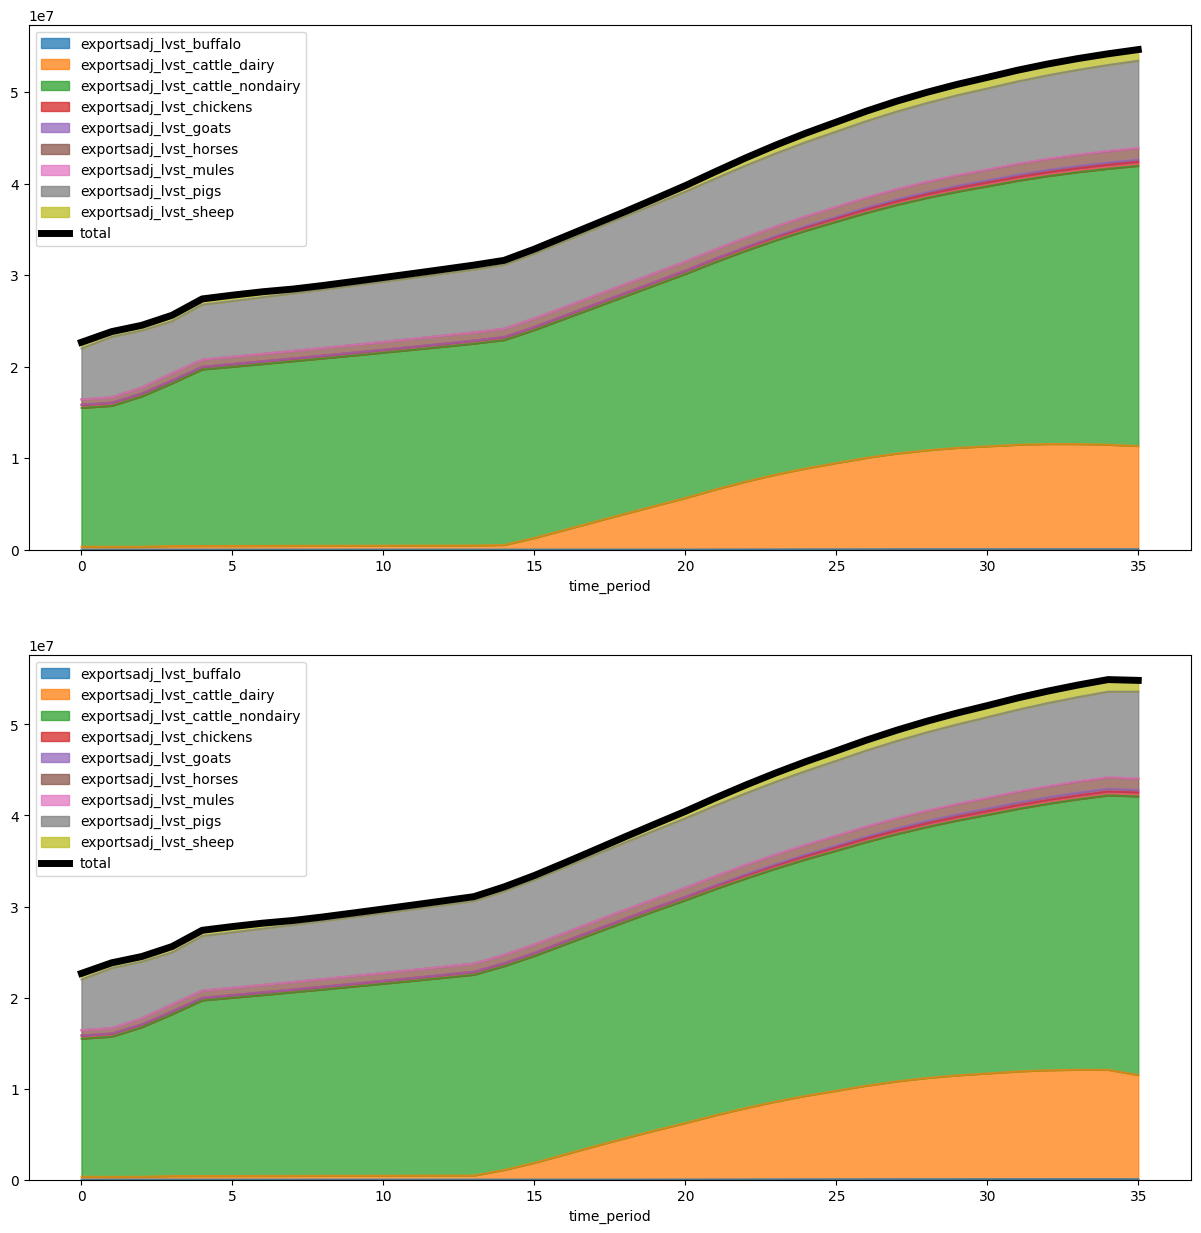

In [31]:

# 3008, 3009, 303
strat_id, strat_id_intervention = 1014, 5006
future_id = 0

# baseline
dict_filt2 = {}
for k in dict_filt.keys():
    val = dict_filt.get(k) if (k != sisepuede.key_strategy) else [strat_id]
    val = [future_id] if (k == sisepuede.key_future) else val
    dict_filt2.update({k: val[0]})

primary_id = sisepuede.odpt_primary.get_key_value(**dict_filt2)
df_filt = df_out[
    df_out[sisepuede.key_primary].isin([primary_id])
]

# intervention
dict_filt_invervention = {}
for k in dict_filt.keys():
    val = dict_filt.get(k) if (k != sisepuede.key_strategy) else [strat_id_intervention]
    val = [future_id] if (k == sisepuede.key_future) else val
    dict_filt_invervention.update({k: val[0]})
primary_id_intervention = sisepuede.odpt_primary.get_key_value(**dict_filt_invervention)
df_filt_intervention = df_out[
    df_out[sisepuede.key_primary].isin([primary_id_intervention])
]


df_in_filt = df_in[
    df_in[sisepuede.key_strategy].isin([strat_id])
]

df_in_filt_intervention = df_in[
    df_in[sisepuede.key_strategy].isin([strat_id_intervention])
]


fig, ax = plt.subplots(2, 1, figsize = (15, 15))
#ax[0].set_ylim(-150, 350)
#ax[0].set_ylim(0, 900)
#ax[1].set_ylim(0, 900)

palette_func = plt.cm.tab20#plt.cm.hsv

flds = [sisepuede.key_time_period]
if False:
    flds += [
        x for x in df_filt.columns 
        if x.startswith("emission_co2e_subsector_total") 
        and (
            False
            or ("ccsq" in x) 
            or ("entc" in x)
            or ("enfu" in x)
            or ("fgtv" in x)
            or ("inen" in x)
            or ("scoe" in x)
            or ("trns" in x)
        )
    ]
    
if False:
    flds += [
        x for x in df_filt.columns 
        if x.startswith("emission_co2e_subsector_total") 
        and (
            #True
            ("agrc" in x)
            or ("frst" in x)
            or ("lndu" in x)
            or ("lsmm" in x)
            or ("lvst" in x)
            or ("soil" in x)
            #("entc" in x) 
            #or ("scoe" in x)
            #or ("lsmm" in x)
            #or ("soil" in x)
            #or ("frst" in x)
            #or ("lndu" in x)
        )
    ]
    
if False:
    flds = [x for x in flds if "trns" in x]
    
if True:
    flds += [
        x for x in df_filt.columns 
        if x.startswith("emission_co2e_") 
        and (
            True
            #and ("lvst" in x)
            #or ("fgtv" in x)
            #and ("subsector_total" not in x)
            and ("subsector_total" in x)
            and 
            (
                True
                #("lvst" in x)
                #or ("lsmm" in x)
                #or ("soil" in x)
            )
        )
    ]

if False:
    flds += [
        x for x in df_filt.columns 
        if x.startswith("energy_demand_enfu_") 
        and (
            True
            #("entc" in x)
            #or ("fgtv" in x)
            #("inen" in x)
            & ("subsector" in x)
            & ("electricity" in x)
        )
    ]

if False:
    #flds = [x for x in df_filt.columns if x.startswith("energy_demand_enfu") and ("total" in x) and ("subsector" not in x)]# and (("natural_gas" in x) or ("crude" in x) or ("electricity" in x) or ("hydrogen" in x))]
    cat = "rail_passenger"
    pre = "energy_consumption_trns"
    fld_ignore = f"{pre}_{cat}"
    flds = [sisepuede.key_time_period] + [x for x in df_filt.columns if x.startswith(pre) and (cat in x) and (x != fld_ignore)]
    #flds = [x for x in df_filt.columns if x.startswith("passenger_distance")]

add_total = True
plot_from_modvar = True

if True:

    # AFOLU
    # modvar_plot = sisepuede.models.model_afolu.modvar_lndu_area_by_cat
    # modvar_plot = sisepuede.models.model_afolu.modvar_lndu_area_converted_from_type
    # modvar_plot = sisepuede.models.model_afolu.modvar_lndu_area_by_cat
    # modvar_plot = sisepuede.models.model_afolu.modvar_soil_emissions_co2_urea
    modvar_plot = sisepuede.models.model_afolu.modvar_lvst_pop
    modvar_plot = sisepuede.models.model_afolu.modvar_lvst_adjusted_equivalent_exports

    # modvar_plot = sisepuede.models.model_afolu.modvar_frst_emissions_co2_sequestration
    # modvar_plot = sisepuede.models.model_afolu.modvar_lndu_emissions_conv
    # modvar_plot = sisepuede.models.model_afolu.modvar_lvst_emissions_ch4_ef
    # modvar_plot = sisepuede.models.model_afolu.modvar_lsmm_emissions_ch4
    
    
    # ENERGY
    #modvar_plot = sisepuede.models.model_electricity.modvar_entc_nemomod_emissions_co2_mne
    #modvar_plot = sisepuede.models.model_electricity.modvar_entc_nemomod_production_by_technology
    #modvar_plot = sisepuede.models.model_energy.modvar_trns_energy_consumption_total
    #modvar_plot = sisepuede.models.model_energy.modvar_trns_passenger_distance_traveled
    #modvar_plot = sisepuede.models.model_energy.modvar_trns_passenger_distance_traveled
    #modvar_plot = sisepuede.models.model_energy.modvar_trde_demand_pkm
    #modvar_plot = sisepuede.models.model_energy.modvar_trns_mass_distance_traveled
    #modvar_plot = sisepuede.models.model_energy.modvar_fgtv_emissions_ch4
    #modvar_plot = sisepuede.models.model_energy.modvar_enfu_exports_fuel_adjusted
    #modvar_plot = sisepuede.models.model_energy.modvar_enfu_energy_demand_by_fuel_total
    #modvar_plot = sisepuede.models.model_energy.modvar_enfu_energy_demand_by_fuel_trns
    #modvar_plot = sisepuede.models.model_electricity.modvar_entc_nemomod_production_by_technology
    #modvar_plot = sisepuede.models.model_energy.modvar_fgtv_emissions_ch4
    #modvar_plot = sisepuede.models.model_energy.modvar_trns_vehicle_distance_traveled_electricity
    
    #IPPU
    #modvar_plot = sisepuede.models.model_ippu.modvar_ippu_qty_total_production
    
    
    
    # NO INTERVENTION
    
    df = sisepuede.model_attributes.get_standard_variables(
        df_filt,
        modvar_plot
    )
    df = pd.concat([df_filt[[sisepuede.key_time_period]].reset_index(drop = True), df], axis = 1)
    df = df[[x for x in df.columns if ("nuclear" not in x) and ("crude" not in x)]]
    df = df_filt[flds] if (not plot_from_modvar) else df
    if len(df) > 0:
        for k in df.columns:
            vec = np.array(df[k])
            bnds = (0, np.inf) if (vec[-1] >= 0) else (-np.inf, 0)
            if (max(vec) > 0) and (min(vec) < 0):
                k0 = f"{k}_positive"
                k1 = f"{k}_negative"
                df[k0] = sf.vec_bounds(np.array(df[k]), (0, np.inf))
                df[k1] = sf.vec_bounds(np.array(df[k]), (-np.inf, 0))
                df.drop([k], axis = 1, inplace = True)
            else:
                df[k] = sf.vec_bounds(np.array(df[k]), bnds)
    
    m, n = df.shape
    colors = [palette_func(x/n) for x in range(n)]
    
    alpha = 1 if not add_total else 0.75
    df.plot.area(x = sisepuede.key_time_period, ax = ax[0], color = colors, alpha = alpha)
    if add_total:
        df["total"] = df.drop([sisepuede.key_time_period], axis = 1).sum(axis = 1)
        df[[sisepuede.key_time_period, "total"]].plot(x = sisepuede.key_time_period, ax = ax[0], color = "black", linewidth = 5)
    df_plot_noint = df.copy()
        
        
    # INTERVENTION
    
    df = sisepuede.model_attributes.get_standard_variables(
        df_filt_intervention,
        modvar_plot
    )
    df = pd.concat([df_filt_intervention[[sisepuede.key_time_period]].reset_index(drop = True), df], axis = 1)
    df = df[[x for x in df.columns if ("nuclear" not in x) and ("crude" not in x)]]
    df = df_filt_intervention[flds] if (not plot_from_modvar) else df
    
    if False:
        # UNCOMMENT TO USE DIFF
        vec = np.array(df[sisepuede.key_time_period])
        flds = [x for x in df.columns if (x != sisepuede.key_time_period)]
        df = pd.DataFrame(np.array(df_filt_intervention[flds]) - np.array(df_filt[flds]), columns = flds)
        df[sisepuede.key_time_period] = vec

    
    
    for k in df.columns:
        vec = np.array(df[k])
        bnds = (0, np.inf) if (vec[-1] >= 0) else (-np.inf, 0)
        if (max(vec) > 0) and (min(vec) < 0):
            k0 = f"{k}_positive"
            k1 = f"{k}_negative"
            df[k0] = sf.vec_bounds(np.array(df[k]), (0, np.inf))
            df[k1] = sf.vec_bounds(np.array(df[k]), (-np.inf, 0))
            df.drop([k], axis = 1, inplace = True)
        else:
            df[k] = sf.vec_bounds(np.array(df[k]), bnds)
    
    m, n = df.shape
    colors = [palette_func(x/n) for x in range(n)]
    
    alpha = 1 if not add_total else 0.75
    df.plot.area(x = sisepuede.key_time_period, ax = ax[1], color = colors, alpha = alpha)
    if add_total:
        df["total"] = df.drop([sisepuede.key_time_period], axis = 1).sum(axis = 1)
        df[[sisepuede.key_time_period, "total"]].plot(x = sisepuede.key_time_period, ax = ax[1], color = "black", linewidth = 5)
    df_plot_int = df.copy()
    #df.plot(ax = ax[1], color = colors)



In [23]:
set(sisepuede.model_attributes.all_variables_output) - set(df_out.columns)

{'emission_co2e_subsector_total_econ',
 'emission_co2e_subsector_total_enfu',
 'emission_co2e_subsector_total_enst',
 'emission_co2e_subsector_total_gnrl',
 'emission_co2e_subsector_total_trde',
 'net_imports_agrc_bevs_and_spices_tonne',
 'net_imports_agrc_cereals_tonne',
 'net_imports_agrc_fibers_tonne',
 'net_imports_agrc_fruits_tonne',
 'net_imports_agrc_herbs_and_other_perennial_crops_tonne',
 'net_imports_agrc_nuts_tonne',
 'net_imports_agrc_other_annual_tonne',
 'net_imports_agrc_other_woody_perennial_tonne',
 'net_imports_agrc_pulses_tonne',
 'net_imports_agrc_rice_tonne',
 'net_imports_agrc_sugar_cane_tonne',
 'net_imports_agrc_tubers_tonne',
 'net_imports_agrc_vegetables_and_vines_tonne',
 'net_imports_change_lvst_buffalo',
 'net_imports_change_lvst_cattle_dairy',
 'net_imports_change_lvst_cattle_nondairy',
 'net_imports_change_lvst_chickens',
 'net_imports_change_lvst_goats',
 'net_imports_change_lvst_horses',
 'net_imports_change_lvst_mules',
 'net_imports_change_lvst_pigs',

In [18]:
#df_in_filt[[x for x in df_in_filt.columns if x.startswith("exports_lvst")]]
df_filt[[x for x in df_filt.columns if x.startswith("emission_co2e_subsector")]].tail().sum(axis = 1)

31    3292.424960
32    3349.195064
33    3405.958095
34    3462.737743
35    3497.690592
dtype: float64

In [19]:
#df_filt[[x for x in df_filt.columns if ("emission_co2e" in x) & ("frst" in x)]]

In [20]:
area = 196437500
0.0006*0.38*area

44787.75

In [45]:
df_filt[
    [x for x in df_filt.columns if ("emission_co2e_co2" in x) and ("metal" in x)]
].tail().sum(axis = 1)

2551    174.267899
2552    178.834690
2553    183.280485
2554    187.601053
2555    191.792604
dtype: float64

In [54]:
sa.model_attributes.get_standard_variables(
    df_filt,
    model_afolu.modvar_lndu_area_converted_from_type
).head()

,area_lndu_conversion_from_croplands,area_lndu_conversion_from_forests_mangroves,area_lndu_conversion_from_forests_primary,area_lndu_conversion_from_forests_secondary,area_lndu_conversion_from_grasslands,area_lndu_conversion_from_other,area_lndu_conversion_from_settlements,area_lndu_conversion_from_wetlands
0,34259.528106,1290.749926,1.046884e+06,143.758774,139029.789638,10351.816780,1665.974155,5988.452273
1,34737.660993,1387.556829,1.053775e+06,226.819061,140721.691235,11502.495387,1813.990762,6188.327866
2,35215.960720,1488.422663,1.059969e+06,312.865803,142419.581860,12694.055942,1964.014433,6386.192557
3,35690.757330,1593.393318,1.065468e+06,401.646669,144123.231522,13924.976806,2115.686503,6581.985642
4,36158.226832,1702.510773,1.070278e+06,492.909864,145832.664332,15193.738765,2268.660211,6775.649455


In [50]:
sa.model_attributes.get_standard_variables(
    df_filt_intervention,
    model_afolu.modvar_lndu_area_converted_to_type
).tail()

,area_lndu_conversion_to_croplands,area_lndu_conversion_to_forests_mangroves,area_lndu_conversion_to_forests_primary,area_lndu_conversion_to_forests_secondary,area_lndu_conversion_to_grasslands,area_lndu_conversion_to_other,area_lndu_conversion_to_settlements,area_lndu_conversion_to_wetlands
31,157357.062645,37970.044233,0.0,1.097878e+06,2541.747847,63277.246174,838.109221,0.0
32,153095.345389,37938.279233,0.0,1.040758e+06,2624.657364,47784.764492,474.779753,0.0
33,148612.159926,37884.350339,0.0,9.809019e+05,2711.027314,32351.521687,214.253740,0.0
34,143942.036712,37805.697454,0.0,9.197510e+05,2796.984229,16964.996037,56.339077,0.0
35,142520.597925,37955.452220,0.0,9.058818e+05,2808.063557,16960.071252,56.322722,0.0


In [44]:
df_filt_intervention[
    [x for x in df_filt_intervention.columns if ("emission_co2e_co2" in x) and ("metal" in x)]
].tail().sum(axis = 1)

2731    58.191944
2732    56.074297
2733    53.874267
2734    51.603679
2735    49.274082
dtype: float64

In [41]:
df_filt[
    [x for x in df_filt.columns if ("emission_co2e" in x) and ("metal" in x)]
].sum(axis = 1)

2520     66.733555
2521     62.952373
2522     64.726351
2523     68.608067
2524     70.595169
2525     72.326768
2526     74.194818
2527     76.067225
2528     77.930395
2529     79.782779
2530     81.622862
2531     85.791599
2532     89.976830
2533     94.171132
2534     98.367276
2535    102.558248
2536    107.067163
2537    111.561497
2538    116.033872
2539    120.477204
2540    124.884707
2541    129.532077
2542    134.131095
2543    138.675092
2544    143.157754
2545    147.573127
2546    152.303259
2547    156.951171
2548    161.511015
2549    165.977362
2550    170.345187
2551    175.049285
2552    179.636553
2553    184.102282
2554    188.442222
2555    192.652568
dtype: float64

In [4]:
importlib.reload(ma)
importlib.reload(sa)
importlib.reload(tba)
importlib.reload(tbg)
importlib.reload(tbi)
importlib.reload(tbc)
importlib.reload(tbe)
importlib.reload(dta)
importlib.reload(dtc)
importlib.reload(dte)
importlib.reload(dti)

importlib.reload(mafl)




transformations_afolu = dta.TransformationsAFOLU(
    sa.model_attributes,
    dict_config_te,
    df_input = df_input,
    field_region = "nation",
    logger = logger
)



transformations_circular_economy = dtc.TransformationsCircularEconomy(
    sa.model_attributes,
    dict_config_te,
    df_input = df_input,
    field_region = "nation",
    logger = logger
)


transformations_energy = dte.TransformationsEnergy(
    sa.model_attributes,
    dict_config_te,
    sa.dir_jl,
    sa.dir_ref_nemo,
    df_input = df_input,
    field_region = "nation",
    logger = logger
)

transformations_ippu = dti.TransformationsIPPU(
    sa.model_attributes,
    dict_config_te,
    df_input = df_input,
    field_region = "nation",
    logger = logger
)


export_q = False
sectors_run = [
    "af"#,
    #"ce",
    #"en",
    #"ip"
]
    
# initialze output components
if False:
    dfs_out = {}
    #df_out = transformations_energy.build_strategies_long()#(strategies = [0, 3003])
    if "af" in sectors_run:
        transformations_afolu._log("\nSTARTING AFOLU...\n", type_log = "info")
        df_out_afolu = transformations_afolu.build_strategies_long()#strategies = [1021])
        dfs_out.update({"af": df_out_afolu})
    
    if "ce" in sectors_run:
        transformations_afolu._log("\nSTARTING CIRCULAR ECONOMY...\n", type_log = "info")
        df_out_circular_economy = transformations_circular_economy.build_strategies_long()
        dfs_out.update({"ce": df_out_circular_economy})
    
    if "en" in sectors_run:
        transformations_energy._log("\nSTARTING ENERGY...\n", type_log = "info")
        df_out_energy = transformations_energy.build_strategies_long()
        dfs_out.update({"en": df_out_energy})
    
    if "ip" in sectors_run:
        transformations_afolu._log("\nSTARTING IPPU...\n", type_log = "info")
        df_out_ippu = transformations_ippu.build_strategies_long()
        dfs_out.update({"ip": df_out_ippu})
        

    if export_q:

        for key in dict_template_file_paths.keys():
            fp_out = dict_template_file_paths.get(key).replace(".csv", "_with_transformations.csv")

            print(f"writing to output at {fp_out}...")
            df = dfs_out.get(key)
            (
                df.to_csv(
                    fp_out,
                    index = None,
                    encoding = "UTF-8"
                )
                if df is not None
                else None
            )

    print("Done.")

    
#transformations_energy.build_strategies_long(strategies = [3015])

In [44]:
df_out = transformations_afolu.build_strategies_long(strategies = [1003])
df_out = transformations_circular_economy.build_strategies_long(strategies = [2016])
df_out[
    df_out["strategy_id"].isin([2016])
    & df_out["time_period"].isin([0, 35])
][[x for x in df_out.columns if x.startswith("frac_agrc_crop_residues_")]]

2023-06-14 12:51:57,682 - INFO - TransformationsAFOLU.build_strategies_long() starting build of 1 strategies...
2023-06-14 12:51:58,016 - INFO - 	Successfully built transformation strategy_id = 1003 ('AGRC: Improve crop residue management') in 0.33 seconds.
2023-06-14 12:51:58,100 - INFO - TransformationsAFOLU.build_strategies_long() build complete in 0.42 seconds.
2023-06-14 12:51:58,103 - INFO - TransformationsCircularEconomy.build_strategies_long() starting build of 1 strategies...
2023-06-14 12:52:01,449 - INFO - 	Successfully built transformation strategy_id = 2016 ('CE: All Circular Economy transformations') in 3.35 seconds.
2023-06-14 12:52:01,537 - INFO - TransformationsCircularEconomy.build_strategies_long() build complete in 3.43 seconds.


,frac_agrc_crop_residues_removed,frac_agrc_crop_residues_burned
612,0.2,0.05
647,0.2,0.05
648,0.2,0.05
683,0.2,0.05
684,0.2,0.05
719,0.2,0.05
720,0.2,0.05
755,0.2,0.05
756,0.2,0.05
791,0.2,0.05


In [61]:
df_test = df_input[
    df_input["iso_code3"].isin(["BRA"])
]


importlib.reload(tba)
importlib.reload(tbg)
importlib.reload(dta)
importlib.reload(mafl)




transformations_afolu = dta.TransformationsAFOLU(
    sa.model_attributes,
    dict_config_te,
    df_input = df_input,
    field_region = "nation",
    logger = logger
)


#df_run = transformations_afolu.lsmm_improve_manure_management_cattle_pigs(df_test)
#df_run = transformations_afolu.lsmm_improve_manure_management_other(df_run)
#df_run = transformations_afolu.lsmm_improve_manure_management_poultry(df_run)
#df_run = transformations_afolu.transformation_lsmm_increase_biogas_capture(df_run)

df_run = transformations_afolu.transformation_lndu_expand_conservation_agriculture(df_test)
df_out = transformations_afolu.model_afolu(df_test)
df_out_intervention = transformations_afolu.model_afolu(df_run)


In [68]:
flds = [x for x in df_out_intervention.columns if ("emission_co2e" in x) and ("lsmm" in x)]
flds += [x for x in df_out_intervention.columns if ("emission_co2e" in x) and ("soil" in x) and ("subsector_total" in x)]
flds = ["emission_co2e_subsector_total_lsmm", "emission_co2e_subsector_total_soil", "emission_co2e_subsector_total_lndu"]

df_out[flds].tail().sum(axis = 1)

31    674.089664
32    684.104434
33    694.047824
34    703.921132
35    705.805243
dtype: float64

In [69]:
df_out_intervention[flds].tail().sum(axis = 1)

31    666.739842
32    676.041671
33    685.094083
34    693.879320
35    694.488874
dtype: float64

In [23]:
model_circecon = transformations_integrated.model_circular_economy
model_circecon.modvars_waso_frac_non_recyled_pathways

['Fraction of Non-Recycled Solid Waste Incinerated',
 'Fraction of Non-Recycled Solid Waste Landfilled',
 'Fraction of Non-Recycled Solid Waste Open Dumps']

2023-06-14 05:29:13,670 - INFO - Successfully initialized SISEPUEDEFileStructure.
2023-06-14 05:29:13,670 - INFO - Successfully initialized SISEPUEDEFileStructure.
2023-06-14 05:29:13,671 - WARNING - Missing key dict_dimensional_keys: key time_series not found. Tables that rely on the time_series will not have index checking.
2023-06-14 05:29:13,671 - WARNING - Missing key dict_dimensional_keys: key time_series not found. Tables that rely on the time_series will not have index checking.
2023-06-14 05:29:13,673 - INFO - 	Setting export engine to 'sqlite'.
2023-06-14 05:29:13,673 - INFO - 	Setting export engine to 'sqlite'.
2023-06-14 05:29:13,696 - WARNING - No index fields defined. Index field values will not be checked when writing to tables.
2023-06-14 05:29:13,696 - WARNING - No index fields defined. Index field values will not be checked when writing to tables.
2023-06-14 05:29:13,698 - INFO - Successfully instantiated table ANALYSIS_METADATA
2023-06-14 05:29:13,698 - INFO - Succes